In [1]:
import numpy as np
import pickle  # 用 pickle 替代 cPickle
import gym
np.bool8 = np.bool_
import gym

In [2]:
import gym

In [3]:
env = gym.make("Pong-v4")
observation, _ = env.reset()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [4]:
def show_img(observation):
    import numpy as np
    import matplotlib.pyplot as plt

    # 创建一个随机的 (210, 160, 3) 矩阵
    image = observation
    # image = prepro_1(observation)

    # 使用 matplotlib 显示图像
    plt.imshow(image)
    # plt.axis('off')  # 隐藏坐标轴
    plt.show()

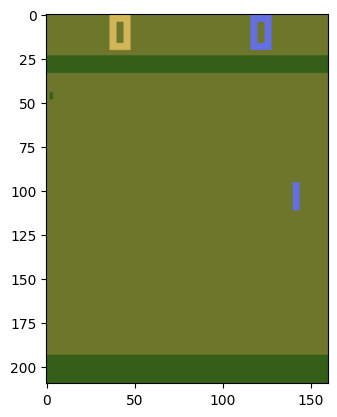

In [5]:
show_img(observation)

In [6]:
## action=2 up action=3 down

In [7]:
def prepro(I):
    """将 210x160x3 uint8 帧预处理为 6400 (80x80) 1D float 向量"""
    I = I[35:195]  # 裁剪
    I = I[::2, ::2, 0]  # 下采样因子为 2
    I[I == 144] = 0  # 删除背景类型 1
    I[I == 109] = 0  # 删除背景类型 2
    I[I != 0] = 1  # 其他设置为 1
    return I.astype(np.float32).ravel()

In [8]:
D = 6400
H = 200

In [9]:
model = {'W1':np.random.randn(H,D),'W2':np.random.randn(H)}

In [10]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [11]:
def policy_forward(x):
    ### x: 6400
    h = model['W1'] @ x
    h[h<0] = 0
    v = model['W2'] @ h
    return h, sigmoid(v)

In [12]:
x = np.random.randn(6400)

In [13]:
h,p = policy_forward(x)

In [14]:
def policy_backward(xs,logps,hs):
    ### xs: N,D logps: N, hs: N,H
    dW2 = logps @ hs
    h1 = np.outer(logps,model['W2']) ### N,H
    h1[hs <= 0] = 0
    dW1 = h1.T @ xs ## H,N @ N,D  ## H,D 
    return {'W1':dW1,'W2':dW2}

In [15]:
def discounted_rewards(rewards):
    ans = np.zeros_like(rewards)
    adding = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:adding = 0
        adding = adding * 0.99 + rewards[t]
        ans[t] = adding
    return ans

In [16]:
# def discounted_rewards(r):
#     """对奖励进行折扣"""
#     discounted_r = np.zeros_like(r)
#     running_add = 0
#     for t in reversed(range(r.size)):
#         if r[t] != 0: running_add = 0  # 如果是游戏边界（仅对 Pong 特有）
#         running_add = running_add * 0.99 + r[t]
#         discounted_r[t] = running_add
#     return discounted_r

# def policy_forward(x):
#     h = np.dot(model['W1'], x)
#     h[h < 0] = 0  # ReLU
#     logp = np.dot(model['W2'], h)
#     p = sigmoid(logp)
#     return  h,p  # 返回采取动作 2 的概率和隐藏状态

# def policy_backward(epx,epdlogp,eph):
#     """反向传播（eph 为隐藏状态数组）"""
#     dW2 = np.dot(eph.T, epdlogp).ravel()
#     dh = np.outer(epdlogp, model['W2'])
#     dh[eph <= 0] = 0  # Backprop ReLU
#     dW1 = np.dot(dh.T, epx)
#     return {'W1': dW1, 'W2': dW2}

In [20]:
model = {'W1':np.random.randn(H,D),'W2':np.random.randn(H)}
model['W1'] = np.random.randn(H, D) / np.sqrt(D)  # "Xavier" 初始化
model['W2'] = np.random.randn(H) / np.sqrt(H)

In [21]:
import numpy as np
import pickle  # 用 pickle 替代 cPickle
import gym
np.bool8 = np.bool_
import gym

env = gym.make("Pong-v4")
observation, _ = env.reset()

def prepro(I):
    """将 210x160x3 uint8 帧预处理为 6400 (80x80) 1D float 向量"""
    I = I[35:195]  # 裁剪
    I = I[::2, ::2, 0]  # 下采样因子为 2
    I[I == 144] = 0  # 删除背景类型 1
    I[I == 109] = 0  # 删除背景类型 2
    I[I != 0] = 1  # 其他设置为 1
    return I.astype(np.float32).ravel()

def sigmoid(x):
    return 1 / (1+np.exp(-x))

def policy_forward(x):
    ### x: 6400
    h = model['W1'] @ x
    h[h<0] = 0
    v = model['W2'] @ h
    return h, sigmoid(v)


def policy_backward(xs,logps,hs):
    ### xs: N,D logps: N, hs: N,H
    dW2 = logps @ hs
    h1 = np.outer(logps,model['W2']) ### N,H
    h1[hs <= 0] = 0
    dW1 = h1.T @ xs ## H,N @ N,D  ## H,D 
    return {'W1':dW1,'W2':dW2}


def discounted_rewards(rewards):
    ans = np.zeros_like(rewards)
    adding = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:adding = 0
        adding = adding * 0.99 + rewards[t]
        ans[t] = adding
    return ans

model = {'W1':np.random.randn(H,D),'W2':np.random.randn(H)}
model['W1'] = np.random.randn(H, D) / np.sqrt(D)  # "Xavier" 初始化
model['W2'] = np.random.randn(H) / np.sqrt(H)

observation, _ = env.reset()
prev_x = None
running_reward = None

xs = []
hs = []
logps = []
rewards = []
lr = 1e-3
total_sum = 0
observation, _ = env.reset()
reward_sum = 0
episode_number = 0
batch_size = 10
decay_rate = 0.99
learning_rate = 1e-3

# 更新缓存，用于 RMSProp 平滑梯度
grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}
rmsprop_cache = {k: np.zeros_like(v) for k, v in model.items()}


while True:#### epoch
    current_x = prepro(observation)
    gap = np.zeros_like(current_x) if prev_x is None else current_x - prev_x
    h,prob = policy_forward(gap)
    action = 2 if  np.random.uniform() > prob else 3
    y = 0 if action == 2 else 1
    ### 2 up 3 down
    observation, reward, terminated, truncated, info = env.step(action)  # 更新为新的返回值
    reward_sum += reward
    prev_x = current_x
    logps.append(y-prob)
    hs.append(h)
    xs.append(gap)
    rewards.append(reward)
    
    if terminated or truncated:
        episode_number += 1
        ### 轮到一个batch后开始开始模型训练
        xs = np.vstack(xs)
        hs = np.vstack(hs)
        logps = np.vstack(logps).ravel()
        rewards = np.vstack(rewards).ravel()
        dr = discounted_rewards(rewards)
        dr = dr - dr.mean()
        dr /= dr.std()
        logps = logps * dr
        grad = policy_backward(xs,logps,hs)

#         ### 先用普通方法更新
        for key,value in model.items():
            model[key] += lr * grad[key]
            
                
        #### 打印
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print(f'resetting env. episode reward total was {reward_sum}. running mean: {running_reward}')
        reward_sum = 0

        #### 清空数据
        xs = []
        hs = []
        logps = []
        rewards = []
        prev_x = None
        total_sum = 0
        observation, _ = env.reset()


resetting env. episode reward total was -20.0. running mean: -20.0
resetting env. episode reward total was -21.0. running mean: -20.01
resetting env. episode reward total was -21.0. running mean: -20.019900000000003
resetting env. episode reward total was -21.0. running mean: -20.029701000000003
resetting env. episode reward total was -19.0. running mean: -20.019403990000004
resetting env. episode reward total was -21.0. running mean: -20.029209950100004
resetting env. episode reward total was -20.0. running mean: -20.028917850599004
resetting env. episode reward total was -18.0. running mean: -20.008628672093014
resetting env. episode reward total was -20.0. running mean: -20.00854238537208
resetting env. episode reward total was -21.0. running mean: -20.01845696151836
resetting env. episode reward total was -21.0. running mean: -20.028272391903176
resetting env. episode reward total was -21.0. running mean: -20.037989667984146
resetting env. episode reward total was -21.0. running me

resetting env. episode reward total was -21.0. running mean: -20.334391568446954
resetting env. episode reward total was -21.0. running mean: -20.341047652762484
resetting env. episode reward total was -21.0. running mean: -20.34763717623486
resetting env. episode reward total was -20.0. running mean: -20.34416080447251
resetting env. episode reward total was -21.0. running mean: -20.350719196427786
resetting env. episode reward total was -21.0. running mean: -20.35721200446351
resetting env. episode reward total was -21.0. running mean: -20.363639884418873
resetting env. episode reward total was -21.0. running mean: -20.370003485574685
resetting env. episode reward total was -21.0. running mean: -20.37630345071894
resetting env. episode reward total was -21.0. running mean: -20.38254041621175
resetting env. episode reward total was -21.0. running mean: -20.388715012049634
resetting env. episode reward total was -20.0. running mean: -20.384827861929136
resetting env. episode reward tot

resetting env. episode reward total was -21.0. running mean: -20.490798874156372
resetting env. episode reward total was -21.0. running mean: -20.49589088541481
resetting env. episode reward total was -20.0. running mean: -20.49093197656066
resetting env. episode reward total was -21.0. running mean: -20.496022656795052
resetting env. episode reward total was -21.0. running mean: -20.5010624302271
resetting env. episode reward total was -21.0. running mean: -20.50605180592483
resetting env. episode reward total was -21.0. running mean: -20.510991287865583
resetting env. episode reward total was -20.0. running mean: -20.505881374986927
resetting env. episode reward total was -21.0. running mean: -20.51082256123706
resetting env. episode reward total was -21.0. running mean: -20.51571433562469
resetting env. episode reward total was -21.0. running mean: -20.520557192268445
resetting env. episode reward total was -20.0. running mean: -20.515351620345758
resetting env. episode reward total

resetting env. episode reward total was -21.0. running mean: -20.34158573757426
resetting env. episode reward total was -21.0. running mean: -20.34816988019852
resetting env. episode reward total was -21.0. running mean: -20.354688181396533
resetting env. episode reward total was -21.0. running mean: -20.361141299582567
resetting env. episode reward total was -20.0. running mean: -20.35752988658674
resetting env. episode reward total was -21.0. running mean: -20.363954587720873
resetting env. episode reward total was -21.0. running mean: -20.370315041843664
resetting env. episode reward total was -18.0. running mean: -20.346611891425226
resetting env. episode reward total was -21.0. running mean: -20.353145772510974
resetting env. episode reward total was -21.0. running mean: -20.359614314785865
resetting env. episode reward total was -21.0. running mean: -20.366018171638007
resetting env. episode reward total was -21.0. running mean: -20.37235798992163
resetting env. episode reward to

resetting env. episode reward total was -19.0. running mean: -20.226463921924296
resetting env. episode reward total was -20.0. running mean: -20.22419928270505
resetting env. episode reward total was -19.0. running mean: -20.211957289878
resetting env. episode reward total was -18.0. running mean: -20.18983771697922
resetting env. episode reward total was -21.0. running mean: -20.197939339809427
resetting env. episode reward total was -21.0. running mean: -20.205959946411333
resetting env. episode reward total was -21.0. running mean: -20.21390034694722
resetting env. episode reward total was -19.0. running mean: -20.20176134347775
resetting env. episode reward total was -20.0. running mean: -20.19974373004297
resetting env. episode reward total was -20.0. running mean: -20.19774629274254
resetting env. episode reward total was -18.0. running mean: -20.175768829815112
resetting env. episode reward total was -21.0. running mean: -20.18401114151696
resetting env. episode reward total wa

resetting env. episode reward total was -21.0. running mean: -20.296243592136015
resetting env. episode reward total was -21.0. running mean: -20.303281156214656
resetting env. episode reward total was -20.0. running mean: -20.30024834465251
resetting env. episode reward total was -20.0. running mean: -20.297245861205983
resetting env. episode reward total was -21.0. running mean: -20.304273402593925
resetting env. episode reward total was -19.0. running mean: -20.291230668567987
resetting env. episode reward total was -21.0. running mean: -20.29831836188231
resetting env. episode reward total was -18.0. running mean: -20.275335178263486
resetting env. episode reward total was -20.0. running mean: -20.27258182648085
resetting env. episode reward total was -20.0. running mean: -20.26985600821604
resetting env. episode reward total was -20.0. running mean: -20.267157448133876
resetting env. episode reward total was -20.0. running mean: -20.264485873652536
resetting env. episode reward to

resetting env. episode reward total was -18.0. running mean: -20.034224855902707
resetting env. episode reward total was -21.0. running mean: -20.04388260734368
resetting env. episode reward total was -21.0. running mean: -20.053443781270243
resetting env. episode reward total was -20.0. running mean: -20.05290934345754
resetting env. episode reward total was -21.0. running mean: -20.062380250022965
resetting env. episode reward total was -19.0. running mean: -20.051756447522738
resetting env. episode reward total was -21.0. running mean: -20.061238883047512
resetting env. episode reward total was -21.0. running mean: -20.070626494217038
resetting env. episode reward total was -20.0. running mean: -20.069920229274867
resetting env. episode reward total was -21.0. running mean: -20.07922102698212
resetting env. episode reward total was -18.0. running mean: -20.058428816712297
resetting env. episode reward total was -21.0. running mean: -20.067844528545173
resetting env. episode reward t

resetting env. episode reward total was -19.0. running mean: -19.92786236663384
resetting env. episode reward total was -20.0. running mean: -19.9285837429675
resetting env. episode reward total was -21.0. running mean: -19.939297905537828
resetting env. episode reward total was -18.0. running mean: -19.91990492648245
resetting env. episode reward total was -20.0. running mean: -19.920705877217625
resetting env. episode reward total was -21.0. running mean: -19.931498818445448
resetting env. episode reward total was -21.0. running mean: -19.942183830260994
resetting env. episode reward total was -21.0. running mean: -19.952761991958386
resetting env. episode reward total was -19.0. running mean: -19.943234372038802
resetting env. episode reward total was -20.0. running mean: -19.943802028318412
resetting env. episode reward total was -19.0. running mean: -19.934364008035228
resetting env. episode reward total was -17.0. running mean: -19.905020367954876
resetting env. episode reward to

resetting env. episode reward total was -18.0. running mean: -19.578162538395866
resetting env. episode reward total was -21.0. running mean: -19.592380913011908
resetting env. episode reward total was -20.0. running mean: -19.59645710388179
resetting env. episode reward total was -20.0. running mean: -19.60049253284297
resetting env. episode reward total was -15.0. running mean: -19.554487607514538
resetting env. episode reward total was -19.0. running mean: -19.548942731439393
resetting env. episode reward total was -21.0. running mean: -19.563453304124998
resetting env. episode reward total was -20.0. running mean: -19.567818771083747
resetting env. episode reward total was -21.0. running mean: -19.58214058337291
resetting env. episode reward total was -20.0. running mean: -19.58631917753918
resetting env. episode reward total was -20.0. running mean: -19.59045598576379
resetting env. episode reward total was -18.0. running mean: -19.57455142590615
resetting env. episode reward tota

resetting env. episode reward total was -19.0. running mean: -18.876325257274008
resetting env. episode reward total was -16.0. running mean: -18.847562004701267
resetting env. episode reward total was -21.0. running mean: -18.869086384654256
resetting env. episode reward total was -20.0. running mean: -18.880395520807713
resetting env. episode reward total was -20.0. running mean: -18.891591565599636
resetting env. episode reward total was -21.0. running mean: -18.91267564994364
resetting env. episode reward total was -19.0. running mean: -18.913548893444204
resetting env. episode reward total was -20.0. running mean: -18.92441340450976
resetting env. episode reward total was -17.0. running mean: -18.905169270464665
resetting env. episode reward total was -18.0. running mean: -18.896117577760016
resetting env. episode reward total was -19.0. running mean: -18.897156401982418
resetting env. episode reward total was -21.0. running mean: -18.918184837962595
resetting env. episode reward 

resetting env. episode reward total was -20.0. running mean: -18.232024712049235
resetting env. episode reward total was -18.0. running mean: -18.22970446492874
resetting env. episode reward total was -19.0. running mean: -18.237407420279453
resetting env. episode reward total was -13.0. running mean: -18.185033346076658
resetting env. episode reward total was -13.0. running mean: -18.13318301261589
resetting env. episode reward total was -20.0. running mean: -18.151851182489732
resetting env. episode reward total was -21.0. running mean: -18.180332670664836
resetting env. episode reward total was -17.0. running mean: -18.168529343958188
resetting env. episode reward total was -16.0. running mean: -18.146844050518606
resetting env. episode reward total was -17.0. running mean: -18.135375610013423
resetting env. episode reward total was -20.0. running mean: -18.15402185391329
resetting env. episode reward total was -15.0. running mean: -18.122481635374154
resetting env. episode reward t

resetting env. episode reward total was -12.0. running mean: -17.230967908280075
resetting env. episode reward total was -14.0. running mean: -17.198658229197274
resetting env. episode reward total was -15.0. running mean: -17.1766716469053
resetting env. episode reward total was -19.0. running mean: -17.19490493043625
resetting env. episode reward total was -16.0. running mean: -17.182955881131885
resetting env. episode reward total was -18.0. running mean: -17.191126322320567
resetting env. episode reward total was -13.0. running mean: -17.14921505909736
resetting env. episode reward total was -15.0. running mean: -17.127722908506385
resetting env. episode reward total was -15.0. running mean: -17.10644567942132
resetting env. episode reward total was -14.0. running mean: -17.075381222627108
resetting env. episode reward total was -11.0. running mean: -17.014627410400838
resetting env. episode reward total was -17.0. running mean: -17.01448113629683
resetting env. episode reward tota

resetting env. episode reward total was -17.0. running mean: -16.104993654925646
resetting env. episode reward total was -15.0. running mean: -16.09394371837639
resetting env. episode reward total was -15.0. running mean: -16.083004281192625
resetting env. episode reward total was -14.0. running mean: -16.0621742383807
resetting env. episode reward total was -13.0. running mean: -16.03155249599689
resetting env. episode reward total was -17.0. running mean: -16.041236971036923
resetting env. episode reward total was -14.0. running mean: -16.020824601326552
resetting env. episode reward total was -14.0. running mean: -16.000616355313287
resetting env. episode reward total was -12.0. running mean: -15.960610191760153
resetting env. episode reward total was -15.0. running mean: -15.951004089842552
resetting env. episode reward total was -16.0. running mean: -15.951494048944127
resetting env. episode reward total was -18.0. running mean: -15.971979108454686
resetting env. episode reward to

resetting env. episode reward total was -16.0. running mean: -15.354043652797094
resetting env. episode reward total was -13.0. running mean: -15.330503216269124
resetting env. episode reward total was -10.0. running mean: -15.277198184106432
resetting env. episode reward total was -17.0. running mean: -15.294426202265367
resetting env. episode reward total was -14.0. running mean: -15.281481940242713
resetting env. episode reward total was -13.0. running mean: -15.258667120840286
resetting env. episode reward total was -13.0. running mean: -15.236080449631883
resetting env. episode reward total was -14.0. running mean: -15.223719645135565
resetting env. episode reward total was -16.0. running mean: -15.23148244868421
resetting env. episode reward total was -17.0. running mean: -15.249167624197367
resetting env. episode reward total was -8.0. running mean: -15.176675947955394
resetting env. episode reward total was -14.0. running mean: -15.164909188475841
resetting env. episode reward 

resetting env. episode reward total was -13.0. running mean: -14.943234473142027
resetting env. episode reward total was -15.0. running mean: -14.943802128410606
resetting env. episode reward total was -15.0. running mean: -14.9443641071265
resetting env. episode reward total was -17.0. running mean: -14.964920466055235
resetting env. episode reward total was -14.0. running mean: -14.955271261394683
resetting env. episode reward total was -15.0. running mean: -14.955718548780737
resetting env. episode reward total was -9.0. running mean: -14.89616136329293
resetting env. episode reward total was -12.0. running mean: -14.86719974966
resetting env. episode reward total was -12.0. running mean: -14.8385277521634
resetting env. episode reward total was -14.0. running mean: -14.830142474641766
resetting env. episode reward total was -11.0. running mean: -14.791841049895348
resetting env. episode reward total was -17.0. running mean: -14.813922639396395
resetting env. episode reward total wa

resetting env. episode reward total was -16.0. running mean: -14.88247323336273
resetting env. episode reward total was -17.0. running mean: -14.903648501029101
resetting env. episode reward total was -15.0. running mean: -14.904612016018811
resetting env. episode reward total was -15.0. running mean: -14.905565895858624
resetting env. episode reward total was -18.0. running mean: -14.936510236900038
resetting env. episode reward total was -18.0. running mean: -14.967145134531037
resetting env. episode reward total was -17.0. running mean: -14.987473683185726
resetting env. episode reward total was -16.0. running mean: -14.997598946353868
resetting env. episode reward total was -16.0. running mean: -15.00762295689033
resetting env. episode reward total was -19.0. running mean: -15.047546727321427
resetting env. episode reward total was -15.0. running mean: -15.047071260048213
resetting env. episode reward total was -9.0. running mean: -14.98660054744773
resetting env. episode reward to

resetting env. episode reward total was -19.0. running mean: -14.863371874361594
resetting env. episode reward total was -16.0. running mean: -14.874738155617978
resetting env. episode reward total was -14.0. running mean: -14.865990774061798
resetting env. episode reward total was -17.0. running mean: -14.887330866321179
resetting env. episode reward total was -17.0. running mean: -14.908457557657966
resetting env. episode reward total was -16.0. running mean: -14.919372982081386
resetting env. episode reward total was -15.0. running mean: -14.920179252260573
resetting env. episode reward total was -18.0. running mean: -14.950977459737967
resetting env. episode reward total was -15.0. running mean: -14.951467685140587
resetting env. episode reward total was -14.0. running mean: -14.94195300828918
resetting env. episode reward total was -19.0. running mean: -14.982533478206289
resetting env. episode reward total was -11.0. running mean: -14.942708143424225
resetting env. episode reward

resetting env. episode reward total was -20.0. running mean: -14.598047319690602
resetting env. episode reward total was -4.0. running mean: -14.492066846493696
resetting env. episode reward total was -19.0. running mean: -14.537146178028758
resetting env. episode reward total was -14.0. running mean: -14.53177471624847
resetting env. episode reward total was -15.0. running mean: -14.536456969085986
resetting env. episode reward total was -8.0. running mean: -14.471092399395125
resetting env. episode reward total was -14.0. running mean: -14.466381475401175
resetting env. episode reward total was -15.0. running mean: -14.471717660647164
resetting env. episode reward total was -12.0. running mean: -14.447000484040691
resetting env. episode reward total was -11.0. running mean: -14.412530479200283
resetting env. episode reward total was -13.0. running mean: -14.398405174408282
resetting env. episode reward total was -18.0. running mean: -14.4344211226642
resetting env. episode reward tot

resetting env. episode reward total was -8.0. running mean: -13.226427538383113
resetting env. episode reward total was -13.0. running mean: -13.224163262999284
resetting env. episode reward total was -12.0. running mean: -13.21192163036929
resetting env. episode reward total was -15.0. running mean: -13.229802414065597
resetting env. episode reward total was -10.0. running mean: -13.19750438992494
resetting env. episode reward total was -10.0. running mean: -13.165529346025691
resetting env. episode reward total was -15.0. running mean: -13.183874052565434
resetting env. episode reward total was -16.0. running mean: -13.212035312039779
resetting env. episode reward total was -17.0. running mean: -13.249914958919382
resetting env. episode reward total was -16.0. running mean: -13.277415809330188
resetting env. episode reward total was -8.0. running mean: -13.224641651236887
resetting env. episode reward total was -11.0. running mean: -13.202395234724516
resetting env. episode reward to

resetting env. episode reward total was -10.0. running mean: -12.876137519012586
resetting env. episode reward total was -10.0. running mean: -12.84737614382246
resetting env. episode reward total was -11.0. running mean: -12.828902382384236
resetting env. episode reward total was -14.0. running mean: -12.840613358560393
resetting env. episode reward total was -11.0. running mean: -12.822207224974788
resetting env. episode reward total was -11.0. running mean: -12.803985152725039
resetting env. episode reward total was -5.0. running mean: -12.72594530119779
resetting env. episode reward total was -9.0. running mean: -12.688685848185811
resetting env. episode reward total was -10.0. running mean: -12.661798989703952
resetting env. episode reward total was -11.0. running mean: -12.645180999806911
resetting env. episode reward total was -14.0. running mean: -12.658729189808842
resetting env. episode reward total was -11.0. running mean: -12.642141897910752
resetting env. episode reward to

resetting env. episode reward total was -9.0. running mean: -11.938572524356042
resetting env. episode reward total was -9.0. running mean: -11.909186799112481
resetting env. episode reward total was -13.0. running mean: -11.920094931121357
resetting env. episode reward total was -11.0. running mean: -11.910893981810142
resetting env. episode reward total was -12.0. running mean: -11.91178504199204
resetting env. episode reward total was -8.0. running mean: -11.87266719157212
resetting env. episode reward total was -15.0. running mean: -11.903940519656398
resetting env. episode reward total was -14.0. running mean: -11.924901114459836
resetting env. episode reward total was -17.0. running mean: -11.975652103315237
resetting env. episode reward total was -18.0. running mean: -12.035895582282084
resetting env. episode reward total was -13.0. running mean: -12.045536626459263
resetting env. episode reward total was -16.0. running mean: -12.08508126019467
resetting env. episode reward tota

resetting env. episode reward total was -12.0. running mean: -11.780775660050645
resetting env. episode reward total was -3.0. running mean: -11.692967903450139
resetting env. episode reward total was -9.0. running mean: -11.666038224415637
resetting env. episode reward total was -9.0. running mean: -11.63937784217148
resetting env. episode reward total was -13.0. running mean: -11.652984063749766
resetting env. episode reward total was 1.0. running mean: -11.52645422311227
resetting env. episode reward total was -18.0. running mean: -11.591189680881147
resetting env. episode reward total was -15.0. running mean: -11.625277784072336
resetting env. episode reward total was -13.0. running mean: -11.639025006231615
resetting env. episode reward total was -13.0. running mean: -11.652634756169299
resetting env. episode reward total was -17.0. running mean: -11.706108408607605
resetting env. episode reward total was -12.0. running mean: -11.709047324521528
resetting env. episode reward total

resetting env. episode reward total was -15.0. running mean: -12.861072242105717
resetting env. episode reward total was -13.0. running mean: -12.862461519684661
resetting env. episode reward total was -13.0. running mean: -12.863836904487815
resetting env. episode reward total was -16.0. running mean: -12.895198535442937
resetting env. episode reward total was -19.0. running mean: -12.956246550088506
resetting env. episode reward total was -13.0. running mean: -12.956684084587621
resetting env. episode reward total was -14.0. running mean: -12.967117243741745
resetting env. episode reward total was -16.0. running mean: -12.997446071304328
resetting env. episode reward total was -19.0. running mean: -13.057471610591284
resetting env. episode reward total was -16.0. running mean: -13.08689689448537
resetting env. episode reward total was -17.0. running mean: -13.126027925540516
resetting env. episode reward total was -16.0. running mean: -13.15476764628511
resetting env. episode reward 

resetting env. episode reward total was -21.0. running mean: -14.116853751498008
resetting env. episode reward total was -15.0. running mean: -14.125685213983028
resetting env. episode reward total was -17.0. running mean: -14.154428361843197
resetting env. episode reward total was -17.0. running mean: -14.182884078224765
resetting env. episode reward total was -15.0. running mean: -14.191055237442518
resetting env. episode reward total was -19.0. running mean: -14.239144685068092
resetting env. episode reward total was -13.0. running mean: -14.226753238217412
resetting env. episode reward total was -17.0. running mean: -14.254485705835238
resetting env. episode reward total was -9.0. running mean: -14.201940848776886
resetting env. episode reward total was -14.0. running mean: -14.199921440289117
resetting env. episode reward total was -11.0. running mean: -14.167922225886224
resetting env. episode reward total was -15.0. running mean: -14.176243003627363
resetting env. episode reward

resetting env. episode reward total was -12.0. running mean: -13.330623503094062
resetting env. episode reward total was -11.0. running mean: -13.30731726806312
resetting env. episode reward total was -7.0. running mean: -13.244244095382488
resetting env. episode reward total was -12.0. running mean: -13.231801654428661
resetting env. episode reward total was -8.0. running mean: -13.179483637884374
resetting env. episode reward total was -6.0. running mean: -13.10768880150553
resetting env. episode reward total was -11.0. running mean: -13.086611913490474
resetting env. episode reward total was -13.0. running mean: -13.085745794355569
resetting env. episode reward total was -6.0. running mean: -13.014888336412014
resetting env. episode reward total was -10.0. running mean: -12.984739453047894
resetting env. episode reward total was -19.0. running mean: -13.044892058517414
resetting env. episode reward total was -9.0. running mean: -13.00444313793224
resetting env. episode reward total 

resetting env. episode reward total was -10.0. running mean: -12.145637678624135
resetting env. episode reward total was -15.0. running mean: -12.174181301837894
resetting env. episode reward total was -9.0. running mean: -12.142439488819514
resetting env. episode reward total was -19.0. running mean: -12.211015093931318
resetting env. episode reward total was -11.0. running mean: -12.198904942992003
resetting env. episode reward total was -6.0. running mean: -12.136915893562083
resetting env. episode reward total was 1.0. running mean: -12.005546734626462
resetting env. episode reward total was -14.0. running mean: -12.025491267280197
resetting env. episode reward total was -17.0. running mean: -12.075236354607394
resetting env. episode reward total was -5.0. running mean: -12.00448399106132
resetting env. episode reward total was -17.0. running mean: -12.054439151150707
resetting env. episode reward total was -4.0. running mean: -11.9738947596392
resetting env. episode reward total w

resetting env. episode reward total was -11.0. running mean: -10.782249516567447
resetting env. episode reward total was -13.0. running mean: -10.804427021401773
resetting env. episode reward total was -12.0. running mean: -10.816382751187755
resetting env. episode reward total was -7.0. running mean: -10.778218923675878
resetting env. episode reward total was -13.0. running mean: -10.80043673443912
resetting env. episode reward total was -8.0. running mean: -10.77243236709473
resetting env. episode reward total was -2.0. running mean: -10.684708043423782
resetting env. episode reward total was -7.0. running mean: -10.647860962989546
resetting env. episode reward total was -7.0. running mean: -10.61138235335965
resetting env. episode reward total was -14.0. running mean: -10.645268529826053
resetting env. episode reward total was -7.0. running mean: -10.608815844527793
resetting env. episode reward total was -13.0. running mean: -10.632727686082516
resetting env. episode reward total w

resetting env. episode reward total was -4.0. running mean: -10.668584453056102
resetting env. episode reward total was -9.0. running mean: -10.65189860852554
resetting env. episode reward total was -9.0. running mean: -10.635379622440285
resetting env. episode reward total was -6.0. running mean: -10.589025826215883
resetting env. episode reward total was -9.0. running mean: -10.573135567953724
resetting env. episode reward total was -8.0. running mean: -10.547404212274186
resetting env. episode reward total was -15.0. running mean: -10.591930170151445
resetting env. episode reward total was -9.0. running mean: -10.576010868449929
resetting env. episode reward total was -11.0. running mean: -10.580250759765429
resetting env. episode reward total was -8.0. running mean: -10.554448252167774
resetting env. episode reward total was -12.0. running mean: -10.568903769646095
resetting env. episode reward total was -6.0. running mean: -10.523214731949635
resetting env. episode reward total wa

resetting env. episode reward total was 3.0. running mean: -9.6418773793106
resetting env. episode reward total was -11.0. running mean: -9.655458605517493
resetting env. episode reward total was -13.0. running mean: -9.688904019462319
resetting env. episode reward total was -8.0. running mean: -9.672014979267695
resetting env. episode reward total was -11.0. running mean: -9.685294829475017
resetting env. episode reward total was -5.0. running mean: -9.638441881180269
resetting env. episode reward total was -4.0. running mean: -9.582057462368464
resetting env. episode reward total was 1.0. running mean: -9.47623688774478
resetting env. episode reward total was -6.0. running mean: -9.441474518867333
resetting env. episode reward total was -12.0. running mean: -9.467059773678658
resetting env. episode reward total was -9.0. running mean: -9.46238917594187
resetting env. episode reward total was -1.0. running mean: -9.377765284182452
resetting env. episode reward total was -7.0. running 

resetting env. episode reward total was -16.0. running mean: -9.98319715381439
resetting env. episode reward total was -12.0. running mean: -10.003365182276244
resetting env. episode reward total was -8.0. running mean: -9.983331530453482
resetting env. episode reward total was -15.0. running mean: -10.033498215148947
resetting env. episode reward total was -7.0. running mean: -10.003163232997458
resetting env. episode reward total was -12.0. running mean: -10.023131600667483
resetting env. episode reward total was -7.0. running mean: -9.99290028466081
resetting env. episode reward total was -10.0. running mean: -9.992971281814201
resetting env. episode reward total was -13.0. running mean: -10.02304156899606
resetting env. episode reward total was -9.0. running mean: -10.0128111533061
resetting env. episode reward total was -11.0. running mean: -10.022683041773037
resetting env. episode reward total was -5.0. running mean: -9.972456211355308
resetting env. episode reward total was -14

resetting env. episode reward total was -7.0. running mean: -9.446876495609711
resetting env. episode reward total was -13.0. running mean: -9.482407730653614
resetting env. episode reward total was -15.0. running mean: -9.53758365334708
resetting env. episode reward total was -10.0. running mean: -9.542207816813608
resetting env. episode reward total was -15.0. running mean: -9.596785738645472
resetting env. episode reward total was -16.0. running mean: -9.660817881259018
resetting env. episode reward total was -8.0. running mean: -9.644209702446428
resetting env. episode reward total was -6.0. running mean: -9.607767605421964
resetting env. episode reward total was -10.0. running mean: -9.611689929367744
resetting env. episode reward total was -9.0. running mean: -9.605573030074066
resetting env. episode reward total was -13.0. running mean: -9.639517299773326
resetting env. episode reward total was -17.0. running mean: -9.713122126775593
resetting env. episode reward total was -13.0

resetting env. episode reward total was -4.0. running mean: -9.225481559613423
resetting env. episode reward total was -10.0. running mean: -9.233226744017287
resetting env. episode reward total was -10.0. running mean: -9.240894476577115
resetting env. episode reward total was 6.0. running mean: -9.088485531811342
resetting env. episode reward total was 3.0. running mean: -8.967600676493229
resetting env. episode reward total was -6.0. running mean: -8.937924669728297
resetting env. episode reward total was -9.0. running mean: -8.938545423031014
resetting env. episode reward total was -6.0. running mean: -8.909159968800704
resetting env. episode reward total was -2.0. running mean: -8.840068369112696
resetting env. episode reward total was -11.0. running mean: -8.861667685421569
resetting env. episode reward total was 2.0. running mean: -8.753051008567354
resetting env. episode reward total was 7.0. running mean: -8.59552049848168
resetting env. episode reward total was -11.0. running

resetting env. episode reward total was -11.0. running mean: -7.687281272081501
resetting env. episode reward total was -17.0. running mean: -7.780408459360686
resetting env. episode reward total was -14.0. running mean: -7.842604374767078
resetting env. episode reward total was -10.0. running mean: -7.864178331019407
resetting env. episode reward total was -9.0. running mean: -7.875536547709213
resetting env. episode reward total was -11.0. running mean: -7.9067811822321215
resetting env. episode reward total was -8.0. running mean: -7.9077133704098
resetting env. episode reward total was -11.0. running mean: -7.938636236705702
resetting env. episode reward total was -11.0. running mean: -7.9692498743386455
resetting env. episode reward total was -12.0. running mean: -8.009557375595259
resetting env. episode reward total was -16.0. running mean: -8.089461801839306
resetting env. episode reward total was -8.0. running mean: -8.088567183820913
resetting env. episode reward total was -8.

resetting env. episode reward total was -10.0. running mean: -7.081707499336635
resetting env. episode reward total was -17.0. running mean: -7.180890424343269
resetting env. episode reward total was -5.0. running mean: -7.159081520099836
resetting env. episode reward total was -12.0. running mean: -7.207490704898837
resetting env. episode reward total was -16.0. running mean: -7.295415797849849
resetting env. episode reward total was -5.0. running mean: -7.2724616398713495
resetting env. episode reward total was -3.0. running mean: -7.229737023472636
resetting env. episode reward total was -15.0. running mean: -7.3074396532379104
resetting env. episode reward total was -8.0. running mean: -7.314365256705531
resetting env. episode reward total was -4.0. running mean: -7.281221604138476
resetting env. episode reward total was -9.0. running mean: -7.298409388097091
resetting env. episode reward total was -9.0. running mean: -7.315425294216119
resetting env. episode reward total was -4.0.

resetting env. episode reward total was -16.0. running mean: -7.857309357877033
resetting env. episode reward total was -13.0. running mean: -7.908736264298263
resetting env. episode reward total was -3.0. running mean: -7.85964890165528
resetting env. episode reward total was -8.0. running mean: -7.861052412638728
resetting env. episode reward total was -4.0. running mean: -7.822441888512341
resetting env. episode reward total was -1.0. running mean: -7.754217469627217
resetting env. episode reward total was -6.0. running mean: -7.7366752949309445
resetting env. episode reward total was -15.0. running mean: -7.809308541981635
resetting env. episode reward total was -8.0. running mean: -7.811215456561819
resetting env. episode reward total was -6.0. running mean: -7.793103301996201
resetting env. episode reward total was -8.0. running mean: -7.795172268976239
resetting env. episode reward total was -18.0. running mean: -7.8972205462864755
resetting env. episode reward total was -1.0. r

resetting env. episode reward total was 10.0. running mean: -6.278193024945103
resetting env. episode reward total was 3.0. running mean: -6.1854110946956515
resetting env. episode reward total was -9.0. running mean: -6.213556983748695
resetting env. episode reward total was -9.0. running mean: -6.241421413911207
resetting env. episode reward total was -3.0. running mean: -6.2090071997720955
resetting env. episode reward total was -2.0. running mean: -6.166917127774374
resetting env. episode reward total was -2.0. running mean: -6.125247956496629
resetting env. episode reward total was -10.0. running mean: -6.163995476931663
resetting env. episode reward total was -9.0. running mean: -6.192355522162346
resetting env. episode reward total was -11.0. running mean: -6.240431966940723
resetting env. episode reward total was -6.0. running mean: -6.238027647271315
resetting env. episode reward total was -11.0. running mean: -6.2856473707986025
resetting env. episode reward total was -2.0. r

resetting env. episode reward total was -11.0. running mean: -5.750644502720387
resetting env. episode reward total was -7.0. running mean: -5.763138057693184
resetting env. episode reward total was -4.0. running mean: -5.745506677116253
resetting env. episode reward total was -7.0. running mean: -5.75805161034509
resetting env. episode reward total was -2.0. running mean: -5.720471094241638
resetting env. episode reward total was -7.0. running mean: -5.733266383299222
resetting env. episode reward total was -6.0. running mean: -5.73593371946623
resetting env. episode reward total was -6.0. running mean: -5.738574382271567
resetting env. episode reward total was -9.0. running mean: -5.7711886384488515
resetting env. episode reward total was -11.0. running mean: -5.823476752064363
resetting env. episode reward total was -7.0. running mean: -5.835241984543719
resetting env. episode reward total was -11.0. running mean: -5.886889564698283
resetting env. episode reward total was -10.0. run

resetting env. episode reward total was -2.0. running mean: -6.362766084398305
resetting env. episode reward total was -17.0. running mean: -6.4691384235543214
resetting env. episode reward total was -16.0. running mean: -6.564447039318778
resetting env. episode reward total was 4.0. running mean: -6.45880256892559
resetting env. episode reward total was -12.0. running mean: -6.514214543236334
resetting env. episode reward total was -13.0. running mean: -6.57907239780397
resetting env. episode reward total was -13.0. running mean: -6.64328167382593
resetting env. episode reward total was -12.0. running mean: -6.696848857087671
resetting env. episode reward total was -1.0. running mean: -6.639880368516795
resetting env. episode reward total was -6.0. running mean: -6.6334815648316265
resetting env. episode reward total was -18.0. running mean: -6.74714674918331
resetting env. episode reward total was -17.0. running mean: -6.849675281691477
resetting env. episode reward total was -14.0. 

resetting env. episode reward total was -12.0. running mean: -7.894456613951966
resetting env. episode reward total was -10.0. running mean: -7.915512047812445
resetting env. episode reward total was -5.0. running mean: -7.886356927334321
resetting env. episode reward total was -4.0. running mean: -7.847493358060977
resetting env. episode reward total was -11.0. running mean: -7.879018424480368
resetting env. episode reward total was -10.0. running mean: -7.900228240235563
resetting env. episode reward total was -9.0. running mean: -7.911225957833207
resetting env. episode reward total was 5.0. running mean: -7.782113698254875
resetting env. episode reward total was -2.0. running mean: -7.724292561272326
resetting env. episode reward total was -17.0. running mean: -7.817049635659602
resetting env. episode reward total was -10.0. running mean: -7.838879139303006
resetting env. episode reward total was -7.0. running mean: -7.830490347909976
resetting env. episode reward total was -16.0. 

resetting env. episode reward total was -8.0. running mean: -7.6677314573327795
resetting env. episode reward total was -15.0. running mean: -7.741054142759452
resetting env. episode reward total was -9.0. running mean: -7.7536436013318575
resetting env. episode reward total was -12.0. running mean: -7.7961071653185385
resetting env. episode reward total was -5.0. running mean: -7.768146093665353
resetting env. episode reward total was -6.0. running mean: -7.750464632728699
resetting env. episode reward total was -9.0. running mean: -7.762959986401412
resetting env. episode reward total was -8.0. running mean: -7.765330386537397
resetting env. episode reward total was -13.0. running mean: -7.817677082672023
resetting env. episode reward total was -14.0. running mean: -7.879500311845302
resetting env. episode reward total was -15.0. running mean: -7.950705308726849
resetting env. episode reward total was -2.0. running mean: -7.89119825563958
resetting env. episode reward total was -10.0

resetting env. episode reward total was -2.0. running mean: -8.120803302713266
resetting env. episode reward total was -11.0. running mean: -8.149595269686133
resetting env. episode reward total was -15.0. running mean: -8.21809931698927
resetting env. episode reward total was -7.0. running mean: -8.205918323819379
resetting env. episode reward total was 4.0. running mean: -8.083859140581186
resetting env. episode reward total was -5.0. running mean: -8.053020549175375
resetting env. episode reward total was -9.0. running mean: -8.062490343683622
resetting env. episode reward total was 2.0. running mean: -7.961865440246786
resetting env. episode reward total was -9.0. running mean: -7.972246785844318
resetting env. episode reward total was 9.0. running mean: -7.802524317985875
resetting env. episode reward total was -7.0. running mean: -7.794499074806017
resetting env. episode reward total was -11.0. running mean: -7.826554084057957
resetting env. episode reward total was -15.0. runnin

resetting env. episode reward total was -11.0. running mean: -6.844770995663976
resetting env. episode reward total was -13.0. running mean: -6.906323285707336
resetting env. episode reward total was -6.0. running mean: -6.897260052850262
resetting env. episode reward total was -18.0. running mean: -7.008287452321759
resetting env. episode reward total was -12.0. running mean: -7.058204577798541
resetting env. episode reward total was -9.0. running mean: -7.0776225320205555
resetting env. episode reward total was -10.0. running mean: -7.10684630670035
resetting env. episode reward total was -12.0. running mean: -7.155777843633346
resetting env. episode reward total was -9.0. running mean: -7.174220065197012
resetting env. episode reward total was -10.0. running mean: -7.202477864545042
resetting env. episode reward total was -4.0. running mean: -7.170453085899592
resetting env. episode reward total was -10.0. running mean: -7.198748555040595
resetting env. episode reward total was -11.

resetting env. episode reward total was -4.0. running mean: -7.498734650892759
resetting env. episode reward total was -13.0. running mean: -7.5537473043838315
resetting env. episode reward total was -10.0. running mean: -7.578209831339993
resetting env. episode reward total was -11.0. running mean: -7.612427733026593
resetting env. episode reward total was -5.0. running mean: -7.586303455696326
resetting env. episode reward total was -10.0. running mean: -7.610440421139362
resetting env. episode reward total was -17.0. running mean: -7.704336016927968
resetting env. episode reward total was 1.0. running mean: -7.617292656758688
resetting env. episode reward total was -9.0. running mean: -7.631119730191101
resetting env. episode reward total was -11.0. running mean: -7.66480853288919
resetting env. episode reward total was -7.0. running mean: -7.658160447560299
resetting env. episode reward total was -4.0. running mean: -7.621578843084696
resetting env. episode reward total was -17.0. 

resetting env. episode reward total was -4.0. running mean: -7.972707150779662
resetting env. episode reward total was -10.0. running mean: -7.992980079271865
resetting env. episode reward total was -8.0. running mean: -7.993050278479147
resetting env. episode reward total was -6.0. running mean: -7.973119775694355
resetting env. episode reward total was -4.0. running mean: -7.933388577937411
resetting env. episode reward total was -6.0. running mean: -7.914054692158036
resetting env. episode reward total was -9.0. running mean: -7.924914145236455
resetting env. episode reward total was 6.0. running mean: -7.785665003784091
resetting env. episode reward total was -17.0. running mean: -7.87780835374625
resetting env. episode reward total was -7.0. running mean: -7.869030270208787
resetting env. episode reward total was -19.0. running mean: -7.9803399675066995
resetting env. episode reward total was -5.0. running mean: -7.950536567831632
resetting env. episode reward total was -7.0. runn

resetting env. episode reward total was -12.0. running mean: -6.724478205816051
resetting env. episode reward total was -5.0. running mean: -6.70723342375789
resetting env. episode reward total was 5.0. running mean: -6.590161089520311
resetting env. episode reward total was -3.0. running mean: -6.5542594786251085
resetting env. episode reward total was -8.0. running mean: -6.568716883838857
resetting env. episode reward total was 4.0. running mean: -6.463029715000469
resetting env. episode reward total was 2.0. running mean: -6.378399417850465
resetting env. episode reward total was -5.0. running mean: -6.36461542367196
resetting env. episode reward total was -1.0. running mean: -6.31096926943524
resetting env. episode reward total was -7.0. running mean: -6.317859576740888
resetting env. episode reward total was -3.0. running mean: -6.284680980973479
resetting env. episode reward total was 6.0. running mean: -6.161834171163744
resetting env. episode reward total was -2.0. running mea

resetting env. episode reward total was 1.0. running mean: -6.046501167620579
resetting env. episode reward total was -6.0. running mean: -6.046036155944373
resetting env. episode reward total was -11.0. running mean: -6.09557579438493
resetting env. episode reward total was -11.0. running mean: -6.14462003644108
resetting env. episode reward total was -10.0. running mean: -6.183173836076669
resetting env. episode reward total was -7.0. running mean: -6.191342097715903
resetting env. episode reward total was -13.0. running mean: -6.259428676738743
resetting env. episode reward total was -4.0. running mean: -6.236834389971356
resetting env. episode reward total was -6.0. running mean: -6.234466046071642
resetting env. episode reward total was -9.0. running mean: -6.262121385610925
resetting env. episode reward total was -13.0. running mean: -6.329500171754815
resetting env. episode reward total was -11.0. running mean: -6.3762051700372675
resetting env. episode reward total was -11.0. r

resetting env. episode reward total was -8.0. running mean: -5.88003432472234
resetting env. episode reward total was -14.0. running mean: -5.961233981475116
resetting env. episode reward total was 7.0. running mean: -5.831621641660365
resetting env. episode reward total was 3.0. running mean: -5.743305425243761
resetting env. episode reward total was 9.0. running mean: -5.595872370991324
resetting env. episode reward total was 6.0. running mean: -5.4799136472814105
resetting env. episode reward total was 11.0. running mean: -5.315114510808596
resetting env. episode reward total was -10.0. running mean: -5.361963365700509
resetting env. episode reward total was -9.0. running mean: -5.398343732043504
resetting env. episode reward total was 5.0. running mean: -5.294360294723069
resetting env. episode reward total was -8.0. running mean: -5.3214166917758385
resetting env. episode reward total was -15.0. running mean: -5.4182025248580805
resetting env. episode reward total was -2.0. runnin

resetting env. episode reward total was -13.0. running mean: -5.946727557539137
resetting env. episode reward total was -13.0. running mean: -6.017260281963745
resetting env. episode reward total was -1.0. running mean: -5.967087679144107
resetting env. episode reward total was -9.0. running mean: -5.997416802352666
resetting env. episode reward total was -13.0. running mean: -6.067442634329139
resetting env. episode reward total was -11.0. running mean: -6.1167682079858485
resetting env. episode reward total was 2.0. running mean: -6.03560052590599
resetting env. episode reward total was -8.0. running mean: -6.05524452064693
resetting env. episode reward total was -13.0. running mean: -6.124692075440461
resetting env. episode reward total was -1.0. running mean: -6.0734451546860555
resetting env. episode reward total was 2.0. running mean: -5.9927107031391955
resetting env. episode reward total was -7.0. running mean: -6.002783596107804
resetting env. episode reward total was -7.0. ru

resetting env. episode reward total was 2.0. running mean: -5.839092409687498
resetting env. episode reward total was -10.0. running mean: -5.880701485590623
resetting env. episode reward total was 8.0. running mean: -5.741894470734716
resetting env. episode reward total was 4.0. running mean: -5.644475526027369
resetting env. episode reward total was -13.0. running mean: -5.718030770767095
resetting env. episode reward total was -3.0. running mean: -5.690850463059425
resetting env. episode reward total was -10.0. running mean: -5.73394195842883
resetting env. episode reward total was -12.0. running mean: -5.796602538844542
resetting env. episode reward total was 2.0. running mean: -5.718636513456097
resetting env. episode reward total was -7.0. running mean: -5.731450148321536
resetting env. episode reward total was -10.0. running mean: -5.77413564683832
resetting env. episode reward total was -6.0. running mean: -5.776394290369937
resetting env. episode reward total was 8.0. running 

resetting env. episode reward total was 1.0. running mean: -5.974775271190608
resetting env. episode reward total was -7.0. running mean: -5.985027518478702
resetting env. episode reward total was 2.0. running mean: -5.905177243293916
resetting env. episode reward total was -12.0. running mean: -5.966125470860977
resetting env. episode reward total was -11.0. running mean: -6.016464216152367
resetting env. episode reward total was -18.0. running mean: -6.1362995739908435
resetting env. episode reward total was 3.0. running mean: -6.044936578250935
resetting env. episode reward total was -2.0. running mean: -6.004487212468425
resetting env. episode reward total was 1.0. running mean: -5.934442340343741
resetting env. episode reward total was -17.0. running mean: -6.045097916940304
resetting env. episode reward total was -10.0. running mean: -6.084646937770901
resetting env. episode reward total was -9.0. running mean: -6.113800468393192
resetting env. episode reward total was -8.0. runn

resetting env. episode reward total was -13.0. running mean: -6.2444465880989775
resetting env. episode reward total was -8.0. running mean: -6.262002122217988
resetting env. episode reward total was -8.0. running mean: -6.279382100995807
resetting env. episode reward total was -9.0. running mean: -6.306588279985849
resetting env. episode reward total was -11.0. running mean: -6.353522397185991
resetting env. episode reward total was -10.0. running mean: -6.389987173214131
resetting env. episode reward total was -16.0. running mean: -6.486087301481989
resetting env. episode reward total was -1.0. running mean: -6.431226428467169
resetting env. episode reward total was -5.0. running mean: -6.416914164182497
resetting env. episode reward total was -12.0. running mean: -6.472745022540672
resetting env. episode reward total was -6.0. running mean: -6.468017572315265
resetting env. episode reward total was -5.0. running mean: -6.453337396592112
resetting env. episode reward total was -11.0.

resetting env. episode reward total was -7.0. running mean: -5.774175234494398
resetting env. episode reward total was -11.0. running mean: -5.826433482149454
resetting env. episode reward total was -9.0. running mean: -5.85816914732796
resetting env. episode reward total was -9.0. running mean: -5.88958745585468
resetting env. episode reward total was -11.0. running mean: -5.940691581296133
resetting env. episode reward total was -7.0. running mean: -5.951284665483172
resetting env. episode reward total was -6.0. running mean: -5.95177181882834
resetting env. episode reward total was -2.0. running mean: -5.912254100640056
resetting env. episode reward total was -10.0. running mean: -5.953131559633655
resetting env. episode reward total was -11.0. running mean: -6.003600244037319
resetting env. episode reward total was -11.0. running mean: -6.053564241596946
resetting env. episode reward total was 1.0. running mean: -5.983028599180977
resetting env. episode reward total was 1.0. runnin

resetting env. episode reward total was -8.0. running mean: -5.418730520394153
resetting env. episode reward total was -2.0. running mean: -5.38454321519021
resetting env. episode reward total was 1.0. running mean: -5.320697783038309
resetting env. episode reward total was 6.0. running mean: -5.207490805207926
resetting env. episode reward total was 4.0. running mean: -5.115415897155847
resetting env. episode reward total was 3.0. running mean: -5.034261738184288
resetting env. episode reward total was -2.0. running mean: -5.003919120802444
resetting env. episode reward total was -2.0. running mean: -4.973879929594419
resetting env. episode reward total was -3.0. running mean: -4.954141130298475
resetting env. episode reward total was 4.0. running mean: -4.86459971899549
resetting env. episode reward total was 5.0. running mean: -4.765953721805535
resetting env. episode reward total was -11.0. running mean: -4.82829418458748
resetting env. episode reward total was 3.0. running mean: -

resetting env. episode reward total was -4.0. running mean: -4.520822085247757
resetting env. episode reward total was 4.0. running mean: -4.43561386439528
resetting env. episode reward total was 6.0. running mean: -4.331257725751327
resetting env. episode reward total was -6.0. running mean: -4.347945148493814
resetting env. episode reward total was -4.0. running mean: -4.344465697008876
resetting env. episode reward total was -6.0. running mean: -4.3610210400387865
resetting env. episode reward total was 6.0. running mean: -4.257410829638399
resetting env. episode reward total was -1.0. running mean: -4.224836721342014
resetting env. episode reward total was -9.0. running mean: -4.272588354128594
resetting env. episode reward total was -5.0. running mean: -4.279862470587307
resetting env. episode reward total was 5.0. running mean: -4.187063845881434
resetting env. episode reward total was -9.0. running mean: -4.23519320742262
resetting env. episode reward total was -8.0. running mea

resetting env. episode reward total was -6.0. running mean: -4.002717619626967
resetting env. episode reward total was -7.0. running mean: -4.032690443430697
resetting env. episode reward total was -6.0. running mean: -4.05236353899639
resetting env. episode reward total was -8.0. running mean: -4.091839903606426
resetting env. episode reward total was 4.0. running mean: -4.010921504570362
resetting env. episode reward total was -14.0. running mean: -4.110812289524659
resetting env. episode reward total was 1.0. running mean: -4.0597041666294125
resetting env. episode reward total was -3.0. running mean: -4.049107124963118
resetting env. episode reward total was -1.0. running mean: -4.018616053713487
resetting env. episode reward total was -5.0. running mean: -4.028429893176352
resetting env. episode reward total was -2.0. running mean: -4.008145594244588
resetting env. episode reward total was 6.0. running mean: -3.9080641383021417
resetting env. episode reward total was -2.0. running

resetting env. episode reward total was 6.0. running mean: -3.1142147044876642
resetting env. episode reward total was 11.0. running mean: -2.9730725574427876
resetting env. episode reward total was 2.0. running mean: -2.9233418318683597
resetting env. episode reward total was 11.0. running mean: -2.784108413549676
resetting env. episode reward total was -1.0. running mean: -2.766267329414179
resetting env. episode reward total was -7.0. running mean: -2.8086046561200373
resetting env. episode reward total was -9.0. running mean: -2.870518609558837
resetting env. episode reward total was -7.0. running mean: -2.9118134234632485
resetting env. episode reward total was 2.0. running mean: -2.8626952892286157
resetting env. episode reward total was -11.0. running mean: -2.9440683363363296
resetting env. episode reward total was -9.0. running mean: -3.004627652972966
resetting env. episode reward total was -2.0. running mean: -2.9945813764432363
resetting env. episode reward total was 5.0. r

resetting env. episode reward total was -6.0. running mean: -3.479439141766152
resetting env. episode reward total was 7.0. running mean: -3.3746447503484904
resetting env. episode reward total was -7.0. running mean: -3.4108983028450055
resetting env. episode reward total was -9.0. running mean: -3.4667893198165554
resetting env. episode reward total was -5.0. running mean: -3.4821214266183897
resetting env. episode reward total was -7.0. running mean: -3.5173002123522057
resetting env. episode reward total was 6.0. running mean: -3.4221272102286835
resetting env. episode reward total was -11.0. running mean: -3.4979059381263964
resetting env. episode reward total was -8.0. running mean: -3.5429268787451327
resetting env. episode reward total was 4.0. running mean: -3.467497609957681
resetting env. episode reward total was -5.0. running mean: -3.482822633858104
resetting env. episode reward total was -3.0. running mean: -3.477994407519523
resetting env. episode reward total was -10.0.

resetting env. episode reward total was -9.0. running mean: -5.24368330687967
resetting env. episode reward total was -5.0. running mean: -5.2412464738108735
resetting env. episode reward total was -9.0. running mean: -5.278834009072765
resetting env. episode reward total was -1.0. running mean: -5.236045668982037
resetting env. episode reward total was 1.0. running mean: -5.173685212292217
resetting env. episode reward total was -5.0. running mean: -5.171948360169294
resetting env. episode reward total was -11.0. running mean: -5.230228876567601
resetting env. episode reward total was -11.0. running mean: -5.287926587801925
resetting env. episode reward total was -3.0. running mean: -5.265047321923906
resetting env. episode reward total was -11.0. running mean: -5.322396848704668
resetting env. episode reward total was -10.0. running mean: -5.36917288021762
resetting env. episode reward total was -2.0. running mean: -5.335481151415443
resetting env. episode reward total was -13.0. run

resetting env. episode reward total was -15.0. running mean: -5.184083150490936
resetting env. episode reward total was -15.0. running mean: -5.282242318986027
resetting env. episode reward total was -3.0. running mean: -5.259419895796167
resetting env. episode reward total was -5.0. running mean: -5.256825696838205
resetting env. episode reward total was -6.0. running mean: -5.264257439869822
resetting env. episode reward total was -9.0. running mean: -5.301614865471124
resetting env. episode reward total was -3.0. running mean: -5.278598716816413
resetting env. episode reward total was -1.0. running mean: -5.235812729648249
resetting env. episode reward total was -6.0. running mean: -5.243454602351766
resetting env. episode reward total was -7.0. running mean: -5.261020056328248
resetting env. episode reward total was -9.0. running mean: -5.298409855764965
resetting env. episode reward total was -11.0. running mean: -5.355425757207316
resetting env. episode reward total was -6.0. run

resetting env. episode reward total was 3.0. running mean: -5.026003162920897
resetting env. episode reward total was -12.0. running mean: -5.095743131291688
resetting env. episode reward total was 8.0. running mean: -4.964785699978771
resetting env. episode reward total was -2.0. running mean: -4.935137842978983
resetting env. episode reward total was -5.0. running mean: -4.935786464549193
resetting env. episode reward total was -1.0. running mean: -4.896428599903701
resetting env. episode reward total was -7.0. running mean: -4.917464313904665
resetting env. episode reward total was 10.0. running mean: -4.768289670765618
resetting env. episode reward total was -9.0. running mean: -4.810606774057962
resetting env. episode reward total was -12.0. running mean: -4.882500706317382
resetting env. episode reward total was -3.0. running mean: -4.863675699254208
resetting env. episode reward total was 4.0. running mean: -4.7750389422616655
resetting env. episode reward total was -7.0. runnin

resetting env. episode reward total was -7.0. running mean: -4.647348759334275
resetting env. episode reward total was -10.0. running mean: -4.700875271740932
resetting env. episode reward total was -13.0. running mean: -4.783866519023523
resetting env. episode reward total was -4.0. running mean: -4.776027853833288
resetting env. episode reward total was -11.0. running mean: -4.838267575294955
resetting env. episode reward total was -11.0. running mean: -4.8998848995420055
resetting env. episode reward total was -14.0. running mean: -4.990886050546585
resetting env. episode reward total was -9.0. running mean: -5.030977190041119
resetting env. episode reward total was -9.0. running mean: -5.070667418140707
resetting env. episode reward total was -2.0. running mean: -5.039960743959299
resetting env. episode reward total was -7.0. running mean: -5.059561136519706
resetting env. episode reward total was -9.0. running mean: -5.098965525154509
resetting env. episode reward total was -13.0.

resetting env. episode reward total was -1.0. running mean: -5.9467433918394175
resetting env. episode reward total was -1.0. running mean: -5.897275957921023
resetting env. episode reward total was -1.0. running mean: -5.848303198341813
resetting env. episode reward total was -3.0. running mean: -5.819820166358395
resetting env. episode reward total was -11.0. running mean: -5.871621964694811
resetting env. episode reward total was -9.0. running mean: -5.902905745047863
resetting env. episode reward total was -2.0. running mean: -5.863876687597384
resetting env. episode reward total was 1.0. running mean: -5.79523792072141
resetting env. episode reward total was -9.0. running mean: -5.827285541514196
resetting env. episode reward total was -4.0. running mean: -5.809012686099054
resetting env. episode reward total was -10.0. running mean: -5.850922559238063
resetting env. episode reward total was -5.0. running mean: -5.842413333645682
resetting env. episode reward total was -11.0. runn

resetting env. episode reward total was 3.0. running mean: -5.358047222054883
resetting env. episode reward total was -2.0. running mean: -5.324466749834333
resetting env. episode reward total was -8.0. running mean: -5.35122208233599
resetting env. episode reward total was -17.0. running mean: -5.46770986151263
resetting env. episode reward total was 5.0. running mean: -5.363032762897504
resetting env. episode reward total was -6.0. running mean: -5.369402435268529
resetting env. episode reward total was -10.0. running mean: -5.415708410915843
resetting env. episode reward total was 8.0. running mean: -5.281551326806684
resetting env. episode reward total was -3.0. running mean: -5.2587358135386175
resetting env. episode reward total was -1.0. running mean: -5.216148455403231
resetting env. episode reward total was -9.0. running mean: -5.253986970849199
resetting env. episode reward total was -11.0. running mean: -5.311447101140707
resetting env. episode reward total was -5.0. running

resetting env. episode reward total was -15.0. running mean: -4.529630821769967
resetting env. episode reward total was 1.0. running mean: -4.474334513552267
resetting env. episode reward total was -6.0. running mean: -4.489591168416744
resetting env. episode reward total was -3.0. running mean: -4.474695256732577
resetting env. episode reward total was -1.0. running mean: -4.439948304165251
resetting env. episode reward total was -10.0. running mean: -4.495548821123599
resetting env. episode reward total was 6.0. running mean: -4.390593332912363
resetting env. episode reward total was -3.0. running mean: -4.37668739958324
resetting env. episode reward total was -3.0. running mean: -4.362920525587407
resetting env. episode reward total was 2.0. running mean: -4.299291320331534
resetting env. episode reward total was 3.0. running mean: -4.226298407128218
resetting env. episode reward total was -9.0. running mean: -4.274035423056936
resetting env. episode reward total was -7.0. running m

resetting env. episode reward total was 8.0. running mean: -2.253667517714561
resetting env. episode reward total was -3.0. running mean: -2.2611308425374155
resetting env. episode reward total was -1.0. running mean: -2.248519534112041
resetting env. episode reward total was 12.0. running mean: -2.106034338770921
resetting env. episode reward total was -2.0. running mean: -2.1049739953832116
resetting env. episode reward total was 1.0. running mean: -2.0739242554293797
resetting env. episode reward total was 5.0. running mean: -2.003185012875086
resetting env. episode reward total was 1.0. running mean: -1.9731531627463352
resetting env. episode reward total was -11.0. running mean: -2.063421631118872
resetting env. episode reward total was 3.0. running mean: -2.012787414807683
resetting env. episode reward total was -3.0. running mean: -2.0226595406596064
resetting env. episode reward total was 9.0. running mean: -1.9124329452530102
resetting env. episode reward total was -1.0. runni

resetting env. episode reward total was -5.0. running mean: -0.8084600404235935
resetting env. episode reward total was 12.0. running mean: -0.6803754400193576
resetting env. episode reward total was -7.0. running mean: -0.7435716856191641
resetting env. episode reward total was 6.0. running mean: -0.6761359687629724
resetting env. episode reward total was -9.0. running mean: -0.7593746090753427
resetting env. episode reward total was 11.0. running mean: -0.6417808629845893
resetting env. episode reward total was -11.0. running mean: -0.7453630543547434
resetting env. episode reward total was 5.0. running mean: -0.6879094238111959
resetting env. episode reward total was -7.0. running mean: -0.751030329573084
resetting env. episode reward total was 13.0. running mean: -0.6135200262773531
resetting env. episode reward total was 4.0. running mean: -0.5673848260145795
resetting env. episode reward total was -1.0. running mean: -0.5717109777544337
resetting env. episode reward total was -5.

resetting env. episode reward total was -3.0. running mean: -2.790752604238673
resetting env. episode reward total was -8.0. running mean: -2.8428450781962864
resetting env. episode reward total was -5.0. running mean: -2.8644166274143235
resetting env. episode reward total was 9.0. running mean: -2.7457724611401804
resetting env. episode reward total was -2.0. running mean: -2.7383147365287788
resetting env. episode reward total was -19.0. running mean: -2.900931589163491
resetting env. episode reward total was -3.0. running mean: -2.9019222732718557
resetting env. episode reward total was 6.0. running mean: -2.8129030505391373
resetting env. episode reward total was -8.0. running mean: -2.864774020033746
resetting env. episode reward total was -7.0. running mean: -2.9061262798334084
resetting env. episode reward total was -6.0. running mean: -2.9370650170350743
resetting env. episode reward total was -8.0. running mean: -2.987694366864724
resetting env. episode reward total was -11.0

resetting env. episode reward total was -11.0. running mean: -3.619669773421952
resetting env. episode reward total was -13.0. running mean: -3.713473075687732
resetting env. episode reward total was 6.0. running mean: -3.616338344930855
resetting env. episode reward total was 10.0. running mean: -3.4801749614815463
resetting env. episode reward total was 9.0. running mean: -3.355373211866731
resetting env. episode reward total was -7.0. running mean: -3.3918194797480634
resetting env. episode reward total was 4.0. running mean: -3.3179012849505827
resetting env. episode reward total was -1.0. running mean: -3.2947222721010765
resetting env. episode reward total was -11.0. running mean: -3.371775049380066
resetting env. episode reward total was -3.0. running mean: -3.368057298886265
resetting env. episode reward total was -7.0. running mean: -3.4043767258974023
resetting env. episode reward total was 8.0. running mean: -3.290332958638428
resetting env. episode reward total was -1.0. ru

resetting env. episode reward total was 5.0. running mean: -4.428545129191149
resetting env. episode reward total was -8.0. running mean: -4.464259677899237
resetting env. episode reward total was -6.0. running mean: -4.479617081120245
resetting env. episode reward total was -8.0. running mean: -4.514820910309043
resetting env. episode reward total was -5.0. running mean: -4.519672701205952
resetting env. episode reward total was -2.0. running mean: -4.494475974193892
resetting env. episode reward total was -5.0. running mean: -4.499531214451953
resetting env. episode reward total was -3.0. running mean: -4.484535902307434
resetting env. episode reward total was -2.0. running mean: -4.45969054328436
resetting env. episode reward total was -12.0. running mean: -4.535093637851516
resetting env. episode reward total was -1.0. running mean: -4.499742701473001
resetting env. episode reward total was 2.0. running mean: -4.434745274458272
resetting env. episode reward total was -9.0. running 

resetting env. episode reward total was 9.0. running mean: -4.44547445798302
resetting env. episode reward total was -10.0. running mean: -4.501019713403189
resetting env. episode reward total was -1.0. running mean: -4.466009516269157
resetting env. episode reward total was -7.0. running mean: -4.491349421106466
resetting env. episode reward total was -3.0. running mean: -4.476435926895402
resetting env. episode reward total was 1.0. running mean: -4.421671567626448
resetting env. episode reward total was -9.0. running mean: -4.467454851950183
resetting env. episode reward total was -4.0. running mean: -4.462780303430682
resetting env. episode reward total was -9.0. running mean: -4.508152500396375
resetting env. episode reward total was -5.0. running mean: -4.513070975392411
resetting env. episode reward total was -5.0. running mean: -4.517940265638487
resetting env. episode reward total was -2.0. running mean: -4.492760862982101
resetting env. episode reward total was -19.0. running

resetting env. episode reward total was -2.0. running mean: -5.104704243021609
resetting env. episode reward total was -3.0. running mean: -5.083657200591393
resetting env. episode reward total was -9.0. running mean: -5.122820628585479
resetting env. episode reward total was 1.0. running mean: -5.061592422299624
resetting env. episode reward total was -1.0. running mean: -5.020976498076627
resetting env. episode reward total was -6.0. running mean: -5.03076673309586
resetting env. episode reward total was 7.0. running mean: -4.910459065764901
resetting env. episode reward total was -6.0. running mean: -4.921354475107252
resetting env. episode reward total was -8.0. running mean: -4.95214093035618
resetting env. episode reward total was -8.0. running mean: -4.982619521052618
resetting env. episode reward total was -3.0. running mean: -4.9627933258420915
resetting env. episode reward total was -11.0. running mean: -5.023165392583671
resetting env. episode reward total was -8.0. running 

resetting env. episode reward total was 3.0. running mean: -5.077353013367169
resetting env. episode reward total was -13.0. running mean: -5.1565794832334975
resetting env. episode reward total was -7.0. running mean: -5.175013688401163
resetting env. episode reward total was -11.0. running mean: -5.233263551517151
resetting env. episode reward total was -13.0. running mean: -5.310930916001979
resetting env. episode reward total was 6.0. running mean: -5.19782160684196
resetting env. episode reward total was -9.0. running mean: -5.235843390773541
resetting env. episode reward total was -4.0. running mean: -5.223484956865805
resetting env. episode reward total was -1.0. running mean: -5.181250107297147
resetting env. episode reward total was -17.0. running mean: -5.299437606224175
resetting env. episode reward total was -9.0. running mean: -5.336443230161933
resetting env. episode reward total was -6.0. running mean: -5.343078797860313
resetting env. episode reward total was -8.0. runn

resetting env. episode reward total was -2.0. running mean: -4.711725420593118
resetting env. episode reward total was -5.0. running mean: -4.714608166387187
resetting env. episode reward total was -9.0. running mean: -4.757462084723315
resetting env. episode reward total was -2.0. running mean: -4.729887463876081
resetting env. episode reward total was -1.0. running mean: -4.69258858923732
resetting env. episode reward total was -8.0. running mean: -4.7256627033449465
resetting env. episode reward total was -9.0. running mean: -4.768406076311497
resetting env. episode reward total was -8.0. running mean: -4.8007220155483825
resetting env. episode reward total was 7.0. running mean: -4.682714795392898
resetting env. episode reward total was -11.0. running mean: -4.74588764743897
resetting env. episode reward total was -7.0. running mean: -4.76842877096458
resetting env. episode reward total was -8.0. running mean: -4.800744483254935
resetting env. episode reward total was -8.0. running

resetting env. episode reward total was -10.0. running mean: -6.338982838890759
resetting env. episode reward total was -16.0. running mean: -6.435593010501852
resetting env. episode reward total was -12.0. running mean: -6.491237080396833
resetting env. episode reward total was -1.0. running mean: -6.436324709592864
resetting env. episode reward total was -5.0. running mean: -6.4219614624969354
resetting env. episode reward total was -3.0. running mean: -6.3877418478719665
resetting env. episode reward total was -10.0. running mean: -6.423864429393246
resetting env. episode reward total was -11.0. running mean: -6.469625785099314
resetting env. episode reward total was -10.0. running mean: -6.50492952724832
resetting env. episode reward total was 1.0. running mean: -6.4298802319758375
resetting env. episode reward total was -2.0. running mean: -6.385581429656079
resetting env. episode reward total was -6.0. running mean: -6.381725615359517
resetting env. episode reward total was -1.0.

resetting env. episode reward total was -7.0. running mean: -5.667052944482504
resetting env. episode reward total was -6.0. running mean: -5.670382415037678
resetting env. episode reward total was 4.0. running mean: -5.573678590887301
resetting env. episode reward total was 3.0. running mean: -5.487941804978428
resetting env. episode reward total was -7.0. running mean: -5.503062386928644
resetting env. episode reward total was -1.0. running mean: -5.458031763059357
resetting env. episode reward total was 1.0. running mean: -5.393451445428764
resetting env. episode reward total was 2.0. running mean: -5.319516930974476
resetting env. episode reward total was -5.0. running mean: -5.316321761664732
resetting env. episode reward total was -11.0. running mean: -5.373158544048085
resetting env. episode reward total was -4.0. running mean: -5.359426958607604
resetting env. episode reward total was -8.0. running mean: -5.385832689021528
resetting env. episode reward total was -11.0. running 

resetting env. episode reward total was -14.0. running mean: -6.240254465669533
resetting env. episode reward total was -9.0. running mean: -6.267851921012838
resetting env. episode reward total was -2.0. running mean: -6.225173401802709
resetting env. episode reward total was -7.0. running mean: -6.232921667784682
resetting env. episode reward total was -9.0. running mean: -6.2605924511068345
resetting env. episode reward total was -14.0. running mean: -6.337986526595766
resetting env. episode reward total was -8.0. running mean: -6.354606661329808
resetting env. episode reward total was -5.0. running mean: -6.3410605947165095
resetting env. episode reward total was 1.0. running mean: -6.267649988769344
resetting env. episode reward total was -7.0. running mean: -6.274973488881651
resetting env. episode reward total was -10.0. running mean: -6.312223753992834
resetting env. episode reward total was -7.0. running mean: -6.319101516452906
resetting env. episode reward total was -3.0. ru

resetting env. episode reward total was 12.0. running mean: -4.530220858810549
resetting env. episode reward total was -8.0. running mean: -4.5649186502224435
resetting env. episode reward total was -12.0. running mean: -4.639269463720219
resetting env. episode reward total was -9.0. running mean: -4.682876769083017
resetting env. episode reward total was 5.0. running mean: -4.586048001392187
resetting env. episode reward total was -2.0. running mean: -4.560187521378264
resetting env. episode reward total was -6.0. running mean: -4.574585646164481
resetting env. episode reward total was -7.0. running mean: -4.598839789702836
resetting env. episode reward total was -1.0. running mean: -4.562851391805808
resetting env. episode reward total was 3.0. running mean: -4.487222877887749
resetting env. episode reward total was 9.0. running mean: -4.352350649108872
resetting env. episode reward total was -7.0. running mean: -4.378827142617784
resetting env. episode reward total was -3.0. running

resetting env. episode reward total was -4.0. running mean: -3.171796367313997
resetting env. episode reward total was -1.0. running mean: -3.150078403640857
resetting env. episode reward total was 10.0. running mean: -3.0185776196044483
resetting env. episode reward total was -5.0. running mean: -3.0383918434084034
resetting env. episode reward total was -2.0. running mean: -3.0280079249743195
resetting env. episode reward total was -1.0. running mean: -3.007727845724576
resetting env. episode reward total was 4.0. running mean: -2.9376505672673305
resetting env. episode reward total was -15.0. running mean: -3.0582740615946573
resetting env. episode reward total was 1.0. running mean: -3.017691320978711
resetting env. episode reward total was 12.0. running mean: -2.8675144077689234
resetting env. episode reward total was -11.0. running mean: -2.948839263691234
resetting env. episode reward total was -4.0. running mean: -2.9593508710543217
resetting env. episode reward total was 10.0.

resetting env. episode reward total was -7.0. running mean: -3.031771624356826
resetting env. episode reward total was -11.0. running mean: -3.1114539081132575
resetting env. episode reward total was 6.0. running mean: -3.0203393690321247
resetting env. episode reward total was -17.0. running mean: -3.1601359753418032
resetting env. episode reward total was -8.0. running mean: -3.2085346155883854
resetting env. episode reward total was -8.0. running mean: -3.2564492694325016
resetting env. episode reward total was -1.0. running mean: -3.233884776738176
resetting env. episode reward total was 2.0. running mean: -3.1815459289707944
resetting env. episode reward total was -1.0. running mean: -3.159730469681086
resetting env. episode reward total was 2.0. running mean: -3.108133164984275
resetting env. episode reward total was -7.0. running mean: -3.1470518333344324
resetting env. episode reward total was 3.0. running mean: -3.0855813150010882
resetting env. episode reward total was 3.0. r

resetting env. episode reward total was 6.0. running mean: -1.8907501922433803
resetting env. episode reward total was 5.0. running mean: -1.8218426903209464
resetting env. episode reward total was 14.0. running mean: -1.663624263417737
resetting env. episode reward total was 10.0. running mean: -1.5469880207835596
resetting env. episode reward total was 11.0. running mean: -1.4215181405757238
resetting env. episode reward total was 2.0. running mean: -1.3873029591699666
resetting env. episode reward total was 3.0. running mean: -1.3434299295782668
resetting env. episode reward total was -1.0. running mean: -1.339995630282484
resetting env. episode reward total was 7.0. running mean: -1.256595673979659
resetting env. episode reward total was -6.0. running mean: -1.3040297172398625
resetting env. episode reward total was -1.0. running mean: -1.3009894200674639
resetting env. episode reward total was 4.0. running mean: -1.2479795258667892
resetting env. episode reward total was -9.0. run

resetting env. episode reward total was -3.0. running mean: -2.5352579115175993
resetting env. episode reward total was -8.0. running mean: -2.5899053324024233
resetting env. episode reward total was -8.0. running mean: -2.644006279078399
resetting env. episode reward total was -3.0. running mean: -2.647566216287615
resetting env. episode reward total was -6.0. running mean: -2.6810905541247387
resetting env. episode reward total was 4.0. running mean: -2.614279648583491
resetting env. episode reward total was 9.0. running mean: -2.4981368520976566
resetting env. episode reward total was -12.0. running mean: -2.59315548357668
resetting env. episode reward total was 5.0. running mean: -2.517223928740913
resetting env. episode reward total was -5.0. running mean: -2.542051689453504
resetting env. episode reward total was 8.0. running mean: -2.4366311725589687
resetting env. episode reward total was 8.0. running mean: -2.3322648608333787
resetting env. episode reward total was 1.0. runnin

resetting env. episode reward total was -4.0. running mean: -2.9364808957704858
resetting env. episode reward total was -1.0. running mean: -2.9171160868127806
resetting env. episode reward total was 6.0. running mean: -2.8279449259446525
resetting env. episode reward total was -1.0. running mean: -2.809665476685206
resetting env. episode reward total was -3.0. running mean: -2.8115688219183537
resetting env. episode reward total was 6.0. running mean: -2.72345313369917
resetting env. episode reward total was 1.0. running mean: -2.6862186023621786
resetting env. episode reward total was -1.0. running mean: -2.6693564163385566
resetting env. episode reward total was -4.0. running mean: -2.682662852175171
resetting env. episode reward total was -10.0. running mean: -2.7558362236534193
resetting env. episode reward total was 7.0. running mean: -2.6582778614168854
resetting env. episode reward total was -5.0. running mean: -2.681695082802716
resetting env. episode reward total was -1.0. ru

resetting env. episode reward total was -10.0. running mean: -2.15294403033072
resetting env. episode reward total was 1.0. running mean: -2.121414590027413
resetting env. episode reward total was -5.0. running mean: -2.1502004441271385
resetting env. episode reward total was 1.0. running mean: -2.1186984396858675
resetting env. episode reward total was -1.0. running mean: -2.1075114552890084
resetting env. episode reward total was 10.0. running mean: -1.9864363407361183
resetting env. episode reward total was -10.0. running mean: -2.066571977328757
resetting env. episode reward total was -8.0. running mean: -2.1259062575554695
resetting env. episode reward total was -2.0. running mean: -2.124647194979915
resetting env. episode reward total was 4.0. running mean: -2.0634007230301155
resetting env. episode reward total was 8.0. running mean: -1.9627667157998143
resetting env. episode reward total was -9.0. running mean: -2.033139048641816
resetting env. episode reward total was 1.0. run

resetting env. episode reward total was 8.0. running mean: -1.2855314673055875
resetting env. episode reward total was -9.0. running mean: -1.3626761526325317
resetting env. episode reward total was -12.0. running mean: -1.4690493911062066
resetting env. episode reward total was -5.0. running mean: -1.5043588971951445
resetting env. episode reward total was -6.0. running mean: -1.5493153082231932
resetting env. episode reward total was -4.0. running mean: -1.5738221551409612
resetting env. episode reward total was -5.0. running mean: -1.6080839335895516
resetting env. episode reward total was -6.0. running mean: -1.652003094253656
resetting env. episode reward total was -11.0. running mean: -1.7454830633111196
resetting env. episode reward total was -5.0. running mean: -1.7780282326780084
resetting env. episode reward total was 9.0. running mean: -1.6702479503512282
resetting env. episode reward total was -1.0. running mean: -1.663545470847716
resetting env. episode reward total was -1

resetting env. episode reward total was 3.0. running mean: -0.111021854297947
resetting env. episode reward total was -4.0. running mean: -0.14991163575496752
resetting env. episode reward total was 14.0. running mean: -0.008412519397417828
resetting env. episode reward total was -3.0. running mean: -0.03832839420344365
resetting env. episode reward total was 7.0. running mean: 0.03205488973859079
resetting env. episode reward total was -9.0. running mean: -0.05826565915879511
resetting env. episode reward total was 2.0. running mean: -0.03768300256720716
resetting env. episode reward total was -10.0. running mean: -0.1373061725415351
resetting env. episode reward total was -1.0. running mean: -0.14593311081611976
resetting env. episode reward total was 3.0. running mean: -0.11447377970795855
resetting env. episode reward total was -2.0. running mean: -0.13332904191087896
resetting env. episode reward total was -1.0. running mean: -0.14199575149177018
resetting env. episode reward tota

resetting env. episode reward total was 4.0. running mean: -0.9841637014647338
resetting env. episode reward total was 15.0. running mean: -0.8243220644500864
resetting env. episode reward total was 4.0. running mean: -0.7760788438055854
resetting env. episode reward total was -9.0. running mean: -0.8583180553675296
resetting env. episode reward total was -9.0. running mean: -0.9397348748138542
resetting env. episode reward total was -9.0. running mean: -1.0203375260657157
resetting env. episode reward total was -5.0. running mean: -1.0601341508050586
resetting env. episode reward total was 1.0. running mean: -1.039532809297008
resetting env. episode reward total was 4.0. running mean: -0.9891374812040379
resetting env. episode reward total was 2.0. running mean: -0.9592461063919975
resetting env. episode reward total was -8.0. running mean: -1.0296536453280776
resetting env. episode reward total was 1.0. running mean: -1.0093571088747968
resetting env. episode reward total was 3.0. ru

resetting env. episode reward total was -3.0. running mean: -1.6855394280969582
resetting env. episode reward total was 12.0. running mean: -1.5486840338159888
resetting env. episode reward total was -7.0. running mean: -1.603197193477829
resetting env. episode reward total was -2.0. running mean: -1.6071652215430507
resetting env. episode reward total was -3.0. running mean: -1.6210935693276203
resetting env. episode reward total was 3.0. running mean: -1.574882633634344
resetting env. episode reward total was 4.0. running mean: -1.5191338072980005
resetting env. episode reward total was -7.0. running mean: -1.5739424692250206
resetting env. episode reward total was -1.0. running mean: -1.5682030445327704
resetting env. episode reward total was -12.0. running mean: -1.6725210140874425
resetting env. episode reward total was -3.0. running mean: -1.6857958039465681
resetting env. episode reward total was -8.0. running mean: -1.7489378459071026
resetting env. episode reward total was -1.

resetting env. episode reward total was -11.0. running mean: -2.7641759948046793
resetting env. episode reward total was -7.0. running mean: -2.8065342348566324
resetting env. episode reward total was -4.0. running mean: -2.8184688925080663
resetting env. episode reward total was -3.0. running mean: -2.8202842035829856
resetting env. episode reward total was -14.0. running mean: -2.932081361547156
resetting env. episode reward total was -9.0. running mean: -2.992760547931684
resetting env. episode reward total was 1.0. running mean: -2.9528329424523676
resetting env. episode reward total was 4.0. running mean: -2.883304613027844
resetting env. episode reward total was -9.0. running mean: -2.9444715668975654
resetting env. episode reward total was -5.0. running mean: -2.9650268512285893
resetting env. episode reward total was -3.0. running mean: -2.965376582716303
resetting env. episode reward total was 5.0. running mean: -2.8857228168891402
resetting env. episode reward total was -7.0.

resetting env. episode reward total was 7.0. running mean: -2.9454695955398993
resetting env. episode reward total was -3.0. running mean: -2.9460148995845
resetting env. episode reward total was -2.0. running mean: -2.9365547505886553
resetting env. episode reward total was -1.0. running mean: -2.9171892030827684
resetting env. episode reward total was -3.0. running mean: -2.9180173110519405
resetting env. episode reward total was 7.0. running mean: -2.818837137941421
resetting env. episode reward total was -8.0. running mean: -2.870648766562007
resetting env. episode reward total was -6.0. running mean: -2.901942278896387
resetting env. episode reward total was 1.0. running mean: -2.8629228561074234
resetting env. episode reward total was 2.0. running mean: -2.8142936275463493
resetting env. episode reward total was -11.0. running mean: -2.8961506912708854
resetting env. episode reward total was -7.0. running mean: -2.9371891843581763
resetting env. episode reward total was 8.0. runn

resetting env. episode reward total was -5.0. running mean: -1.9810847224814248
resetting env. episode reward total was 3.0. running mean: -1.9312738752566105
resetting env. episode reward total was -4.0. running mean: -1.9519611365040443
resetting env. episode reward total was -13.0. running mean: -2.062441525139004
resetting env. episode reward total was 3.0. running mean: -2.0118171098876143
resetting env. episode reward total was -8.0. running mean: -2.071698938788738
resetting env. episode reward total was 7.0. running mean: -1.9809819494008505
resetting env. episode reward total was -1.0. running mean: -1.9711721299068419
resetting env. episode reward total was -7.0. running mean: -2.021460408607773
resetting env. episode reward total was -3.0. running mean: -2.0312458045216952
resetting env. episode reward total was -8.0. running mean: -2.0909333464764783
resetting env. episode reward total was -3.0. running mean: -2.1000240130117134
resetting env. episode reward total was -1.0.

resetting env. episode reward total was -1.0. running mean: -2.9855497323787232
resetting env. episode reward total was -11.0. running mean: -3.0656942350549357
resetting env. episode reward total was 1.0. running mean: -3.0250372927043867
resetting env. episode reward total was -6.0. running mean: -3.0547869197773427
resetting env. episode reward total was -10.0. running mean: -3.124239050579569
resetting env. episode reward total was -6.0. running mean: -3.1529966600737733
resetting env. episode reward total was -8.0. running mean: -3.201466693473036
resetting env. episode reward total was -8.0. running mean: -3.2494520265383056
resetting env. episode reward total was -13.0. running mean: -3.3469575062729224
resetting env. episode reward total was -7.0. running mean: -3.383487931210193
resetting env. episode reward total was -4.0. running mean: -3.389653051898091
resetting env. episode reward total was -4.0. running mean: -3.39575652137911
resetting env. episode reward total was -3.0

resetting env. episode reward total was 3.0. running mean: -3.139788216969852
resetting env. episode reward total was -2.0. running mean: -3.1283903348001534
resetting env. episode reward total was -11.0. running mean: -3.207106431452152
resetting env. episode reward total was -6.0. running mean: -3.2350353671376304
resetting env. episode reward total was -1.0. running mean: -3.212685013466254
resetting env. episode reward total was -3.0. running mean: -3.210558163331591
resetting env. episode reward total was -5.0. running mean: -3.228452581698275
resetting env. episode reward total was -14.0. running mean: -3.3361680558812927
resetting env. episode reward total was -10.0. running mean: -3.4028063753224798
resetting env. episode reward total was -8.0. running mean: -3.448778311569255
resetting env. episode reward total was -1.0. running mean: -3.4242905284535623
resetting env. episode reward total was -8.0. running mean: -3.4700476231690267
resetting env. episode reward total was 2.0.

resetting env. episode reward total was 3.0. running mean: -2.951628130584424
resetting env. episode reward total was 1.0. running mean: -2.9121118492785802
resetting env. episode reward total was -11.0. running mean: -2.9929907307857944
resetting env. episode reward total was -2.0. running mean: -2.9830608234779366
resetting env. episode reward total was -9.0. running mean: -3.043230215243157
resetting env. episode reward total was 3.0. running mean: -2.9827979130907254
resetting env. episode reward total was 8.0. running mean: -2.8729699339598183
resetting env. episode reward total was -6.0. running mean: -2.9042402346202203
resetting env. episode reward total was 3.0. running mean: -2.8451978322740183
resetting env. episode reward total was 5.0. running mean: -2.7667458539512784
resetting env. episode reward total was -9.0. running mean: -2.8290783954117655
resetting env. episode reward total was -12.0. running mean: -2.920787611457648
resetting env. episode reward total was -7.0. r

resetting env. episode reward total was -8.0. running mean: -2.919681276030038
resetting env. episode reward total was -12.0. running mean: -3.0104844632697376
resetting env. episode reward total was -4.0. running mean: -3.0203796186370404
resetting env. episode reward total was 1.0. running mean: -2.9801758224506703
resetting env. episode reward total was -1.0. running mean: -2.9603740642261633
resetting env. episode reward total was -7.0. running mean: -3.0007703235839016
resetting env. episode reward total was 3.0. running mean: -2.9407626203480626
resetting env. episode reward total was 4.0. running mean: -2.871354994144582
resetting env. episode reward total was -5.0. running mean: -2.892641444203136
resetting env. episode reward total was -7.0. running mean: -2.933715029761104
resetting env. episode reward total was -6.0. running mean: -2.964377879463493
resetting env. episode reward total was -9.0. running mean: -3.0247341006688577
resetting env. episode reward total was -7.0. r

resetting env. episode reward total was 5.0. running mean: -1.5016059567337519
resetting env. episode reward total was -8.0. running mean: -1.5665898971664145
resetting env. episode reward total was -3.0. running mean: -1.5809239981947503
resetting env. episode reward total was 6.0. running mean: -1.5051147582128026
resetting env. episode reward total was -3.0. running mean: -1.5200636106306746
resetting env. episode reward total was 4.0. running mean: -1.4648629745243678
resetting env. episode reward total was -11.0. running mean: -1.5602143447791241
resetting env. episode reward total was -2.0. running mean: -1.5646122013313328
resetting env. episode reward total was -9.0. running mean: -1.6389660793180196
resetting env. episode reward total was 5.0. running mean: -1.5725764185248394
resetting env. episode reward total was -1.0. running mean: -1.566850654339591
resetting env. episode reward total was -8.0. running mean: -1.6311821477961952
resetting env. episode reward total was -8.0

resetting env. episode reward total was -5.0. running mean: -2.2478018062217258
resetting env. episode reward total was -2.0. running mean: -2.2453237881595083
resetting env. episode reward total was 9.0. running mean: -2.1328705502779135
resetting env. episode reward total was -12.0. running mean: -2.2315418447751343
resetting env. episode reward total was -3.0. running mean: -2.2392264263273827
resetting env. episode reward total was -8.0. running mean: -2.296834162064109
resetting env. episode reward total was 6.0. running mean: -2.2138658204434676
resetting env. episode reward total was -6.0. running mean: -2.251727162239033
resetting env. episode reward total was -10.0. running mean: -2.3292098906166427
resetting env. episode reward total was -1.0. running mean: -2.315917791710476
resetting env. episode reward total was -12.0. running mean: -2.4127586137933714
resetting env. episode reward total was 9.0. running mean: -2.298631027655438
resetting env. episode reward total was -2.0

resetting env. episode reward total was 1.0. running mean: -0.973268416172426
resetting env. episode reward total was 2.0. running mean: -0.9435357320107017
resetting env. episode reward total was 14.0. running mean: -0.7941003746905947
resetting env. episode reward total was -1.0. running mean: -0.7961593709436887
resetting env. episode reward total was -6.0. running mean: -0.8481977772342517
resetting env. episode reward total was 6.0. running mean: -0.7797157994619093
resetting env. episode reward total was -1.0. running mean: -0.7819186414672902
resetting env. episode reward total was 4.0. running mean: -0.7340994550526172
resetting env. episode reward total was 8.0. running mean: -0.6467584605020911
resetting env. episode reward total was -10.0. running mean: -0.7402908758970701
resetting env. episode reward total was 2.0. running mean: -0.7128879671380993
resetting env. episode reward total was 1.0. running mean: -0.6957590874667183
resetting env. episode reward total was 8.0. ru

resetting env. episode reward total was -5.0. running mean: 1.1612543167018345
resetting env. episode reward total was -1.0. running mean: 1.139641773534816
resetting env. episode reward total was -9.0. running mean: 1.0382453557994678
resetting env. episode reward total was 4.0. running mean: 1.0678629022414732
resetting env. episode reward total was -3.0. running mean: 1.0271842732190584
resetting env. episode reward total was -9.0. running mean: 0.9269124304868678
resetting env. episode reward total was 3.0. running mean: 0.9476433061819991
resetting env. episode reward total was -12.0. running mean: 0.8181668731201791
resetting env. episode reward total was 9.0. running mean: 0.8999852043889772
resetting env. episode reward total was -3.0. running mean: 0.8609853523450874
resetting env. episode reward total was 4.0. running mean: 0.8923754988216366
resetting env. episode reward total was -4.0. running mean: 0.8434517438334201
resetting env. episode reward total was -6.0. running me

resetting env. episode reward total was 4.0. running mean: 0.6713403695363415
resetting env. episode reward total was -7.0. running mean: 0.594626965840978
resetting env. episode reward total was 11.0. running mean: 0.6986806961825681
resetting env. episode reward total was -3.0. running mean: 0.6616938892207423
resetting env. episode reward total was -7.0. running mean: 0.5850769503285349
resetting env. episode reward total was -2.0. running mean: 0.5592261808252496
resetting env. episode reward total was -14.0. running mean: 0.4136339190169971
resetting env. episode reward total was 11.0. running mean: 0.5194975798268271
resetting env. episode reward total was -3.0. running mean: 0.48430260402855874
resetting env. episode reward total was 2.0. running mean: 0.4994595779882732
resetting env. episode reward total was 8.0. running mean: 0.5744649822083904
resetting env. episode reward total was 11.0. running mean: 0.6787203323863065
resetting env. episode reward total was 8.0. running m

resetting env. episode reward total was 4.0. running mean: 0.4928506776252985
resetting env. episode reward total was -1.0. running mean: 0.4779221708490455
resetting env. episode reward total was -10.0. running mean: 0.373142949140555
resetting env. episode reward total was -11.0. running mean: 0.2594115196491495
resetting env. episode reward total was -2.0. running mean: 0.236817404452658
resetting env. episode reward total was 7.0. running mean: 0.30444923040813143
resetting env. episode reward total was 9.0. running mean: 0.3914047381040501
resetting env. episode reward total was -4.0. running mean: 0.3474906907230096
resetting env. episode reward total was -5.0. running mean: 0.2940157838157795
resetting env. episode reward total was 11.0. running mean: 0.40107562597762164
resetting env. episode reward total was -8.0. running mean: 0.3170648697178454
resetting env. episode reward total was -4.0. running mean: 0.27389422102066696
resetting env. episode reward total was -1.0. runnin

resetting env. episode reward total was -4.0. running mean: -2.249834573148126
resetting env. episode reward total was -16.0. running mean: -2.387336227416645
resetting env. episode reward total was 3.0. running mean: -2.333462865142479
resetting env. episode reward total was 4.0. running mean: -2.270128236491054
resetting env. episode reward total was -11.0. running mean: -2.3574269541261432
resetting env. episode reward total was 4.0. running mean: -2.293852684584882
resetting env. episode reward total was -1.0. running mean: -2.280914157739033
resetting env. episode reward total was -7.0. running mean: -2.3281050161616426
resetting env. episode reward total was -7.0. running mean: -2.374823966000026
resetting env. episode reward total was -4.0. running mean: -2.3910757263400257
resetting env. episode reward total was -9.0. running mean: -2.4571649690766253
resetting env. episode reward total was -9.0. running mean: -2.5225933193858587
resetting env. episode reward total was -1.0. ru

resetting env. episode reward total was -1.0. running mean: -0.7409021811970601
resetting env. episode reward total was -3.0. running mean: -0.7634931593850895
resetting env. episode reward total was 3.0. running mean: -0.7258582277912387
resetting env. episode reward total was -7.0. running mean: -0.7885996455133262
resetting env. episode reward total was -1.0. running mean: -0.790713649058193
resetting env. episode reward total was -1.0. running mean: -0.792806512567611
resetting env. episode reward total was -1.0. running mean: -0.7948784474419349
resetting env. episode reward total was -5.0. running mean: -0.8369296629675156
resetting env. episode reward total was -3.0. running mean: -0.8585603663378405
resetting env. episode reward total was 11.0. running mean: -0.739974762674462
resetting env. episode reward total was -9.0. running mean: -0.8225750150477174
resetting env. episode reward total was -7.0. running mean: -0.8843492648972402
resetting env. episode reward total was 10.0

resetting env. episode reward total was 5.0. running mean: 0.6052565761307511
resetting env. episode reward total was 5.0. running mean: 0.6492040103694436
resetting env. episode reward total was 5.0. running mean: 0.6927119702657493
resetting env. episode reward total was 4.0. running mean: 0.7257848505630918
resetting env. episode reward total was -1.0. running mean: 0.7085270020574609
resetting env. episode reward total was 5.0. running mean: 0.7514417320368864
resetting env. episode reward total was 7.0. running mean: 0.8139273147165176
resetting env. episode reward total was 5.0. running mean: 0.8557880415693524
resetting env. episode reward total was -4.0. running mean: 0.8072301611536589
resetting env. episode reward total was 5.0. running mean: 0.8491578595421223
resetting env. episode reward total was 6.0. running mean: 0.900666280946701
resetting env. episode reward total was 3.0. running mean: 0.921659618137234
resetting env. episode reward total was 13.0. running mean: 1.04

resetting env. episode reward total was 8.0. running mean: 0.8022364053830697
resetting env. episode reward total was 5.0. running mean: 0.844214041329239
resetting env. episode reward total was -11.0. running mean: 0.7257719009159467
resetting env. episode reward total was -11.0. running mean: 0.6085141819067872
resetting env. episode reward total was 11.0. running mean: 0.7124290400877193
resetting env. episode reward total was 6.0. running mean: 0.7653047496868421
resetting env. episode reward total was -3.0. running mean: 0.7276517021899737
resetting env. episode reward total was -15.0. running mean: 0.5703751851680738
resetting env. episode reward total was -4.0. running mean: 0.5246714333163931
resetting env. episode reward total was 6.0. running mean: 0.5794247189832291
resetting env. episode reward total was 2.0. running mean: 0.5936304717933968
resetting env. episode reward total was 4.0. running mean: 0.6276941670754629
resetting env. episode reward total was -13.0. running m

resetting env. episode reward total was -8.0. running mean: -0.19626502670176343
resetting env. episode reward total was 7.0. running mean: -0.12430237643474579
resetting env. episode reward total was 3.0. running mean: -0.09305935267039833
resetting env. episode reward total was 3.0. running mean: -0.062128759143694354
resetting env. episode reward total was 9.0. running mean: 0.02849252844774259
resetting env. episode reward total was 10.0. running mean: 0.12820760316326518
resetting env. episode reward total was 9.0. running mean: 0.21692552713163252
resetting env. episode reward total was -1.0. running mean: 0.20475627186031617
resetting env. episode reward total was -5.0. running mean: 0.15270870914171303
resetting env. episode reward total was 7.0. running mean: 0.2211816220502959
resetting env. episode reward total was 3.0. running mean: 0.24896980582979295
resetting env. episode reward total was 2.0. running mean: 0.266480107771495
resetting env. episode reward total was 5.0. r

resetting env. episode reward total was 8.0. running mean: 0.7988157549046683
resetting env. episode reward total was -10.0. running mean: 0.6908275973556216
resetting env. episode reward total was -7.0. running mean: 0.6139193213820653
resetting env. episode reward total was -1.0. running mean: 0.5977801281682447
resetting env. episode reward total was 10.0. running mean: 0.6918023268865622
resetting env. episode reward total was 14.0. running mean: 0.8248843036176966
resetting env. episode reward total was 1.0. running mean: 0.8266354605815196
resetting env. episode reward total was 12.0. running mean: 0.9383691059757044
resetting env. episode reward total was 6.0. running mean: 0.9889854149159474
resetting env. episode reward total was -11.0. running mean: 0.869095560766788
resetting env. episode reward total was 4.0. running mean: 0.9004046051591201
resetting env. episode reward total was 3.0. running mean: 0.9214005591075289
resetting env. episode reward total was -7.0. running me

resetting env. episode reward total was 1.0. running mean: 0.918716687807312
resetting env. episode reward total was -10.0. running mean: 0.8095295209292389
resetting env. episode reward total was -4.0. running mean: 0.7614342257199465
resetting env. episode reward total was 11.0. running mean: 0.863819883462747
resetting env. episode reward total was 6.0. running mean: 0.9151816846281196
resetting env. episode reward total was 9.0. running mean: 0.9960298677818383
resetting env. episode reward total was 4.0. running mean: 1.0260695691040198
resetting env. episode reward total was -7.0. running mean: 0.9458088734129795
resetting env. episode reward total was -5.0. running mean: 0.8863507846788496
resetting env. episode reward total was -4.0. running mean: 0.8374872768320611
resetting env. episode reward total was 4.0. running mean: 0.8691124040637406
resetting env. episode reward total was -6.0. running mean: 0.8004212800231032
resetting env. episode reward total was -1.0. running mean

resetting env. episode reward total was -1.0. running mean: -1.1447809647402043
resetting env. episode reward total was -15.0. running mean: -1.2833331550928022
resetting env. episode reward total was -3.0. running mean: -1.300499823541874
resetting env. episode reward total was -1.0. running mean: -1.2974948253064553
resetting env. episode reward total was -3.0. running mean: -1.3145198770533908
resetting env. episode reward total was -6.0. running mean: -1.3613746782828569
resetting env. episode reward total was -4.0. running mean: -1.3877609315000283
resetting env. episode reward total was -10.0. running mean: -1.473883322185028
resetting env. episode reward total was -5.0. running mean: -1.5091444889631778
resetting env. episode reward total was -13.0. running mean: -1.6240530440735461
resetting env. episode reward total was -6.0. running mean: -1.6678125136328108
resetting env. episode reward total was -3.0. running mean: -1.6811343884964827
resetting env. episode reward total was

resetting env. episode reward total was -11.0. running mean: -0.9074314907009029
resetting env. episode reward total was 4.0. running mean: -0.8583571757938938
resetting env. episode reward total was 12.0. running mean: -0.7297736040359549
resetting env. episode reward total was 1.0. running mean: -0.7124758679955954
resetting env. episode reward total was 9.0. running mean: -0.6153511093156394
resetting env. episode reward total was 5.0. running mean: -0.5591975982224829
resetting env. episode reward total was -11.0. running mean: -0.6636056222402581
resetting env. episode reward total was -7.0. running mean: -0.7269695660178555
resetting env. episode reward total was -7.0. running mean: -0.789699870357677
resetting env. episode reward total was -9.0. running mean: -0.8718028716541002
resetting env. episode reward total was 10.0. running mean: -0.7630848429375592
resetting env. episode reward total was -10.0. running mean: -0.8554539945081836
resetting env. episode reward total was 6.

resetting env. episode reward total was -4.0. running mean: -0.49752008700866135
resetting env. episode reward total was -3.0. running mean: -0.5225448861385747
resetting env. episode reward total was 2.0. running mean: -0.49731943727718897
resetting env. episode reward total was 10.0. running mean: -0.3923462429044171
resetting env. episode reward total was 3.0. running mean: -0.3584227804753729
resetting env. episode reward total was 3.0. running mean: -0.3248385526706191
resetting env. episode reward total was -4.0. running mean: -0.3615901671439129
resetting env. episode reward total was 11.0. running mean: -0.24797426547247375
resetting env. episode reward total was -7.0. running mean: -0.31549452281774903
resetting env. episode reward total was -7.0. running mean: -0.38233957758957154
resetting env. episode reward total was -1.0. running mean: -0.3885161818136758
resetting env. episode reward total was -4.0. running mean: -0.42463101999553904
resetting env. episode reward total w

resetting env. episode reward total was 5.0. running mean: 0.49423038617598275
resetting env. episode reward total was -4.0. running mean: 0.44928808231422296
resetting env. episode reward total was 2.0. running mean: 0.4647952014910807
resetting env. episode reward total was 9.0. running mean: 0.5501472494761699
resetting env. episode reward total was -7.0. running mean: 0.47464577698140814
resetting env. episode reward total was -9.0. running mean: 0.37989931921159403
resetting env. episode reward total was -1.0. running mean: 0.36610032601947806
resetting env. episode reward total was -3.0. running mean: 0.33243932275928323
resetting env. episode reward total was 2.0. running mean: 0.34911492953169043
resetting env. episode reward total was 10.0. running mean: 0.4456237802363735
resetting env. episode reward total was -8.0. running mean: 0.3611675424340097
resetting env. episode reward total was 1.0. running mean: 0.36755586700966963
resetting env. episode reward total was 9.0. runn

resetting env. episode reward total was 6.0. running mean: 1.3894902421117745
resetting env. episode reward total was 5.0. running mean: 1.4255953396906569
resetting env. episode reward total was -2.0. running mean: 1.3913393862937502
resetting env. episode reward total was 1.0. running mean: 1.3874259924308128
resetting env. episode reward total was -2.0. running mean: 1.3535517325065045
resetting env. episode reward total was 1.0. running mean: 1.3500162151814394
resetting env. episode reward total was -1.0. running mean: 1.326516053029625
resetting env. episode reward total was 5.0. running mean: 1.3632508924993287
resetting env. episode reward total was 10.0. running mean: 1.4496183835743355
resetting env. episode reward total was -8.0. running mean: 1.355122199738592
resetting env. episode reward total was -8.0. running mean: 1.261570977741206
resetting env. episode reward total was 4.0. running mean: 1.2889552679637941
resetting env. episode reward total was 4.0. running mean: 1.

resetting env. episode reward total was -3.0. running mean: 0.559354886070075
resetting env. episode reward total was -11.0. running mean: 0.4437613372093743
resetting env. episode reward total was -6.0. running mean: 0.3793237238372805
resetting env. episode reward total was -3.0. running mean: 0.3455304865989077
resetting env. episode reward total was 7.0. running mean: 0.4120751817329186
resetting env. episode reward total was 5.0. running mean: 0.45795442991558943
resetting env. episode reward total was -15.0. running mean: 0.30337488561643355
resetting env. episode reward total was -3.0. running mean: 0.27034113676026916
resetting env. episode reward total was -10.0. running mean: 0.16763772539266644
resetting env. episode reward total was -1.0. running mean: 0.15596134813873977
resetting env. episode reward total was 4.0. running mean: 0.1944017346573524
resetting env. episode reward total was 11.0. running mean: 0.30245771731077886
resetting env. episode reward total was -11.0. 

resetting env. episode reward total was -7.0. running mean: -2.0510286848311003
resetting env. episode reward total was -5.0. running mean: -2.080518397982789
resetting env. episode reward total was 1.0. running mean: -2.0497132140029612
resetting env. episode reward total was 2.0. running mean: -2.0092160818629314
resetting env. episode reward total was -9.0. running mean: -2.079123921044302
resetting env. episode reward total was -7.0. running mean: -2.128332681833859
resetting env. episode reward total was 5.0. running mean: -2.0570493550155207
resetting env. episode reward total was -11.0. running mean: -2.1464788614653654
resetting env. episode reward total was -8.0. running mean: -2.205014072850712
resetting env. episode reward total was -15.0. running mean: -2.3329639321222047
resetting env. episode reward total was -1.0. running mean: -2.3196342928009823
resetting env. episode reward total was -7.0. running mean: -2.366437949872972
resetting env. episode reward total was -4.0. 

resetting env. episode reward total was -3.0. running mean: -2.048785302011528
resetting env. episode reward total was 10.0. running mean: -1.9282974489914126
resetting env. episode reward total was 8.0. running mean: -1.8290144745014985
resetting env. episode reward total was 8.0. running mean: -1.7307243297564834
resetting env. episode reward total was 9.0. running mean: -1.6234170864589184
resetting env. episode reward total was 4.0. running mean: -1.567182915594329
resetting env. episode reward total was -3.0. running mean: -1.581511086438386
resetting env. episode reward total was -7.0. running mean: -1.6356959755740021
resetting env. episode reward total was 2.0. running mean: -1.599339015818262
resetting env. episode reward total was -1.0. running mean: -1.5933456256600795
resetting env. episode reward total was -3.0. running mean: -1.6074121694034786
resetting env. episode reward total was -10.0. running mean: -1.691338047709444
resetting env. episode reward total was 2.0. runn

resetting env. episode reward total was -13.0. running mean: -3.5246608598955267
resetting env. episode reward total was 1.0. running mean: -3.479414251296572
resetting env. episode reward total was -6.0. running mean: -3.504620108783606
resetting env. episode reward total was -10.0. running mean: -3.56957390769577
resetting env. episode reward total was -7.0. running mean: -3.603878168618812
resetting env. episode reward total was -13.0. running mean: -3.697839386932624
resetting env. episode reward total was -2.0. running mean: -3.6808609930632974
resetting env. episode reward total was 6.0. running mean: -3.5840523831326645
resetting env. episode reward total was 8.0. running mean: -3.468211859301338
resetting env. episode reward total was -11.0. running mean: -3.5435297407083244
resetting env. episode reward total was -17.0. running mean: -3.6780944433012412
resetting env. episode reward total was -10.0. running mean: -3.741313498868229
resetting env. episode reward total was -11.0

resetting env. episode reward total was 12.0. running mean: -5.371040476746363
resetting env. episode reward total was 11.0. running mean: -5.207330071978899
resetting env. episode reward total was 4.0. running mean: -5.11525677125911
resetting env. episode reward total was -8.0. running mean: -5.14410420354652
resetting env. episode reward total was -11.0. running mean: -5.202663161511055
resetting env. episode reward total was -2.0. running mean: -5.170636529895943
resetting env. episode reward total was -7.0. running mean: -5.188930164596984
resetting env. episode reward total was -13.0. running mean: -5.267040862951014
resetting env. episode reward total was 9.0. running mean: -5.124370454321505
resetting env. episode reward total was 5.0. running mean: -5.02312674977829
resetting env. episode reward total was -5.0. running mean: -5.022895482280506
resetting env. episode reward total was -1.0. running mean: -4.982666527457701
resetting env. episode reward total was 3.0. running mea

resetting env. episode reward total was 6.0. running mean: -2.173490382913313
resetting env. episode reward total was 10.0. running mean: -2.05175547908418
resetting env. episode reward total was 2.0. running mean: -2.0112379242933383
resetting env. episode reward total was 8.0. running mean: -1.9111255450504048
resetting env. episode reward total was -2.0. running mean: -1.9120142895999008
resetting env. episode reward total was -4.0. running mean: -1.9328941467039018
resetting env. episode reward total was 12.0. running mean: -1.7935652052368627
resetting env. episode reward total was 5.0. running mean: -1.725629553184494
resetting env. episode reward total was 3.0. running mean: -1.678373257652649
resetting env. episode reward total was 5.0. running mean: -1.6115895250761225
resetting env. episode reward total was 2.0. running mean: -1.5754736298253613
resetting env. episode reward total was 1.0. running mean: -1.5497188935271078
resetting env. episode reward total was 3.0. running 

resetting env. episode reward total was -5.0. running mean: 0.23431263072932224
resetting env. episode reward total was -1.0. running mean: 0.221969504422029
resetting env. episode reward total was 8.0. running mean: 0.2997498093778087
resetting env. episode reward total was -7.0. running mean: 0.22675231128403062
resetting env. episode reward total was 5.0. running mean: 0.2744847881711903
resetting env. episode reward total was -3.0. running mean: 0.2417399402894784
resetting env. episode reward total was 9.0. running mean: 0.32932254088658364
resetting env. episode reward total was -1.0. running mean: 0.3160293154777178
resetting env. episode reward total was 5.0. running mean: 0.3628690223229406
resetting env. episode reward total was 7.0. running mean: 0.4292403320997112
resetting env. episode reward total was 1.0. running mean: 0.4349479287787141
resetting env. episode reward total was 4.0. running mean: 0.47059844949092694
resetting env. episode reward total was -3.0. running me

resetting env. episode reward total was 5.0. running mean: 1.3553832024637091
resetting env. episode reward total was -2.0. running mean: 1.321829370439072
resetting env. episode reward total was -12.0. running mean: 1.1886110767346811
resetting env. episode reward total was -6.0. running mean: 1.1167249659673342
resetting env. episode reward total was 14.0. running mean: 1.245557716307661
resetting env. episode reward total was 5.0. running mean: 1.2831021391445845
resetting env. episode reward total was 6.0. running mean: 1.3302711177531388
resetting env. episode reward total was -7.0. running mean: 1.2469684065756073
resetting env. episode reward total was 13.0. running mean: 1.3644987225098513
resetting env. episode reward total was 5.0. running mean: 1.4008537352847528
resetting env. episode reward total was 2.0. running mean: 1.4068451979319052
resetting env. episode reward total was 9.0. running mean: 1.4827767459525862
resetting env. episode reward total was -7.0. running mean:

resetting env. episode reward total was -4.0. running mean: 2.6488318403385067
resetting env. episode reward total was 7.0. running mean: 2.6923435219351215
resetting env. episode reward total was 10.0. running mean: 2.7654200867157703
resetting env. episode reward total was 17.0. running mean: 2.9077658858486126
resetting env. episode reward total was 9.0. running mean: 2.9686882269901265
resetting env. episode reward total was -7.0. running mean: 2.869001344720225
resetting env. episode reward total was -1.0. running mean: 2.8303113312730233
resetting env. episode reward total was 7.0. running mean: 2.872008217960293
resetting env. episode reward total was 4.0. running mean: 2.88328813578069
resetting env. episode reward total was 3.0. running mean: 2.884455254422883
resetting env. episode reward total was -13.0. running mean: 2.7256107018786544
resetting env. episode reward total was 10.0. running mean: 2.798354594859868
resetting env. episode reward total was 11.0. running mean: 2.

resetting env. episode reward total was -4.0. running mean: 3.047975193769774
resetting env. episode reward total was -5.0. running mean: 2.9674954418320767
resetting env. episode reward total was 6.0. running mean: 2.997820487413756
resetting env. episode reward total was -4.0. running mean: 2.9278422825396184
resetting env. episode reward total was -2.0. running mean: 2.8785638597142222
resetting env. episode reward total was 2.0. running mean: 2.86977822111708
resetting env. episode reward total was 1.0. running mean: 2.851080438905909
resetting env. episode reward total was -3.0. running mean: 2.79256963451685
resetting env. episode reward total was -7.0. running mean: 2.694643938171682
resetting env. episode reward total was 2.0. running mean: 2.687697498789965
resetting env. episode reward total was -7.0. running mean: 2.590820523802065
resetting env. episode reward total was 6.0. running mean: 2.6249123185640446
resetting env. episode reward total was -5.0. running mean: 2.54866

resetting env. episode reward total was 3.0. running mean: 1.4784883958689843
resetting env. episode reward total was -6.0. running mean: 1.4037035119102943
resetting env. episode reward total was 5.0. running mean: 1.4396664767911913
resetting env. episode reward total was -2.0. running mean: 1.4052698120232794
resetting env. episode reward total was -2.0. running mean: 1.3712171139030465
resetting env. episode reward total was -5.0. running mean: 1.307504942764016
resetting env. episode reward total was -6.0. running mean: 1.2344298933363758
resetting env. episode reward total was -7.0. running mean: 1.152085594403012
resetting env. episode reward total was -13.0. running mean: 1.010564738458982
resetting env. episode reward total was 6.0. running mean: 1.0604590910743923
resetting env. episode reward total was -2.0. running mean: 1.0298545001636483
resetting env. episode reward total was -10.0. running mean: 0.9195559551620119
resetting env. episode reward total was -11.0. running m

resetting env. episode reward total was 3.0. running mean: 0.3217790738806934
resetting env. episode reward total was 7.0. running mean: 0.3885612831418864
resetting env. episode reward total was 5.0. running mean: 0.43467567031046755
resetting env. episode reward total was 13.0. running mean: 0.5603289136073628
resetting env. episode reward total was -3.0. running mean: 0.5247256244712891
resetting env. episode reward total was 1.0. running mean: 0.5294783682265762
resetting env. episode reward total was -6.0. running mean: 0.46418358454431047
resetting env. episode reward total was 8.0. running mean: 0.5395417486988674
resetting env. episode reward total was -3.0. running mean: 0.5041463312118787
resetting env. episode reward total was 8.0. running mean: 0.5791048678997599
resetting env. episode reward total was -2.0. running mean: 0.5533138192207623
resetting env. episode reward total was 1.0. running mean: 0.5577806810285547
resetting env. episode reward total was 7.0. running mean

resetting env. episode reward total was -15.0. running mean: 0.5288285383039066
resetting env. episode reward total was 5.0. running mean: 0.5735402529208676
resetting env. episode reward total was 8.0. running mean: 0.6478048503916589
resetting env. episode reward total was -9.0. running mean: 0.5513268018877423
resetting env. episode reward total was 6.0. running mean: 0.6058135338688648
resetting env. episode reward total was 5.0. running mean: 0.6497553985301762
resetting env. episode reward total was 6.0. running mean: 0.7032578445448745
resetting env. episode reward total was -2.0. running mean: 0.6762252660994257
resetting env. episode reward total was -2.0. running mean: 0.6494630134384314
resetting env. episode reward total was -5.0. running mean: 0.592968383304047
resetting env. episode reward total was -2.0. running mean: 0.5670386994710065
resetting env. episode reward total was 5.0. running mean: 0.6113683124762964
resetting env. episode reward total was 11.0. running mean

resetting env. episode reward total was 12.0. running mean: 1.7043358208359067
resetting env. episode reward total was 3.0. running mean: 1.7172924626275476
resetting env. episode reward total was -1.0. running mean: 1.6901195380012721
resetting env. episode reward total was 1.0. running mean: 1.6832183426212595
resetting env. episode reward total was -5.0. running mean: 1.6163861591950468
resetting env. episode reward total was 3.0. running mean: 1.6302222976030964
resetting env. episode reward total was -5.0. running mean: 1.5639200746270654
resetting env. episode reward total was 7.0. running mean: 1.6182808738807948
resetting env. episode reward total was 7.0. running mean: 1.6720980651419868
resetting env. episode reward total was -1.0. running mean: 1.6453770844905669
resetting env. episode reward total was -4.0. running mean: 1.588923313645661
resetting env. episode reward total was 6.0. running mean: 1.6330340805092045
resetting env. episode reward total was 6.0. running mean: 

resetting env. episode reward total was 4.0. running mean: 1.8430187078738878
resetting env. episode reward total was -8.0. running mean: 1.7445885207951488
resetting env. episode reward total was -9.0. running mean: 1.6371426355871972
resetting env. episode reward total was 2.0. running mean: 1.6407712092313251
resetting env. episode reward total was 7.0. running mean: 1.694363497139012
resetting env. episode reward total was 3.0. running mean: 1.707419862167622
resetting env. episode reward total was 10.0. running mean: 1.7903456635459458
resetting env. episode reward total was 14.0. running mean: 1.9124422069104865
resetting env. episode reward total was 8.0. running mean: 1.9733177848413817
resetting env. episode reward total was 4.0. running mean: 1.993584606992968
resetting env. episode reward total was 2.0. running mean: 1.9936487609230382
resetting env. episode reward total was -12.0. running mean: 1.8537122733138078
resetting env. episode reward total was 11.0. running mean: 1

resetting env. episode reward total was 7.0. running mean: 1.6701270155692942
resetting env. episode reward total was 2.0. running mean: 1.6734257454136012
resetting env. episode reward total was 9.0. running mean: 1.7466914879594653
resetting env. episode reward total was 7.0. running mean: 1.7992245730798706
resetting env. episode reward total was 9.0. running mean: 1.8712323273490719
resetting env. episode reward total was 4.0. running mean: 1.8925200040755812
resetting env. episode reward total was -6.0. running mean: 1.8135948040348253
resetting env. episode reward total was 12.0. running mean: 1.9154588559944772
resetting env. episode reward total was 6.0. running mean: 1.9563042674345323
resetting env. episode reward total was 2.0. running mean: 1.956741224760187
resetting env. episode reward total was 4.0. running mean: 1.977173812512585
resetting env. episode reward total was 1.0. running mean: 1.9674020743874592
resetting env. episode reward total was 1.0. running mean: 1.957

resetting env. episode reward total was 6.0. running mean: 1.6258785736882004
resetting env. episode reward total was 5.0. running mean: 1.6596197879513184
resetting env. episode reward total was 2.0. running mean: 1.6630235900718051
resetting env. episode reward total was 7.0. running mean: 1.7163933541710872
resetting env. episode reward total was 6.0. running mean: 1.7592294206293764
resetting env. episode reward total was 1.0. running mean: 1.7516371264230826
resetting env. episode reward total was 5.0. running mean: 1.7841207551588518
resetting env. episode reward total was -9.0. running mean: 1.6762795476072632
resetting env. episode reward total was 3.0. running mean: 1.6895167521311905
resetting env. episode reward total was 2.0. running mean: 1.6926215846098787
resetting env. episode reward total was -1.0. running mean: 1.6656953687637799
resetting env. episode reward total was -5.0. running mean: 1.599038415076142
resetting env. episode reward total was 2.0. running mean: 1.6

resetting env. episode reward total was 13.0. running mean: 2.9700386852347394
resetting env. episode reward total was 1.0. running mean: 2.9503382983823916
resetting env. episode reward total was -3.0. running mean: 2.890834915398568
resetting env. episode reward total was 12.0. running mean: 2.9819265662445824
resetting env. episode reward total was 1.0. running mean: 2.9621073005821366
resetting env. episode reward total was 5.0. running mean: 2.982486227576315
resetting env. episode reward total was -1.0. running mean: 2.942661365300552
resetting env. episode reward total was -7.0. running mean: 2.8432347516475462
resetting env. episode reward total was 9.0. running mean: 2.9048024041310705
resetting env. episode reward total was 3.0. running mean: 2.9057543800897596
resetting env. episode reward total was -1.0. running mean: 2.8666968362888623
resetting env. episode reward total was -7.0. running mean: 2.7680298679259736
resetting env. episode reward total was -1.0. running mean: 

resetting env. episode reward total was 3.0. running mean: 3.491544575670518
resetting env. episode reward total was 5.0. running mean: 3.506629129913813
resetting env. episode reward total was -7.0. running mean: 3.401562838614675
resetting env. episode reward total was 3.0. running mean: 3.397547210228528
resetting env. episode reward total was 7.0. running mean: 3.4335717381262425
resetting env. episode reward total was -7.0. running mean: 3.3292360207449803
resetting env. episode reward total was 4.0. running mean: 3.3359436605375303
resetting env. episode reward total was 1.0. running mean: 3.312584223932155
resetting env. episode reward total was 7.0. running mean: 3.349458381692833
resetting env. episode reward total was 3.0. running mean: 3.3459637978759047
resetting env. episode reward total was -4.0. running mean: 3.2725041598971454
resetting env. episode reward total was 13.0. running mean: 3.369779118298174
resetting env. episode reward total was -13.0. running mean: 3.2060

resetting env. episode reward total was 7.0. running mean: 3.430569322851684
resetting env. episode reward total was 2.0. running mean: 3.4162636296231668
resetting env. episode reward total was 16.0. running mean: 3.5421009933269354
resetting env. episode reward total was 10.0. running mean: 3.6066799833936662
resetting env. episode reward total was -2.0. running mean: 3.5506131835597294
resetting env. episode reward total was 5.0. running mean: 3.565107051724132
resetting env. episode reward total was 10.0. running mean: 3.6294559812068905
resetting env. episode reward total was 8.0. running mean: 3.6731614213948216
resetting env. episode reward total was 6.0. running mean: 3.6964298071808734
resetting env. episode reward total was -4.0. running mean: 3.6194655091090646
resetting env. episode reward total was 13.0. running mean: 3.7132708540179737
resetting env. episode reward total was 3.0. running mean: 3.706138145477794
resetting env. episode reward total was 1.0. running mean: 3.

resetting env. episode reward total was 15.0. running mean: 3.7731478328002246
resetting env. episode reward total was 14.0. running mean: 3.875416354472222
resetting env. episode reward total was 3.0. running mean: 3.8666621909275
resetting env. episode reward total was 2.0. running mean: 3.847995569018225
resetting env. episode reward total was 12.0. running mean: 3.929515613328043
resetting env. episode reward total was 8.0. running mean: 3.9702204571947624
resetting env. episode reward total was 5.0. running mean: 3.9805182526228147
resetting env. episode reward total was 12.0. running mean: 4.060713070096586
resetting env. episode reward total was 1.0. running mean: 4.03010593939562
resetting env. episode reward total was -2.0. running mean: 3.9698048800016634
resetting env. episode reward total was 12.0. running mean: 4.050106831201647
resetting env. episode reward total was -5.0. running mean: 3.9596057628896304
resetting env. episode reward total was 7.0. running mean: 3.990009

resetting env. episode reward total was -8.0. running mean: 2.1751506358118
resetting env. episode reward total was -5.0. running mean: 2.103399129453682
resetting env. episode reward total was -8.0. running mean: 2.002365138159145
resetting env. episode reward total was -6.0. running mean: 1.9223414867775537
resetting env. episode reward total was -2.0. running mean: 1.8831180719097782
resetting env. episode reward total was 6.0. running mean: 1.9242868911906805
resetting env. episode reward total was 4.0. running mean: 1.9450440222787737
resetting env. episode reward total was -6.0. running mean: 1.865593582055986
resetting env. episode reward total was 7.0. running mean: 1.9169376462354262
resetting env. episode reward total was -3.0. running mean: 1.867768269773072
resetting env. episode reward total was -2.0. running mean: 1.8290905870753411
resetting env. episode reward total was -1.0. running mean: 1.8007996812045877
resetting env. episode reward total was -7.0. running mean: 1.

resetting env. episode reward total was -9.0. running mean: -1.2375842772371926
resetting env. episode reward total was 6.0. running mean: -1.1652084344648206
resetting env. episode reward total was -7.0. running mean: -1.2235563501201725
resetting env. episode reward total was 5.0. running mean: -1.1613207866189708
resetting env. episode reward total was -4.0. running mean: -1.189707578752781
resetting env. episode reward total was -15.0. running mean: -1.3278105029652532
resetting env. episode reward total was -10.0. running mean: -1.4145323979356006
resetting env. episode reward total was 7.0. running mean: -1.3303870739562444
resetting env. episode reward total was -1.0. running mean: -1.327083203216682
resetting env. episode reward total was 5.0. running mean: -1.263812371184515
resetting env. episode reward total was 2.0. running mean: -1.23117424747267
resetting env. episode reward total was -2.0. running mean: -1.2388625049979431
resetting env. episode reward total was -2.0. ru

resetting env. episode reward total was -12.0. running mean: -1.438922789464308
resetting env. episode reward total was -7.0. running mean: -1.4945335615696649
resetting env. episode reward total was -13.0. running mean: -1.6095882259539684
resetting env. episode reward total was -7.0. running mean: -1.6634923436944289
resetting env. episode reward total was 11.0. running mean: -1.5368574202574845
resetting env. episode reward total was 5.0. running mean: -1.4714888460549096
resetting env. episode reward total was -11.0. running mean: -1.5667739575943607
resetting env. episode reward total was -5.0. running mean: -1.601106218018417
resetting env. episode reward total was -11.0. running mean: -1.695095155838233
resetting env. episode reward total was 8.0. running mean: -1.5981442042798506
resetting env. episode reward total was 2.0. running mean: -1.562162762237052
resetting env. episode reward total was -8.0. running mean: -1.6265411346146814
resetting env. episode reward total was 7.0

resetting env. episode reward total was -17.0. running mean: -3.292265091119449
resetting env. episode reward total was -1.0. running mean: -3.2693424402082543
resetting env. episode reward total was 4.0. running mean: -3.196649015806172
resetting env. episode reward total was -9.0. running mean: -3.25468252564811
resetting env. episode reward total was -7.0. running mean: -3.2921357003916283
resetting env. episode reward total was -4.0. running mean: -3.299214343387712
resetting env. episode reward total was -2.0. running mean: -3.286222199953835
resetting env. episode reward total was -15.0. running mean: -3.4033599779542962
resetting env. episode reward total was -7.0. running mean: -3.439326378174753
resetting env. episode reward total was 1.0. running mean: -3.3949331143930057
resetting env. episode reward total was -4.0. running mean: -3.4009837832490755
resetting env. episode reward total was -1.0. running mean: -3.3769739454165846
resetting env. episode reward total was -8.0. r

resetting env. episode reward total was -7.0. running mean: -3.249160508513496
resetting env. episode reward total was -8.0. running mean: -3.296668903428361
resetting env. episode reward total was 6.0. running mean: -3.2037022143940774
resetting env. episode reward total was -6.0. running mean: -3.2316651922501367
resetting env. episode reward total was -5.0. running mean: -3.249348540327635
resetting env. episode reward total was -13.0. running mean: -3.3468550549243585
resetting env. episode reward total was -8.0. running mean: -3.393386504375115
resetting env. episode reward total was -8.0. running mean: -3.439452639331364
resetting env. episode reward total was -2.0. running mean: -3.4250581129380504
resetting env. episode reward total was -3.0. running mean: -3.4208075318086695
resetting env. episode reward total was -4.0. running mean: -3.4265994564905826
resetting env. episode reward total was 2.0. running mean: -3.3723334619256766
resetting env. episode reward total was -7.0. 

resetting env. episode reward total was 7.0. running mean: -1.2046858393756195
resetting env. episode reward total was 8.0. running mean: -1.112638980981863
resetting env. episode reward total was -9.0. running mean: -1.1915125911720446
resetting env. episode reward total was 7.0. running mean: -1.109597465260324
resetting env. episode reward total was 6.0. running mean: -1.0385014906077208
resetting env. episode reward total was 3.0. running mean: -0.9981164757016436
resetting env. episode reward total was 11.0. running mean: -0.8781353109446272
resetting env. episode reward total was -4.0. running mean: -0.9093539578351809
resetting env. episode reward total was -11.0. running mean: -1.010260418256829
resetting env. episode reward total was -2.0. running mean: -1.0201578140742609
resetting env. episode reward total was 1.0. running mean: -0.9999562359335183
resetting env. episode reward total was 12.0. running mean: -0.8699566735741832
resetting env. episode reward total was 16.0. ru

resetting env. episode reward total was -5.0. running mean: 0.8676044108140024
resetting env. episode reward total was -8.0. running mean: 0.7789283667058624
resetting env. episode reward total was -5.0. running mean: 0.7211390830388037
resetting env. episode reward total was 3.0. running mean: 0.7439276922084157
resetting env. episode reward total was 12.0. running mean: 0.8564884152863316
resetting env. episode reward total was -2.0. running mean: 0.8279235311334683
resetting env. episode reward total was 7.0. running mean: 0.8896442958221336
resetting env. episode reward total was 7.0. running mean: 0.9507478528639122
resetting env. episode reward total was -6.0. running mean: 0.881240374335273
resetting env. episode reward total was -4.0. running mean: 0.8324279705919202
resetting env. episode reward total was 4.0. running mean: 0.864103690886001
resetting env. episode reward total was 9.0. running mean: 0.945462653977141
resetting env. episode reward total was -12.0. running mean:

resetting env. episode reward total was 8.0. running mean: 2.4029902096556963
resetting env. episode reward total was 5.0. running mean: 2.428960307559139
resetting env. episode reward total was -3.0. running mean: 2.374670704483548
resetting env. episode reward total was -5.0. running mean: 2.3009239974387126
resetting env. episode reward total was -4.0. running mean: 2.2379147574643254
resetting env. episode reward total was -5.0. running mean: 2.1655356098896825
resetting env. episode reward total was 3.0. running mean: 2.1738802537907853
resetting env. episode reward total was -3.0. running mean: 2.122141451252878
resetting env. episode reward total was 3.0. running mean: 2.1309200367403487
resetting env. episode reward total was 12.0. running mean: 2.229610836372945
resetting env. episode reward total was 6.0. running mean: 2.267314728009216
resetting env. episode reward total was -3.0. running mean: 2.2146415807291238
resetting env. episode reward total was 7.0. running mean: 2.2

resetting env. episode reward total was 6.0. running mean: 2.694202315199014
resetting env. episode reward total was -2.0. running mean: 2.647260292047024
resetting env. episode reward total was 10.0. running mean: 2.720787689126554
resetting env. episode reward total was 16.0. running mean: 2.8535798122352887
resetting env. episode reward total was 3.0. running mean: 2.8550440141129356
resetting env. episode reward total was 1.0. running mean: 2.836493573971806
resetting env. episode reward total was -2.0. running mean: 2.788128638232088
resetting env. episode reward total was 10.0. running mean: 2.8602473518497673
resetting env. episode reward total was 3.0. running mean: 2.8616448783312696
resetting env. episode reward total was 1.0. running mean: 2.8430284295479566
resetting env. episode reward total was 5.0. running mean: 2.8645981452524767
resetting env. episode reward total was 3.0. running mean: 2.865952163799952
resetting env. episode reward total was -3.0. running mean: 2.807

resetting env. episode reward total was 9.0. running mean: 2.5982250808196232
resetting env. episode reward total was 13.0. running mean: 2.7022428300114267
resetting env. episode reward total was 6.0. running mean: 2.7352204017113126
resetting env. episode reward total was 2.0. running mean: 2.7278681976941996
resetting env. episode reward total was 13.0. running mean: 2.8305895157172576
resetting env. episode reward total was 15.0. running mean: 2.952283620560085
resetting env. episode reward total was 12.0. running mean: 3.0427607843544844
resetting env. episode reward total was 3.0. running mean: 3.0423331765109394
resetting env. episode reward total was 7.0. running mean: 3.0819098447458297
resetting env. episode reward total was 10.0. running mean: 3.1510907462983715
resetting env. episode reward total was -3.0. running mean: 3.089579838835388
resetting env. episode reward total was 7.0. running mean: 3.128684040447034
resetting env. episode reward total was 3.0. running mean: 3.

resetting env. episode reward total was -3.0. running mean: 1.3102852898591288
resetting env. episode reward total was -4.0. running mean: 1.2571824369605376
resetting env. episode reward total was 2.0. running mean: 1.2646106125909322
resetting env. episode reward total was -5.0. running mean: 1.2019645064650228
resetting env. episode reward total was -2.0. running mean: 1.1699448614003727
resetting env. episode reward total was -9.0. running mean: 1.068245412786369
resetting env. episode reward total was -11.0. running mean: 0.9475629586585054
resetting env. episode reward total was 2.0. running mean: 0.9580873290719203
resetting env. episode reward total was 7.0. running mean: 1.0185064557812011
resetting env. episode reward total was 6.0. running mean: 1.068321391223389
resetting env. episode reward total was 14.0. running mean: 1.197638177311155
resetting env. episode reward total was -3.0. running mean: 1.1556617955380435
resetting env. episode reward total was 1.0. running mean:

resetting env. episode reward total was -1.0. running mean: -0.03753492081232217
resetting env. episode reward total was -5.0. running mean: -0.08715957160419895
resetting env. episode reward total was 13.0. running mean: 0.04371202411184305
resetting env. episode reward total was 8.0. running mean: 0.12327490387072462
resetting env. episode reward total was 11.0. running mean: 0.23204215483201737
resetting env. episode reward total was 4.0. running mean: 0.2697217332836972
resetting env. episode reward total was -6.0. running mean: 0.20702451595086024
resetting env. episode reward total was -10.0. running mean: 0.10495427079135164
resetting env. episode reward total was -7.0. running mean: 0.03390472808343811
resetting env. episode reward total was 1.0. running mean: 0.043565680802603736
resetting env. episode reward total was -1.0. running mean: 0.0331300239945777
resetting env. episode reward total was 1.0. running mean: 0.04279872375463192
resetting env. episode reward total was 7.

resetting env. episode reward total was -9.0. running mean: 1.0164741453321897
resetting env. episode reward total was 3.0. running mean: 1.0363094038788678
resetting env. episode reward total was -4.0. running mean: 0.9859463098400791
resetting env. episode reward total was 6.0. running mean: 1.0360868467416784
resetting env. episode reward total was -7.0. running mean: 0.9557259782742615
resetting env. episode reward total was -1.0. running mean: 0.936168718491519
resetting env. episode reward total was 3.0. running mean: 0.9568070313066038
resetting env. episode reward total was -5.0. running mean: 0.8972389609935377
resetting env. episode reward total was -1.0. running mean: 0.8782665713836023
resetting env. episode reward total was -2.0. running mean: 0.8494839056697663
resetting env. episode reward total was -1.0. running mean: 0.8309890666130686
resetting env. episode reward total was -1.0. running mean: 0.8126791759469378
resetting env. episode reward total was 3.0. running mea

resetting env. episode reward total was -3.0. running mean: 1.6570904942678852
resetting env. episode reward total was 5.0. running mean: 1.6905195893252065
resetting env. episode reward total was 3.0. running mean: 1.7036143934319545
resetting env. episode reward total was 9.0. running mean: 1.776578249497635
resetting env. episode reward total was 16.0. running mean: 1.9188124670026585
resetting env. episode reward total was -5.0. running mean: 1.849624342332632
resetting env. episode reward total was -3.0. running mean: 1.8011280989093057
resetting env. episode reward total was -4.0. running mean: 1.7431168179202126
resetting env. episode reward total was -2.0. running mean: 1.7056856497410104
resetting env. episode reward total was 4.0. running mean: 1.7286287932436004
resetting env. episode reward total was -9.0. running mean: 1.6213425053111643
resetting env. episode reward total was -2.0. running mean: 1.5851290802580527
resetting env. episode reward total was 5.0. running mean:

resetting env. episode reward total was 12.0. running mean: 2.4672563074823564
resetting env. episode reward total was 10.0. running mean: 2.542583744407533
resetting env. episode reward total was 3.0. running mean: 2.5471579069634576
resetting env. episode reward total was 9.0. running mean: 2.611686327893823
resetting env. episode reward total was 11.0. running mean: 2.6955694646148847
resetting env. episode reward total was 12.0. running mean: 2.788613769968736
resetting env. episode reward total was 7.0. running mean: 2.8307276322690487
resetting env. episode reward total was 7.0. running mean: 2.872420355946358
resetting env. episode reward total was 10.0. running mean: 2.9436961523868947
resetting env. episode reward total was 12.0. running mean: 3.034259190863026
resetting env. episode reward total was 6.0. running mean: 3.0639165989543957
resetting env. episode reward total was -6.0. running mean: 2.9732774329648515
resetting env. episode reward total was -5.0. running mean: 2.

resetting env. episode reward total was 4.0. running mean: 3.2759752754141958
resetting env. episode reward total was 5.0. running mean: 3.2932155226600535
resetting env. episode reward total was -7.0. running mean: 3.190283367433453
resetting env. episode reward total was -2.0. running mean: 3.1383805337591184
resetting env. episode reward total was -1.0. running mean: 3.0969967284215274
resetting env. episode reward total was 4.0. running mean: 3.1060267611373122
resetting env. episode reward total was -5.0. running mean: 3.0249664935259393
resetting env. episode reward total was 6.0. running mean: 3.05471682859068
resetting env. episode reward total was -5.0. running mean: 2.9741696603047734
resetting env. episode reward total was 12.0. running mean: 3.0644279637017258
resetting env. episode reward total was 5.0. running mean: 3.0837836840647084
resetting env. episode reward total was -15.0. running mean: 2.9029458472240615
resetting env. episode reward total was 11.0. running mean:

resetting env. episode reward total was 1.0. running mean: 3.010716462562363
resetting env. episode reward total was 11.0. running mean: 3.0906092979367394
resetting env. episode reward total was 2.0. running mean: 3.079703204957372
resetting env. episode reward total was -1.0. running mean: 3.038906172907798
resetting env. episode reward total was -7.0. running mean: 2.9385171111787205
resetting env. episode reward total was -6.0. running mean: 2.849131940066933
resetting env. episode reward total was -6.0. running mean: 2.7606406206662637
resetting env. episode reward total was 6.0. running mean: 2.793034214459601
resetting env. episode reward total was 13.0. running mean: 2.895103872315005
resetting env. episode reward total was -7.0. running mean: 2.796152833591855
resetting env. episode reward total was 8.0. running mean: 2.8481913052559364
resetting env. episode reward total was -5.0. running mean: 2.769709392203377
resetting env. episode reward total was -10.0. running mean: 2.6

resetting env. episode reward total was 8.0. running mean: 1.805591864899499
resetting env. episode reward total was 8.0. running mean: 1.8675359462505041
resetting env. episode reward total was -4.0. running mean: 1.808860586787999
resetting env. episode reward total was -1.0. running mean: 1.780771980920119
resetting env. episode reward total was -3.0. running mean: 1.7329642611109177
resetting env. episode reward total was -3.0. running mean: 1.6856346184998086
resetting env. episode reward total was -4.0. running mean: 1.6287782723148103
resetting env. episode reward total was 2.0. running mean: 1.6324904895916623
resetting env. episode reward total was -13.0. running mean: 1.4861655846957458
resetting env. episode reward total was 4.0. running mean: 1.5113039288487884
resetting env. episode reward total was 13.0. running mean: 1.6261908895603003
resetting env. episode reward total was 9.0. running mean: 1.6999289806646973
resetting env. episode reward total was 3.0. running mean: 

resetting env. episode reward total was 7.0. running mean: 3.33820592414885
resetting env. episode reward total was -4.0. running mean: 3.2648238649073615
resetting env. episode reward total was 9.0. running mean: 3.3221756262582876
resetting env. episode reward total was -16.0. running mean: 3.1289538699957045
resetting env. episode reward total was 11.0. running mean: 3.207664331295747
resetting env. episode reward total was -6.0. running mean: 3.1155876879827895
resetting env. episode reward total was -5.0. running mean: 3.034431811102962
resetting env. episode reward total was 4.0. running mean: 3.0440874929919324
resetting env. episode reward total was 9.0. running mean: 3.103646618062013
resetting env. episode reward total was 8.0. running mean: 3.152610151881393
resetting env. episode reward total was 8.0. running mean: 3.2010840503625793
resetting env. episode reward total was 2.0. running mean: 3.1890732098589534
resetting env. episode reward total was -1.0. running mean: 3.14

resetting env. episode reward total was 2.0. running mean: 3.826196544501958
resetting env. episode reward total was 2.0. running mean: 3.8079345790569383
resetting env. episode reward total was 15.0. running mean: 3.919855233266369
resetting env. episode reward total was -5.0. running mean: 3.8306566809337053
resetting env. episode reward total was -11.0. running mean: 3.682350114124368
resetting env. episode reward total was -2.0. running mean: 3.6255266129831245
resetting env. episode reward total was 3.0. running mean: 3.619271346853293
resetting env. episode reward total was -3.0. running mean: 3.5530786333847604
resetting env. episode reward total was -2.0. running mean: 3.497547847050913
resetting env. episode reward total was 12.0. running mean: 3.582572368580404
resetting env. episode reward total was 3.0. running mean: 3.5767466448945995
resetting env. episode reward total was 8.0. running mean: 3.6209791784456535
resetting env. episode reward total was 12.0. running mean: 3.

resetting env. episode reward total was 4.0. running mean: 3.840928378462443
resetting env. episode reward total was -7.0. running mean: 3.732519094677819
resetting env. episode reward total was 5.0. running mean: 3.74519390373104
resetting env. episode reward total was -1.0. running mean: 3.69774196469373
resetting env. episode reward total was -1.0. running mean: 3.6507645450467927
resetting env. episode reward total was 12.0. running mean: 3.734256899596325
resetting env. episode reward total was -7.0. running mean: 3.6269143306003615
resetting env. episode reward total was 6.0. running mean: 3.6506451872943577
resetting env. episode reward total was 8.0. running mean: 3.694138735421414
resetting env. episode reward total was -1.0. running mean: 3.6471973480672
resetting env. episode reward total was 3.0. running mean: 3.640725374586528
resetting env. episode reward total was 11.0. running mean: 3.7143181208406624
resetting env. episode reward total was 7.0. running mean: 3.74717493

resetting env. episode reward total was -6.0. running mean: 3.5453700254765548
resetting env. episode reward total was 7.0. running mean: 3.579916325221789
resetting env. episode reward total was 12.0. running mean: 3.664117161969571
resetting env. episode reward total was 9.0. running mean: 3.7174759903498753
resetting env. episode reward total was 6.0. running mean: 3.7403012304463767
resetting env. episode reward total was -3.0. running mean: 3.672898218141913
resetting env. episode reward total was -5.0. running mean: 3.586169235960494
resetting env. episode reward total was -2.0. running mean: 3.5303075436008893
resetting env. episode reward total was 6.0. running mean: 3.5550044681648805
resetting env. episode reward total was 2.0. running mean: 3.5394544234832317
resetting env. episode reward total was 8.0. running mean: 3.5840598792483993
resetting env. episode reward total was 10.0. running mean: 3.6482192804559155
resetting env. episode reward total was 10.0. running mean: 3.

resetting env. episode reward total was 12.0. running mean: 3.8154134999286713
resetting env. episode reward total was -1.0. running mean: 3.7672593649293846
resetting env. episode reward total was 7.0. running mean: 3.7995867712800906
resetting env. episode reward total was 4.0. running mean: 3.80159090356729
resetting env. episode reward total was -3.0. running mean: 3.733574994531617
resetting env. episode reward total was 8.0. running mean: 3.776239244586301
resetting env. episode reward total was 15.0. running mean: 3.8884768521404376
resetting env. episode reward total was 8.0. running mean: 3.9295920836190334
resetting env. episode reward total was 11.0. running mean: 4.000296162782843
resetting env. episode reward total was 4.0. running mean: 4.0002932011550145
resetting env. episode reward total was 8.0. running mean: 4.040290269143465
resetting env. episode reward total was 6.0. running mean: 4.059887366452029
resetting env. episode reward total was 14.0. running mean: 4.1592

resetting env. episode reward total was 2.0. running mean: 3.4592625440970233
resetting env. episode reward total was -11.0. running mean: 3.3146699186560533
resetting env. episode reward total was 12.0. running mean: 3.401523219469493
resetting env. episode reward total was 11.0. running mean: 3.4775079872747976
resetting env. episode reward total was 8.0. running mean: 3.5227329074020495
resetting env. episode reward total was -5.0. running mean: 3.4375055783280293
resetting env. episode reward total was -8.0. running mean: 3.3231305225447487
resetting env. episode reward total was 10.0. running mean: 3.3898992173193014
resetting env. episode reward total was -2.0. running mean: 3.3360002251461083
resetting env. episode reward total was -1.0. running mean: 3.292640222894647
resetting env. episode reward total was 3.0. running mean: 3.2897138206657006
resetting env. episode reward total was 9.0. running mean: 3.3468166824590435
resetting env. episode reward total was -14.0. running me

resetting env. episode reward total was -8.0. running mean: 2.121500667974261
resetting env. episode reward total was 10.0. running mean: 2.2002856612945183
resetting env. episode reward total was -8.0. running mean: 2.098282804681573
resetting env. episode reward total was -5.0. running mean: 2.0272999766347577
resetting env. episode reward total was 1.0. running mean: 2.0170269768684097
resetting env. episode reward total was 4.0. running mean: 2.0368567070997257
resetting env. episode reward total was 2.0. running mean: 2.0364881400287285
resetting env. episode reward total was -1.0. running mean: 2.0061232586284414
resetting env. episode reward total was 2.0. running mean: 2.006062026042157
resetting env. episode reward total was 7.0. running mean: 2.056001405781735
resetting env. episode reward total was -3.0. running mean: 2.005441391723918
resetting env. episode reward total was 2.0. running mean: 2.005386977806679
resetting env. episode reward total was 13.0. running mean: 2.11

resetting env. episode reward total was 3.0. running mean: 1.884603157772461
resetting env. episode reward total was 10.0. running mean: 1.9657571261947364
resetting env. episode reward total was 8.0. running mean: 2.026099554932789
resetting env. episode reward total was 1.0. running mean: 2.015838559383461
resetting env. episode reward total was 2.0. running mean: 2.0156801737896264
resetting env. episode reward total was -8.0. running mean: 1.91552337205173
resetting env. episode reward total was 6.0. running mean: 1.9563681383312126
resetting env. episode reward total was 6.0. running mean: 1.9968044569479004
resetting env. episode reward total was 13.0. running mean: 2.1068364123784216
resetting env. episode reward total was 1.0. running mean: 2.0957680482546373
resetting env. episode reward total was 7.0. running mean: 2.1448103677720907
resetting env. episode reward total was 6.0. running mean: 2.1833622640943697
resetting env. episode reward total was 7.0. running mean: 2.23152

resetting env. episode reward total was 4.0. running mean: 1.9590917697364085
resetting env. episode reward total was -6.0. running mean: 1.8795008520390444
resetting env. episode reward total was -3.0. running mean: 1.8307058435186538
resetting env. episode reward total was -5.0. running mean: 1.7623987850834673
resetting env. episode reward total was -5.0. running mean: 1.6947747972326326
resetting env. episode reward total was -5.0. running mean: 1.6278270492603062
resetting env. episode reward total was -7.0. running mean: 1.5415487787677031
resetting env. episode reward total was 3.0. running mean: 1.556133290980026
resetting env. episode reward total was 7.0. running mean: 1.6105719580702258
resetting env. episode reward total was -2.0. running mean: 1.5744662384895236
resetting env. episode reward total was 9.0. running mean: 1.6487215761046283
resetting env. episode reward total was 6.0. running mean: 1.692234360343582
resetting env. episode reward total was 12.0. running mean:

resetting env. episode reward total was 7.0. running mean: 0.11617364806486458
resetting env. episode reward total was 15.0. running mean: 0.26501191158421594
resetting env. episode reward total was -7.0. running mean: 0.19236179246837376
resetting env. episode reward total was 8.0. running mean: 0.27043817454369
resetting env. episode reward total was 5.0. running mean: 0.3177337927982531
resetting env. episode reward total was 4.0. running mean: 0.35455645487027054
resetting env. episode reward total was -5.0. running mean: 0.30101089032156786
resetting env. episode reward total was 12.0. running mean: 0.4180007814183522
resetting env. episode reward total was -4.0. running mean: 0.37382077360416865
resetting env. episode reward total was 5.0. running mean: 0.420082565868127
resetting env. episode reward total was 9.0. running mean: 0.5058817402094457
resetting env. episode reward total was 8.0. running mean: 0.5808229228073511
resetting env. episode reward total was -13.0. running m

resetting env. episode reward total was -5.0. running mean: 0.16504488884953927
resetting env. episode reward total was -1.0. running mean: 0.15339443996104388
resetting env. episode reward total was 3.0. running mean: 0.18186049556143344
resetting env. episode reward total was -12.0. running mean: 0.060041890605819104
resetting env. episode reward total was 3.0. running mean: 0.08944147169976091
resetting env. episode reward total was -1.0. running mean: 0.0785470569827633
resetting env. episode reward total was -2.0. running mean: 0.05776158641293566
resetting env. episode reward total was 3.0. running mean: 0.0871839705488063
resetting env. episode reward total was -11.0. running mean: -0.023687869156681765
resetting env. episode reward total was -7.0. running mean: -0.09345099046511496
resetting env. episode reward total was 10.0. running mean: 0.007483519439536193
resetting env. episode reward total was 5.0. running mean: 0.05740868424514083
resetting env. episode reward total was

resetting env. episode reward total was 9.0. running mean: -0.30786436242067616
resetting env. episode reward total was 1.0. running mean: -0.29478571879646936
resetting env. episode reward total was -4.0. running mean: -0.33183786160850465
resetting env. episode reward total was 8.0. running mean: -0.2485194829924196
resetting env. episode reward total was 1.0. running mean: -0.2360342881624954
resetting env. episode reward total was 1.0. running mean: -0.22367394528087042
resetting env. episode reward total was 10.0. running mean: -0.12143720582806172
resetting env. episode reward total was 2.0. running mean: -0.1002228337697811
resetting env. episode reward total was 1.0. running mean: -0.0892206054320833
resetting env. episode reward total was 11.0. running mean: 0.02167160062223754
resetting env. episode reward total was 2.0. running mean: 0.04145488461601517
resetting env. episode reward total was -13.0. running mean: -0.08895966423014498
resetting env. episode reward total was 5

resetting env. episode reward total was 9.0. running mean: 1.442526922601363
resetting env. episode reward total was -4.0. running mean: 1.3881016533753494
resetting env. episode reward total was -1.0. running mean: 1.364220636841596
resetting env. episode reward total was -5.0. running mean: 1.3005784304731798
resetting env. episode reward total was -1.0. running mean: 1.277572646168448
resetting env. episode reward total was 4.0. running mean: 1.3047969197067635
resetting env. episode reward total was 8.0. running mean: 1.3717489505096958
resetting env. episode reward total was 7.0. running mean: 1.428031461004599
resetting env. episode reward total was 1.0. running mean: 1.423751146394553
resetting env. episode reward total was 7.0. running mean: 1.4795136349306075
resetting env. episode reward total was -6.0. running mean: 1.4047184985813013
resetting env. episode reward total was -1.0. running mean: 1.3806713135954882
resetting env. episode reward total was -16.0. running mean: 1.

resetting env. episode reward total was -3.0. running mean: 1.11670017015277
resetting env. episode reward total was 11.0. running mean: 1.2155331684512423
resetting env. episode reward total was 1.0. running mean: 1.2133778367667298
resetting env. episode reward total was 2.0. running mean: 1.2212440583990625
resetting env. episode reward total was -3.0. running mean: 1.1790316178150717
resetting env. episode reward total was 4.0. running mean: 1.207241301636921
resetting env. episode reward total was -4.0. running mean: 1.1551688886205518
resetting env. episode reward total was 4.0. running mean: 1.1836171997343463
resetting env. episode reward total was 6.0. running mean: 1.231781027737003
resetting env. episode reward total was -9.0. running mean: 1.1294632174596329
resetting env. episode reward total was -7.0. running mean: 1.0481685852850364
resetting env. episode reward total was -13.0. running mean: 0.907686899432186
resetting env. episode reward total was 8.0. running mean: 0.

resetting env. episode reward total was -1.0. running mean: 0.9762537266611598
resetting env. episode reward total was 5.0. running mean: 1.0164911893945483
resetting env. episode reward total was 10.0. running mean: 1.1063262775006029
resetting env. episode reward total was -7.0. running mean: 1.0252630147255968
resetting env. episode reward total was 4.0. running mean: 1.0550103845783407
resetting env. episode reward total was -4.0. running mean: 1.0044602807325573
resetting env. episode reward total was 5.0. running mean: 1.0444156779252318
resetting env. episode reward total was 3.0. running mean: 1.0639715211459795
resetting env. episode reward total was 13.0. running mean: 1.1833318059345195
resetting env. episode reward total was 1.0. running mean: 1.1814984878751742
resetting env. episode reward total was 1.0. running mean: 1.1796835029964226
resetting env. episode reward total was -13.0. running mean: 1.0378866679664585
resetting env. episode reward total was 6.0. running mean

resetting env. episode reward total was -3.0. running mean: 0.6124357774877113
resetting env. episode reward total was 8.0. running mean: 0.6863114197128342
resetting env. episode reward total was -7.0. running mean: 0.6094483055157058
resetting env. episode reward total was 6.0. running mean: 0.6633538224605489
resetting env. episode reward total was -6.0. running mean: 0.5967202842359434
resetting env. episode reward total was 1.0. running mean: 0.600753081393584
resetting env. episode reward total was -5.0. running mean: 0.5447455505796481
resetting env. episode reward total was -4.0. running mean: 0.49929809507385164
resetting env. episode reward total was -10.0. running mean: 0.3943051141231131
resetting env. episode reward total was 7.0. running mean: 0.460362062981882
resetting env. episode reward total was -3.0. running mean: 0.42575844235206317
resetting env. episode reward total was 6.0. running mean: 0.4815008579285425
resetting env. episode reward total was -1.0. running me

resetting env. episode reward total was 16.0. running mean: 2.2037034307002856
resetting env. episode reward total was 3.0. running mean: 2.2116663963932828
resetting env. episode reward total was 9.0. running mean: 2.27954973242935
resetting env. episode reward total was 2.0. running mean: 2.2767542351050563
resetting env. episode reward total was 2.0. running mean: 2.2739866927540056
resetting env. episode reward total was 7.0. running mean: 2.3212468258264654
resetting env. episode reward total was 4.0. running mean: 2.3380343575682008
resetting env. episode reward total was 2.0. running mean: 2.3346540139925187
resetting env. episode reward total was 2.0. running mean: 2.3313074738525934
resetting env. episode reward total was 9.0. running mean: 2.3979943991140673
resetting env. episode reward total was 4.0. running mean: 2.414014455122927
resetting env. episode reward total was -13.0. running mean: 2.2598743105716976
resetting env. episode reward total was 6.0. running mean: 2.297

resetting env. episode reward total was 4.0. running mean: 2.9134206988803086
resetting env. episode reward total was 11.0. running mean: 2.9942864918915055
resetting env. episode reward total was 3.0. running mean: 2.99434362697259
resetting env. episode reward total was 6.0. running mean: 3.024400190702864
resetting env. episode reward total was 14.0. running mean: 3.134156188795836
resetting env. episode reward total was 14.0. running mean: 3.2428146269078777
resetting env. episode reward total was -1.0. running mean: 3.200386480638799
resetting env. episode reward total was 3.0. running mean: 3.198382615832411
resetting env. episode reward total was 5.0. running mean: 3.2163987896740864
resetting env. episode reward total was 10.0. running mean: 3.2842348017773455
resetting env. episode reward total was 9.0. running mean: 3.341392453759572
resetting env. episode reward total was 9.0. running mean: 3.397978529221976
resetting env. episode reward total was 5.0. running mean: 3.413998

resetting env. episode reward total was 2.0. running mean: 3.06551466882639
resetting env. episode reward total was 10.0. running mean: 3.134859522138126
resetting env. episode reward total was 5.0. running mean: 3.1535109269167445
resetting env. episode reward total was -3.0. running mean: 3.0919758176475773
resetting env. episode reward total was -9.0. running mean: 2.9710560594711017
resetting env. episode reward total was 10.0. running mean: 3.0413454988763906
resetting env. episode reward total was 3.0. running mean: 3.0409320438876266
resetting env. episode reward total was 5.0. running mean: 3.06052272344875
resetting env. episode reward total was 9.0. running mean: 3.119917496214262
resetting env. episode reward total was -1.0. running mean: 3.07871832125212
resetting env. episode reward total was 6.0. running mean: 3.1079311380395986
resetting env. episode reward total was -5.0. running mean: 3.0268518266592026
resetting env. episode reward total was 16.0. running mean: 3.1565

resetting env. episode reward total was 11.0. running mean: 3.8872233036960666
resetting env. episode reward total was -3.0. running mean: 3.818351070659106
resetting env. episode reward total was 5.0. running mean: 3.830167559952515
resetting env. episode reward total was 3.0. running mean: 3.8218658843529894
resetting env. episode reward total was 5.0. running mean: 3.833647225509459
resetting env. episode reward total was 3.0. running mean: 3.825310753254364
resetting env. episode reward total was -1.0. running mean: 3.7770576457218206
resetting env. episode reward total was 13.0. running mean: 3.8692870692646024
resetting env. episode reward total was -7.0. running mean: 3.7605941985719564
resetting env. episode reward total was 10.0. running mean: 3.8229882565862368
resetting env. episode reward total was 11.0. running mean: 3.894758374020374
resetting env. episode reward total was -5.0. running mean: 3.8058107902801708
resetting env. episode reward total was 10.0. running mean: 3

resetting env. episode reward total was 2.0. running mean: 1.3307588277720315
resetting env. episode reward total was -6.0. running mean: 1.2574512394943111
resetting env. episode reward total was 1.0. running mean: 1.254876727099368
resetting env. episode reward total was 9.0. running mean: 1.3323279598283744
resetting env. episode reward total was 8.0. running mean: 1.3990046802300906
resetting env. episode reward total was 12.0. running mean: 1.5050146334277898
resetting env. episode reward total was 10.0. running mean: 1.5899644870935121
resetting env. episode reward total was -10.0. running mean: 1.4740648422225768
resetting env. episode reward total was 4.0. running mean: 1.499324193800351
resetting env. episode reward total was 7.0. running mean: 1.5543309518623476
resetting env. episode reward total was -5.0. running mean: 1.488787642343724
resetting env. episode reward total was -5.0. running mean: 1.4238997659202868
resetting env. episode reward total was -7.0. running mean: 

resetting env. episode reward total was 12.0. running mean: 1.3628079122706822
resetting env. episode reward total was -3.0. running mean: 1.3191798331479754
resetting env. episode reward total was 5.0. running mean: 1.3559880348164957
resetting env. episode reward total was -6.0. running mean: 1.2824281544683307
resetting env. episode reward total was 3.0. running mean: 1.2996038729236474
resetting env. episode reward total was -5.0. running mean: 1.236607834194411
resetting env. episode reward total was 7.0. running mean: 1.2942417558524668
resetting env. episode reward total was 13.0. running mean: 1.4112993382939423
resetting env. episode reward total was 7.0. running mean: 1.467186344911003
resetting env. episode reward total was -15.0. running mean: 1.302514481461893
resetting env. episode reward total was 1.0. running mean: 1.299489336647274
resetting env. episode reward total was 10.0. running mean: 1.3864944432808013
resetting env. episode reward total was 5.0. running mean: 1

resetting env. episode reward total was -5.0. running mean: 1.5481556303272421
resetting env. episode reward total was 11.0. running mean: 1.6426740740239698
resetting env. episode reward total was 8.0. running mean: 1.7062473332837302
resetting env. episode reward total was 5.0. running mean: 1.739184859950893
resetting env. episode reward total was -5.0. running mean: 1.671793011351384
resetting env. episode reward total was 10.0. running mean: 1.7550750812378701
resetting env. episode reward total was 15.0. running mean: 1.8875243304254914
resetting env. episode reward total was -2.0. running mean: 1.8486490871212364
resetting env. episode reward total was 12.0. running mean: 1.9501625962500242
resetting env. episode reward total was -3.0. running mean: 1.900660970287524
resetting env. episode reward total was 7.0. running mean: 1.9516543605846488
resetting env. episode reward total was -5.0. running mean: 1.8821378169788023
resetting env. episode reward total was -1.0. running mean

resetting env. episode reward total was 2.0. running mean: 2.0536512982763973
resetting env. episode reward total was 7.0. running mean: 2.103114785293633
resetting env. episode reward total was 1.0. running mean: 2.0920836374406964
resetting env. episode reward total was 10.0. running mean: 2.1711628010662896
resetting env. episode reward total was -3.0. running mean: 2.119451173055627
resetting env. episode reward total was 3.0. running mean: 2.1282566613250706
resetting env. episode reward total was 4.0. running mean: 2.14697409471182
resetting env. episode reward total was -1.0. running mean: 2.115504353764702
resetting env. episode reward total was 11.0. running mean: 2.204349310227055
resetting env. episode reward total was -7.0. running mean: 2.1123058171247844
resetting env. episode reward total was -5.0. running mean: 2.0411827589535365
resetting env. episode reward total was 6.0. running mean: 2.0807709313640013
resetting env. episode reward total was -6.0. running mean: 1.99

resetting env. episode reward total was 8.0. running mean: 1.935117732758782
resetting env. episode reward total was 9.0. running mean: 2.0057665554311943
resetting env. episode reward total was 8.0. running mean: 2.0657088898768823
resetting env. episode reward total was 9.0. running mean: 2.1350518009781134
resetting env. episode reward total was -1.0. running mean: 2.1037012829683324
resetting env. episode reward total was 10.0. running mean: 2.182664270138649
resetting env. episode reward total was 2.0. running mean: 2.1808376274372625
resetting env. episode reward total was 5.0. running mean: 2.2090292511628897
resetting env. episode reward total was 5.0. running mean: 2.2369389586512605
resetting env. episode reward total was 2.0. running mean: 2.234569569064748
resetting env. episode reward total was 6.0. running mean: 2.2722238733741005
resetting env. episode reward total was 6.0. running mean: 2.3095016346403594
resetting env. episode reward total was 3.0. running mean: 2.3164

resetting env. episode reward total was -1.0. running mean: 2.954433283552526
resetting env. episode reward total was 1.0. running mean: 2.9348889507170006
resetting env. episode reward total was 11.0. running mean: 3.0155400612098306
resetting env. episode reward total was 5.0. running mean: 3.035384660597732
resetting env. episode reward total was -6.0. running mean: 2.945030813991755
resetting env. episode reward total was 12.0. running mean: 3.0355805058518373
resetting env. episode reward total was 2.0. running mean: 3.025224700793319
resetting env. episode reward total was 11.0. running mean: 3.1049724537853858
resetting env. episode reward total was 3.0. running mean: 3.1039227292475315
resetting env. episode reward total was -1.0. running mean: 3.0628835019550564
resetting env. episode reward total was 8.0. running mean: 3.112254666935506
resetting env. episode reward total was 10.0. running mean: 3.181132120266151
resetting env. episode reward total was 1.0. running mean: 3.15

resetting env. episode reward total was 4.0. running mean: 2.098001254229646
resetting env. episode reward total was -4.0. running mean: 2.0370212416873494
resetting env. episode reward total was -6.0. running mean: 1.9566510292704757
resetting env. episode reward total was -4.0. running mean: 1.897084518977771
resetting env. episode reward total was -8.0. running mean: 1.7981136737879932
resetting env. episode reward total was 4.0. running mean: 1.8201325370501134
resetting env. episode reward total was -1.0. running mean: 1.7919312116796122
resetting env. episode reward total was -6.0. running mean: 1.714011899562816
resetting env. episode reward total was 1.0. running mean: 1.7068717805671878
resetting env. episode reward total was -13.0. running mean: 1.559803062761516
resetting env. episode reward total was 9.0. running mean: 1.634205032133901
resetting env. episode reward total was 7.0. running mean: 1.6878629818125621
resetting env. episode reward total was 6.0. running mean: 1.

resetting env. episode reward total was 4.0. running mean: 3.1351787411143963
resetting env. episode reward total was 12.0. running mean: 3.2238269537032522
resetting env. episode reward total was 1.0. running mean: 3.2015886841662193
resetting env. episode reward total was -3.0. running mean: 3.1395727973245573
resetting env. episode reward total was -4.0. running mean: 3.0681770693513117
resetting env. episode reward total was 11.0. running mean: 3.1474952986577986
resetting env. episode reward total was 12.0. running mean: 3.236020345671221
resetting env. episode reward total was -11.0. running mean: 3.093660142214509
resetting env. episode reward total was -3.0. running mean: 3.032723540792364
resetting env. episode reward total was 6.0. running mean: 3.0623963053844405
resetting env. episode reward total was 7.0. running mean: 3.101772342330596
resetting env. episode reward total was -1.0. running mean: 3.06075461890729
resetting env. episode reward total was 3.0. running mean: 3.

resetting env. episode reward total was -5.0. running mean: 2.205771432846406
resetting env. episode reward total was 12.0. running mean: 2.303713718517942
resetting env. episode reward total was 4.0. running mean: 2.3206765813327626
resetting env. episode reward total was 1.0. running mean: 2.307469815519435
resetting env. episode reward total was -6.0. running mean: 2.2243951173642404
resetting env. episode reward total was -6.0. running mean: 2.142151166190598
resetting env. episode reward total was 9.0. running mean: 2.210729654528692
resetting env. episode reward total was 8.0. running mean: 2.268622357983405
resetting env. episode reward total was -3.0. running mean: 2.215936134403571
resetting env. episode reward total was 4.0. running mean: 2.2337767730595353
resetting env. episode reward total was 7.0. running mean: 2.2814390053289397
resetting env. episode reward total was 1.0. running mean: 2.26862461527565
resetting env. episode reward total was 5.0. running mean: 2.2959383

resetting env. episode reward total was -3.0. running mean: 0.8981420196024684
resetting env. episode reward total was -2.0. running mean: 0.8691605994064437
resetting env. episode reward total was 1.0. running mean: 0.8704689934123793
resetting env. episode reward total was -5.0. running mean: 0.8117643034782555
resetting env. episode reward total was -3.0. running mean: 0.7736466604434729
resetting env. episode reward total was 9.0. running mean: 0.8559101938390381
resetting env. episode reward total was -3.0. running mean: 0.8173510919006477
resetting env. episode reward total was -2.0. running mean: 0.7891775809816411
resetting env. episode reward total was -12.0. running mean: 0.6612858051718248
resetting env. episode reward total was -4.0. running mean: 0.6146729471201064
resetting env. episode reward total was -3.0. running mean: 0.5785262176489053
resetting env. episode reward total was 1.0. running mean: 0.5827409554724163
resetting env. episode reward total was 14.0. running 

resetting env. episode reward total was 1.0. running mean: 1.0746364148268726
resetting env. episode reward total was 5.0. running mean: 1.1138900506786038
resetting env. episode reward total was -4.0. running mean: 1.0627511501718176
resetting env. episode reward total was 7.0. running mean: 1.1221236386700995
resetting env. episode reward total was -4.0. running mean: 1.0709024022833984
resetting env. episode reward total was 7.0. running mean: 1.1301933782605644
resetting env. episode reward total was -6.0. running mean: 1.0588914444779587
resetting env. episode reward total was 8.0. running mean: 1.1283025300331793
resetting env. episode reward total was -12.0. running mean: 0.9970195047328475
resetting env. episode reward total was 14.0. running mean: 1.127049309685519
resetting env. episode reward total was 11.0. running mean: 1.2257788165886638
resetting env. episode reward total was 13.0. running mean: 1.343521028422777
resetting env. episode reward total was 1.0. running mean:

resetting env. episode reward total was 16.0. running mean: 1.5230333796707909
resetting env. episode reward total was 7.0. running mean: 1.577803045874083
resetting env. episode reward total was 5.0. running mean: 1.6120250154153422
resetting env. episode reward total was -3.0. running mean: 1.5659047652611886
resetting env. episode reward total was -1.0. running mean: 1.5402457176085766
resetting env. episode reward total was -13.0. running mean: 1.394843260432491
resetting env. episode reward total was 10.0. running mean: 1.4808948278281662
resetting env. episode reward total was 7.0. running mean: 1.5360858795498846
resetting env. episode reward total was 17.0. running mean: 1.6907250207543858
resetting env. episode reward total was 4.0. running mean: 1.713817770546842
resetting env. episode reward total was 2.0. running mean: 1.7166795928413736
resetting env. episode reward total was 4.0. running mean: 1.7395127969129598
resetting env. episode reward total was -2.0. running mean: 

resetting env. episode reward total was -6.0. running mean: -0.0432366454863199
resetting env. episode reward total was -7.0. running mean: -0.1128042790314567
resetting env. episode reward total was 6.0. running mean: -0.051676236241142134
resetting env. episode reward total was 2.0. running mean: -0.03115947387873071
resetting env. episode reward total was -5.0. running mean: -0.0808478791399434
resetting env. episode reward total was 8.0. running mean: -3.940034854396646e-05
resetting env. episode reward total was 9.0. running mean: 0.08996099365494147
resetting env. episode reward total was -2.0. running mean: 0.06906138371839204
resetting env. episode reward total was 1.0. running mean: 0.07837076988120811
resetting env. episode reward total was -1.0. running mean: 0.06758706218239603
resetting env. episode reward total was 10.0. running mean: 0.16691119156057208
resetting env. episode reward total was -6.0. running mean: 0.10524207964496635
resetting env. episode reward total was

resetting env. episode reward total was 1.0. running mean: 0.04301625387788993
resetting env. episode reward total was -3.0. running mean: 0.012586091339111032
resetting env. episode reward total was 10.0. running mean: 0.11246023042571993
resetting env. episode reward total was 1.0. running mean: 0.12133562812146272
resetting env. episode reward total was 4.0. running mean: 0.16012227184024808
resetting env. episode reward total was 3.0. running mean: 0.18852104912184559
resetting env. episode reward total was 2.0. running mean: 0.20663583863062712
resetting env. episode reward total was 7.0. running mean: 0.2745694802443208
resetting env. episode reward total was -14.0. running mean: 0.13182378544187762
resetting env. episode reward total was -5.0. running mean: 0.08050554758745883
resetting env. episode reward total was 6.0. running mean: 0.13970049211158425
resetting env. episode reward total was 10.0. running mean: 0.2383034871904684
resetting env. episode reward total was -3.0. r

resetting env. episode reward total was -7.0. running mean: -2.0557007228448363
resetting env. episode reward total was 3.0. running mean: -2.0051437156163883
resetting env. episode reward total was -3.0. running mean: -2.0150922784602243
resetting env. episode reward total was 11.0. running mean: -1.884941355675622
resetting env. episode reward total was -2.0. running mean: -1.8860919421188658
resetting env. episode reward total was -3.0. running mean: -1.8972310226976772
resetting env. episode reward total was 3.0. running mean: -1.8482587124707004
resetting env. episode reward total was 6.0. running mean: -1.7697761253459934
resetting env. episode reward total was -13.0. running mean: -1.8820783640925334
resetting env. episode reward total was 3.0. running mean: -1.833257580451608
resetting env. episode reward total was -2.0. running mean: -1.834925004647092
resetting env. episode reward total was 5.0. running mean: -1.7665757546006209
resetting env. episode reward total was 8.0. ru

resetting env. episode reward total was -7.0. running mean: -1.9074586901979764
resetting env. episode reward total was -8.0. running mean: -1.9683841032959968
resetting env. episode reward total was -6.0. running mean: -2.0087002622630368
resetting env. episode reward total was -1.0. running mean: -1.9986132596404065
resetting env. episode reward total was 12.0. running mean: -1.8586271270440022
resetting env. episode reward total was -2.0. running mean: -1.8600408557735622
resetting env. episode reward total was 4.0. running mean: -1.8014404472158265
resetting env. episode reward total was -9.0. running mean: -1.8734260427436684
resetting env. episode reward total was -9.0. running mean: -1.9446917823162317
resetting env. episode reward total was -3.0. running mean: -1.9552448644930693
resetting env. episode reward total was -7.0. running mean: -2.0056924158481384
resetting env. episode reward total was 2.0. running mean: -1.965635491689657
resetting env. episode reward total was -2.

resetting env. episode reward total was -7.0. running mean: -1.4306172548412628
resetting env. episode reward total was -3.0. running mean: -1.4463110822928502
resetting env. episode reward total was 2.0. running mean: -1.4118479714699217
resetting env. episode reward total was -5.0. running mean: -1.4477294917552226
resetting env. episode reward total was -7.0. running mean: -1.5032521968376704
resetting env. episode reward total was -7.0. running mean: -1.5582196748692938
resetting env. episode reward total was 10.0. running mean: -1.4426374781206008
resetting env. episode reward total was 5.0. running mean: -1.3782111033393947
resetting env. episode reward total was -5.0. running mean: -1.4144289923060007
resetting env. episode reward total was -13.0. running mean: -1.5302847023829407
resetting env. episode reward total was -7.0. running mean: -1.5849818553591113
resetting env. episode reward total was -5.0. running mean: -1.6191320368055202
resetting env. episode reward total was -

resetting env. episode reward total was 8.0. running mean: -2.4425277623974844
resetting env. episode reward total was -6.0. running mean: -2.4781024847735096
resetting env. episode reward total was 10.0. running mean: -2.3533214599257746
resetting env. episode reward total was -11.0. running mean: -2.4397882453265165
resetting env. episode reward total was 6.0. running mean: -2.3553903628732513
resetting env. episode reward total was 3.0. running mean: -2.301836459244519
resetting env. episode reward total was -7.0. running mean: -2.348818094652074
resetting env. episode reward total was 7.0. running mean: -2.255329913705553
resetting env. episode reward total was 8.0. running mean: -2.1527766145684977
resetting env. episode reward total was -7.0. running mean: -2.2012488484228125
resetting env. episode reward total was -7.0. running mean: -2.249236359938584
resetting env. episode reward total was -11.0. running mean: -2.336743996339198
resetting env. episode reward total was -6.0. ru

resetting env. episode reward total was -13.0. running mean: -1.4728064719021239
resetting env. episode reward total was 2.0. running mean: -1.4380784071831025
resetting env. episode reward total was -4.0. running mean: -1.4636976231112715
resetting env. episode reward total was 8.0. running mean: -1.3690606468801587
resetting env. episode reward total was 3.0. running mean: -1.325370040411357
resetting env. episode reward total was -10.0. running mean: -1.4121163400072436
resetting env. episode reward total was -3.0. running mean: -1.4279951766071712
resetting env. episode reward total was -5.0. running mean: -1.4637152248410996
resetting env. episode reward total was -1.0. running mean: -1.4590780725926886
resetting env. episode reward total was 1.0. running mean: -1.4344872918667617
resetting env. episode reward total was -4.0. running mean: -1.460142418948094
resetting env. episode reward total was -2.0. running mean: -1.465540994758613
resetting env. episode reward total was -5.0.

resetting env. episode reward total was -13.0. running mean: -3.0205337949175144
resetting env. episode reward total was -6.0. running mean: -3.050328456968339
resetting env. episode reward total was -9.0. running mean: -3.1098251723986556
resetting env. episode reward total was 3.0. running mean: -3.048726920674669
resetting env. episode reward total was -14.0. running mean: -3.1582396514679227
resetting env. episode reward total was -1.0. running mean: -3.1366572549532434
resetting env. episode reward total was 3.0. running mean: -3.075290682403711
resetting env. episode reward total was -11.0. running mean: -3.1545377755796737
resetting env. episode reward total was -10.0. running mean: -3.222992397823877
resetting env. episode reward total was -10.0. running mean: -3.2907624738456382
resetting env. episode reward total was -2.0. running mean: -3.277854849107182
resetting env. episode reward total was -9.0. running mean: -3.33507630061611
resetting env. episode reward total was -9.0

resetting env. episode reward total was -5.0. running mean: -3.3107262797220987
resetting env. episode reward total was -9.0. running mean: -3.3676190169248774
resetting env. episode reward total was -7.0. running mean: -3.4039428267556286
resetting env. episode reward total was 3.0. running mean: -3.3399033984880724
resetting env. episode reward total was 1.0. running mean: -3.2965043645031917
resetting env. episode reward total was -5.0. running mean: -3.3135393208581596
resetting env. episode reward total was -6.0. running mean: -3.340403927649578
resetting env. episode reward total was -8.0. running mean: -3.386999888373082
resetting env. episode reward total was -8.0. running mean: -3.433129889489351
resetting env. episode reward total was -5.0. running mean: -3.4487985905944574
resetting env. episode reward total was -9.0. running mean: -3.5043106046885124
resetting env. episode reward total was -1.0. running mean: -3.479267498641627
resetting env. episode reward total was 6.0. r

resetting env. episode reward total was 1.0. running mean: -2.7046916261821528
resetting env. episode reward total was 4.0. running mean: -2.6376447099203313
resetting env. episode reward total was 5.0. running mean: -2.561268262821128
resetting env. episode reward total was -7.0. running mean: -2.6056555801929164
resetting env. episode reward total was -12.0. running mean: -2.6995990243909875
resetting env. episode reward total was 9.0. running mean: -2.582603034147078
resetting env. episode reward total was -11.0. running mean: -2.6667770038056067
resetting env. episode reward total was -11.0. running mean: -2.7501092337675503
resetting env. episode reward total was 5.0. running mean: -2.672608141429875
resetting env. episode reward total was -6.0. running mean: -2.705882060015576
resetting env. episode reward total was 6.0. running mean: -2.6188232394154203
resetting env. episode reward total was -11.0. running mean: -2.702635007021266
resetting env. episode reward total was -3.0. r

resetting env. episode reward total was -8.0. running mean: -3.506709757282009
resetting env. episode reward total was -12.0. running mean: -3.591642659709189
resetting env. episode reward total was -8.0. running mean: -3.635726233112097
resetting env. episode reward total was 7.0. running mean: -3.5293689707809763
resetting env. episode reward total was -3.0. running mean: -3.5240752810731664
resetting env. episode reward total was 4.0. running mean: -3.4488345282624344
resetting env. episode reward total was -12.0. running mean: -3.53434618297981
resetting env. episode reward total was -1.0. running mean: -3.509002721150012
resetting env. episode reward total was -1.0. running mean: -3.4839126939385117
resetting env. episode reward total was 12.0. running mean: -3.3290735669991265
resetting env. episode reward total was 5.0. running mean: -3.2457828313291355
resetting env. episode reward total was -2.0. running mean: -3.2333250030158442
resetting env. episode reward total was -2.0. r

resetting env. episode reward total was -5.0. running mean: -0.14308077601971536
resetting env. episode reward total was -6.0. running mean: -0.2016499682595182
resetting env. episode reward total was 10.0. running mean: -0.09963346857692301
resetting env. episode reward total was 10.0. running mean: 0.001362866108846228
resetting env. episode reward total was -3.0. running mean: -0.028650762552242234
resetting env. episode reward total was 11.0. running mean: 0.0816357450732802
resetting env. episode reward total was 11.0. running mean: 0.1908193876225474
resetting env. episode reward total was 1.0. running mean: 0.19891119374632193
resetting env. episode reward total was -1.0. running mean: 0.1869220818088587
resetting env. episode reward total was 10.0. running mean: 0.2850528609907701
resetting env. episode reward total was 5.0. running mean: 0.3322023323808624
resetting env. episode reward total was 6.0. running mean: 0.38888030905705373
resetting env. episode reward total was 9.0

resetting env. episode reward total was -5.0. running mean: 0.41155389837589207
resetting env. episode reward total was -15.0. running mean: 0.2574383593921331
resetting env. episode reward total was -8.0. running mean: 0.17486397579821178
resetting env. episode reward total was 11.0. running mean: 0.28311533604022965
resetting env. episode reward total was -1.0. running mean: 0.27028418267982735
resetting env. episode reward total was 11.0. running mean: 0.3775813408530291
resetting env. episode reward total was 1.0. running mean: 0.3838055274444988
resetting env. episode reward total was -7.0. running mean: 0.3099674721700538
resetting env. episode reward total was 3.0. running mean: 0.33686779744835327
resetting env. episode reward total was -2.0. running mean: 0.3134991194738697
resetting env. episode reward total was -4.0. running mean: 0.27036412827913103
resetting env. episode reward total was -13.0. running mean: 0.1376604869963397
resetting env. episode reward total was 8.0. r

resetting env. episode reward total was -8.0. running mean: -0.015745155458544907
resetting env. episode reward total was -12.0. running mean: -0.13558770390395947
resetting env. episode reward total was -7.0. running mean: -0.2042318268649199
resetting env. episode reward total was 7.0. running mean: -0.13218950859627068
resetting env. episode reward total was -3.0. running mean: -0.16086761351030798
resetting env. episode reward total was -9.0. running mean: -0.2492589373752049
resetting env. episode reward total was 10.0. running mean: -0.14676634800145286
resetting env. episode reward total was -3.0. running mean: -0.17529868452143832
resetting env. episode reward total was -7.0. running mean: -0.24354569767622394
resetting env. episode reward total was -13.0. running mean: -0.37111024069946175
resetting env. episode reward total was 8.0. running mean: -0.2873991382924671
resetting env. episode reward total was -3.0. running mean: -0.3145251469095425
resetting env. episode reward t

resetting env. episode reward total was -1.0. running mean: 0.5367261884371074
resetting env. episode reward total was -1.0. running mean: 0.5213589265527363
resetting env. episode reward total was -5.0. running mean: 0.4661453372872089
resetting env. episode reward total was 12.0. running mean: 0.5814838839143368
resetting env. episode reward total was 3.0. running mean: 0.6056690450751935
resetting env. episode reward total was -14.0. running mean: 0.4596123546244415
resetting env. episode reward total was 9.0. running mean: 0.5450162310781971
resetting env. episode reward total was -5.0. running mean: 0.4895660687674151
resetting env. episode reward total was -7.0. running mean: 0.4146704080797409
resetting env. episode reward total was 2.0. running mean: 0.4305237039989435
resetting env. episode reward total was -2.0. running mean: 0.4062184669589541
resetting env. episode reward total was 3.0. running mean: 0.43215628228936454
resetting env. episode reward total was 11.0. running 

resetting env. episode reward total was -7.0. running mean: -0.5968184958224516
resetting env. episode reward total was -5.0. running mean: -0.6408503108642272
resetting env. episode reward total was 1.0. running mean: -0.6244418077555849
resetting env. episode reward total was -11.0. running mean: -0.728197389678029
resetting env. episode reward total was -8.0. running mean: -0.8009154157812487
resetting env. episode reward total was -2.0. running mean: -0.8129062616234363
resetting env. episode reward total was -5.0. running mean: -0.854777199007202
resetting env. episode reward total was 4.0. running mean: -0.8062294270171299
resetting env. episode reward total was -7.0. running mean: -0.8681671327469584
resetting env. episode reward total was 5.0. running mean: -0.8094854614194888
resetting env. episode reward total was -2.0. running mean: -0.821390606805294
resetting env. episode reward total was 7.0. running mean: -0.743176700737241
resetting env. episode reward total was 6.0. ru

resetting env. episode reward total was 8.0. running mean: 1.8021380626556367
resetting env. episode reward total was -3.0. running mean: 1.7541166820290803
resetting env. episode reward total was -9.0. running mean: 1.6465755152087895
resetting env. episode reward total was 4.0. running mean: 1.6701097600567016
resetting env. episode reward total was -5.0. running mean: 1.6034086624561346
resetting env. episode reward total was 4.0. running mean: 1.6273745758315732
resetting env. episode reward total was 6.0. running mean: 1.6711008300732575
resetting env. episode reward total was -5.0. running mean: 1.6043898217725248
resetting env. episode reward total was 4.0. running mean: 1.6283459235547995
resetting env. episode reward total was 4.0. running mean: 1.6520624643192514
resetting env. episode reward total was 4.0. running mean: 1.6755418396760589
resetting env. episode reward total was 1.0. running mean: 1.6687864212792982
resetting env. episode reward total was -1.0. running mean: 

resetting env. episode reward total was -7.0. running mean: 2.218340660261651
resetting env. episode reward total was 1.0. running mean: 2.2061572536590344
resetting env. episode reward total was 2.0. running mean: 2.204095681122444
resetting env. episode reward total was 3.0. running mean: 2.212054724311219
resetting env. episode reward total was 6.0. running mean: 2.249934177068107
resetting env. episode reward total was -6.0. running mean: 2.167434835297426
resetting env. episode reward total was 7.0. running mean: 2.2157604869444514
resetting env. episode reward total was 2.0. running mean: 2.2136028820750067
resetting env. episode reward total was 9.0. running mean: 2.2814668532542566
resetting env. episode reward total was 2.0. running mean: 2.278652184721714
resetting env. episode reward total was 3.0. running mean: 2.285865662874497
resetting env. episode reward total was 5.0. running mean: 2.3130070062457517
resetting env. episode reward total was 10.0. running mean: 2.3898769

resetting env. episode reward total was 14.0. running mean: 3.12251448801234
resetting env. episode reward total was 6.0. running mean: 3.1512893431322166
resetting env. episode reward total was 2.0. running mean: 3.1397764497008946
resetting env. episode reward total was 4.0. running mean: 3.1483786852038858
resetting env. episode reward total was 6.0. running mean: 3.176894898351847
resetting env. episode reward total was 8.0. running mean: 3.2251259493683286
resetting env. episode reward total was 7.0. running mean: 3.262874689874645
resetting env. episode reward total was 4.0. running mean: 3.2702459429758988
resetting env. episode reward total was 3.0. running mean: 3.2675434835461394
resetting env. episode reward total was 9.0. running mean: 3.324868048710678
resetting env. episode reward total was 1.0. running mean: 3.3016193682235713
resetting env. episode reward total was 3.0. running mean: 3.298603174541335
resetting env. episode reward total was 8.0. running mean: 3.34561714

resetting env. episode reward total was 7.0. running mean: 4.580466037235879
resetting env. episode reward total was 13.0. running mean: 4.66466137686352
resetting env. episode reward total was 3.0. running mean: 4.648014763094885
resetting env. episode reward total was 2.0. running mean: 4.621534615463935
resetting env. episode reward total was 12.0. running mean: 4.695319269309296
resetting env. episode reward total was 6.0. running mean: 4.708366076616203
resetting env. episode reward total was 15.0. running mean: 4.811282415850041
resetting env. episode reward total was 2.0. running mean: 4.78316959169154
resetting env. episode reward total was -1.0. running mean: 4.725337895774625
resetting env. episode reward total was 16.0. running mean: 4.8380845168168785
resetting env. episode reward total was 5.0. running mean: 4.839703671648709
resetting env. episode reward total was -6.0. running mean: 4.731306634932222
resetting env. episode reward total was 5.0. running mean: 4.7339935685

resetting env. episode reward total was 12.0. running mean: 4.887614884894449
resetting env. episode reward total was 2.0. running mean: 4.858738736045504
resetting env. episode reward total was 11.0. running mean: 4.920151348685049
resetting env. episode reward total was 10.0. running mean: 4.970949835198199
resetting env. episode reward total was -6.0. running mean: 4.861240336846217
resetting env. episode reward total was 8.0. running mean: 4.892627933477755
resetting env. episode reward total was 5.0. running mean: 4.893701654142977
resetting env. episode reward total was -5.0. running mean: 4.794764637601547
resetting env. episode reward total was 6.0. running mean: 4.806816991225531
resetting env. episode reward total was 11.0. running mean: 4.868748821313276
resetting env. episode reward total was 1.0. running mean: 4.830061333100143
resetting env. episode reward total was 9.0. running mean: 4.871760719769141
resetting env. episode reward total was 9.0. running mean: 4.913043112

resetting env. episode reward total was 1.0. running mean: 3.673671924315351
resetting env. episode reward total was 6.0. running mean: 3.6969352050721977
resetting env. episode reward total was 6.0. running mean: 3.719965853021476
resetting env. episode reward total was -5.0. running mean: 3.632766194491261
resetting env. episode reward total was -1.0. running mean: 3.5864385325463486
resetting env. episode reward total was -7.0. running mean: 3.480574147220885
resetting env. episode reward total was 8.0. running mean: 3.5257684057486762
resetting env. episode reward total was 12.0. running mean: 3.6105107216911896
resetting env. episode reward total was 8.0. running mean: 3.654405614474278
resetting env. episode reward total was 5.0. running mean: 3.667861558329535
resetting env. episode reward total was 5.0. running mean: 3.6811829427462395
resetting env. episode reward total was 4.0. running mean: 3.684371113318777
resetting env. episode reward total was 6.0. running mean: 3.707527

resetting env. episode reward total was -7.0. running mean: 4.047364982398737
resetting env. episode reward total was 9.0. running mean: 4.09689133257475
resetting env. episode reward total was 4.0. running mean: 4.0959224192490025
resetting env. episode reward total was -1.0. running mean: 4.044963195056512
resetting env. episode reward total was 8.0. running mean: 4.084513563105947
resetting env. episode reward total was 8.0. running mean: 4.123668427474888
resetting env. episode reward total was 7.0. running mean: 4.152431743200139
resetting env. episode reward total was 5.0. running mean: 4.160907425768137
resetting env. episode reward total was 5.0. running mean: 4.169298351510456
resetting env. episode reward total was 11.0. running mean: 4.237605367995352
resetting env. episode reward total was 8.0. running mean: 4.275229314315398
resetting env. episode reward total was 10.0. running mean: 4.332477021172243
resetting env. episode reward total was 10.0. running mean: 4.3891522509

resetting env. episode reward total was 10.0. running mean: 3.928210642899021
resetting env. episode reward total was -1.0. running mean: 3.878928536470031
resetting env. episode reward total was 9.0. running mean: 3.930139251105331
resetting env. episode reward total was -12.0. running mean: 3.7708378585942772
resetting env. episode reward total was 6.0. running mean: 3.7931294800083344
resetting env. episode reward total was 8.0. running mean: 3.835198185208251
resetting env. episode reward total was 10.0. running mean: 3.896846203356169
resetting env. episode reward total was -1.0. running mean: 3.8478777413226073
resetting env. episode reward total was 9.0. running mean: 3.899398963909381
resetting env. episode reward total was 8.0. running mean: 3.940404974270287
resetting env. episode reward total was 11.0. running mean: 4.011000924527584
resetting env. episode reward total was 5.0. running mean: 4.020890915282308
resetting env. episode reward total was 6.0. running mean: 4.04068

resetting env. episode reward total was 12.0. running mean: 4.0815693734987395
resetting env. episode reward total was 5.0. running mean: 4.090753679763752
resetting env. episode reward total was 3.0. running mean: 4.079846142966115
resetting env. episode reward total was 12.0. running mean: 4.159047681536454
resetting env. episode reward total was 6.0. running mean: 4.177457204721089
resetting env. episode reward total was 5.0. running mean: 4.1856826326738785
resetting env. episode reward total was 5.0. running mean: 4.19382580634714
resetting env. episode reward total was 2.0. running mean: 4.171887548283668
resetting env. episode reward total was 13.0. running mean: 4.260168672800831
resetting env. episode reward total was 4.0. running mean: 4.257566986072823
resetting env. episode reward total was 12.0. running mean: 4.334991316212095
resetting env. episode reward total was 2.0. running mean: 4.311641403049974
resetting env. episode reward total was 4.0. running mean: 4.3085249890

resetting env. episode reward total was 4.0. running mean: 2.5013449652407447
resetting env. episode reward total was -1.0. running mean: 2.4663315155883376
resetting env. episode reward total was 7.0. running mean: 2.511668200432454
resetting env. episode reward total was -1.0. running mean: 2.4765515184281295
resetting env. episode reward total was 5.0. running mean: 2.501786003243848
resetting env. episode reward total was -5.0. running mean: 2.4267681432114094
resetting env. episode reward total was -5.0. running mean: 2.3525004617792953
resetting env. episode reward total was 2.0. running mean: 2.3489754571615022
resetting env. episode reward total was -6.0. running mean: 2.265485702589887
resetting env. episode reward total was 4.0. running mean: 2.2828308455639883
resetting env. episode reward total was -4.0. running mean: 2.2200025371083485
resetting env. episode reward total was -3.0. running mean: 2.167802511737265
resetting env. episode reward total was 7.0. running mean: 2.

resetting env. episode reward total was -6.0. running mean: 1.0775048041114144
resetting env. episode reward total was 2.0. running mean: 1.0867297560703002
resetting env. episode reward total was 2.0. running mean: 1.0958624585095973
resetting env. episode reward total was 3.0. running mean: 1.1149038339245014
resetting env. episode reward total was -3.0. running mean: 1.0737547955852564
resetting env. episode reward total was -7.0. running mean: 0.9930172476294039
resetting env. episode reward total was 1.0. running mean: 0.9930870751531099
resetting env. episode reward total was 5.0. running mean: 1.0331562044015787
resetting env. episode reward total was -3.0. running mean: 0.9928246423575628
resetting env. episode reward total was 3.0. running mean: 1.0128963959339872
resetting env. episode reward total was 8.0. running mean: 1.0827674319746474
resetting env. episode reward total was -5.0. running mean: 1.021939757654901
resetting env. episode reward total was -2.0. running mean: 

resetting env. episode reward total was 6.0. running mean: 2.0143015350622804
resetting env. episode reward total was -1.0. running mean: 1.9841585197116576
resetting env. episode reward total was -2.0. running mean: 1.944316934514541
resetting env. episode reward total was 7.0. running mean: 1.9948737651693957
resetting env. episode reward total was -6.0. running mean: 1.9149250275177017
resetting env. episode reward total was 1.0. running mean: 1.9057757772425246
resetting env. episode reward total was -10.0. running mean: 1.7867180194700991
resetting env. episode reward total was 2.0. running mean: 1.7888508392753981
resetting env. episode reward total was -3.0. running mean: 1.740962330882644
resetting env. episode reward total was 3.0. running mean: 1.7535527075738175
resetting env. episode reward total was 15.0. running mean: 1.8860171804980792
resetting env. episode reward total was 10.0. running mean: 1.9671570086930985
resetting env. episode reward total was -3.0. running mean

resetting env. episode reward total was -1.0. running mean: 1.2367350854214774
resetting env. episode reward total was 8.0. running mean: 1.3043677345672626
resetting env. episode reward total was -12.0. running mean: 1.17132405722159
resetting env. episode reward total was 12.0. running mean: 1.2796108166493738
resetting env. episode reward total was -9.0. running mean: 1.17681470848288
resetting env. episode reward total was 9.0. running mean: 1.2550465613980513
resetting env. episode reward total was -9.0. running mean: 1.1524960957840706
resetting env. episode reward total was 3.0. running mean: 1.17097113482623
resetting env. episode reward total was -5.0. running mean: 1.1092614234779676
resetting env. episode reward total was 4.0. running mean: 1.138168809243188
resetting env. episode reward total was -3.0. running mean: 1.0967871211507563
resetting env. episode reward total was -9.0. running mean: 0.9958192499392488
resetting env. episode reward total was 3.0. running mean: 1.0

resetting env. episode reward total was -7.0. running mean: 1.8161967075055054
resetting env. episode reward total was 5.0. running mean: 1.8480347404304505
resetting env. episode reward total was -1.0. running mean: 1.819554393026146
resetting env. episode reward total was 10.0. running mean: 1.9013588490958846
resetting env. episode reward total was -3.0. running mean: 1.8523452606049258
resetting env. episode reward total was -4.0. running mean: 1.7938218079988764
resetting env. episode reward total was 12.0. running mean: 1.8958835899188875
resetting env. episode reward total was 8.0. running mean: 1.9569247540196988
resetting env. episode reward total was -6.0. running mean: 1.8773555064795018
resetting env. episode reward total was 9.0. running mean: 1.948581951414707
resetting env. episode reward total was 7.0. running mean: 1.9990961319005598
resetting env. episode reward total was -2.0. running mean: 1.959105170581554
resetting env. episode reward total was 1.0. running mean: 

resetting env. episode reward total was -5.0. running mean: 1.6599349954843245
resetting env. episode reward total was -6.0. running mean: 1.5833356455294811
resetting env. episode reward total was 3.0. running mean: 1.5975022890741863
resetting env. episode reward total was 1.0. running mean: 1.5915272661834445
resetting env. episode reward total was 1.0. running mean: 1.58561199352161
resetting env. episode reward total was -3.0. running mean: 1.5397558735863939
resetting env. episode reward total was -6.0. running mean: 1.46435831485053
resetting env. episode reward total was 10.0. running mean: 1.5497147317020248
resetting env. episode reward total was -8.0. running mean: 1.4542175843850045
resetting env. episode reward total was -13.0. running mean: 1.3096754085411546
resetting env. episode reward total was -1.0. running mean: 1.286578654455743
resetting env. episode reward total was 8.0. running mean: 1.3537128679111856
resetting env. episode reward total was -2.0. running mean: 

resetting env. episode reward total was 5.0. running mean: 0.6260535708907318
resetting env. episode reward total was -11.0. running mean: 0.5097930351818245
resetting env. episode reward total was -6.0. running mean: 0.44469510483000624
resetting env. episode reward total was -3.0. running mean: 0.4102481537817062
resetting env. episode reward total was -8.0. running mean: 0.32614567224388913
resetting env. episode reward total was -2.0. running mean: 0.30288421552145023
resetting env. episode reward total was 6.0. running mean: 0.35985537336623574
resetting env. episode reward total was -5.0. running mean: 0.3062568196325734
resetting env. episode reward total was -6.0. running mean: 0.24319425143624768
resetting env. episode reward total was -3.0. running mean: 0.2107623089218852
resetting env. episode reward total was 1.0. running mean: 0.21865468583266634
resetting env. episode reward total was 4.0. running mean: 0.2564681389743397
resetting env. episode reward total was -5.0. run

resetting env. episode reward total was 2.0. running mean: -0.1696751842031885
resetting env. episode reward total was 7.0. running mean: -0.09797843236115661
resetting env. episode reward total was 6.0. running mean: -0.036998648037545045
resetting env. episode reward total was -8.0. running mean: -0.1166286615571696
resetting env. episode reward total was 4.0. running mean: -0.07546237494159791
resetting env. episode reward total was -3.0. running mean: -0.10470775119218192
resetting env. episode reward total was 6.0. running mean: -0.04366067368026011
resetting env. episode reward total was 5.0. running mean: 0.006775933056542498
resetting env. episode reward total was 4.0. running mean: 0.046708173725977076
resetting env. episode reward total was -4.0. running mean: 0.006241091988717307
resetting env. episode reward total was 3.0. running mean: 0.03617868106883013
resetting env. episode reward total was -1.0. running mean: 0.025816894258141827
resetting env. episode reward total wa

resetting env. episode reward total was 4.0. running mean: 0.3691576656822677
resetting env. episode reward total was -5.0. running mean: 0.31546608902544504
resetting env. episode reward total was -2.0. running mean: 0.29231142813519057
resetting env. episode reward total was -9.0. running mean: 0.19938831385383868
resetting env. episode reward total was -1.0. running mean: 0.1873944307153003
resetting env. episode reward total was 4.0. running mean: 0.22552048640814729
resetting env. episode reward total was -6.0. running mean: 0.1632652815440658
resetting env. episode reward total was -13.0. running mean: 0.03163262872862513
resetting env. episode reward total was -9.0. running mean: -0.05868369755866112
resetting env. episode reward total was -5.0. running mean: -0.10809686058307451
resetting env. episode reward total was -13.0. running mean: -0.23701589197724376
resetting env. episode reward total was 3.0. running mean: -0.20464573305747133
resetting env. episode reward total was 

resetting env. episode reward total was 10.0. running mean: -0.026257275440583094
resetting env. episode reward total was -1.0. running mean: -0.035994702686177264
resetting env. episode reward total was -10.0. running mean: -0.1356347556593155
resetting env. episode reward total was 4.0. running mean: -0.09427840810272231
resetting env. episode reward total was 9.0. running mean: -0.0033356240216950855
resetting env. episode reward total was -4.0. running mean: -0.04330226778147814
resetting env. episode reward total was 3.0. running mean: -0.012869245103663357
resetting env. episode reward total was -6.0. running mean: -0.07274055265262672
resetting env. episode reward total was -4.0. running mean: -0.11201314712610044
resetting env. episode reward total was -1.0. running mean: -0.12089301565483944
resetting env. episode reward total was 5.0. running mean: -0.06968408549829104
resetting env. episode reward total was -1.0. running mean: -0.07898724464330813
resetting env. episode rewa

resetting env. episode reward total was 2.0. running mean: -0.8659546050276313
resetting env. episode reward total was -3.0. running mean: -0.8872950589773551
resetting env. episode reward total was -6.0. running mean: -0.9384221083875814
resetting env. episode reward total was -3.0. running mean: -0.9590378873037056
resetting env. episode reward total was 4.0. running mean: -0.9094475084306686
resetting env. episode reward total was -6.0. running mean: -0.9603530333463619
resetting env. episode reward total was 13.0. running mean: -0.8207495030128983
resetting env. episode reward total was 1.0. running mean: -0.8025420079827693
resetting env. episode reward total was 12.0. running mean: -0.6745165879029417
resetting env. episode reward total was 7.0. running mean: -0.5977714220239123
resetting env. episode reward total was 1.0. running mean: -0.5817937078036731
resetting env. episode reward total was -1.0. running mean: -0.5859757707256364
resetting env. episode reward total was 6.0. 

resetting env. episode reward total was 2.0. running mean: 0.6158764559705607
resetting env. episode reward total was 4.0. running mean: 0.6497176914108551
resetting env. episode reward total was -6.0. running mean: 0.5832205144967466
resetting env. episode reward total was 9.0. running mean: 0.6673883093517791
resetting env. episode reward total was -3.0. running mean: 0.6307144262582612
resetting env. episode reward total was 4.0. running mean: 0.6644072819956787
resetting env. episode reward total was 11.0. running mean: 0.7677632091757218
resetting env. episode reward total was -4.0. running mean: 0.7200855770839646
resetting env. episode reward total was -13.0. running mean: 0.582884721313125
resetting env. episode reward total was -2.0. running mean: 0.5570558740999937
resetting env. episode reward total was -6.0. running mean: 0.4914853153589937
resetting env. episode reward total was -2.0. running mean: 0.46657046220540377
resetting env. episode reward total was 4.0. running me

resetting env. episode reward total was 1.0. running mean: 1.1438103151169277
resetting env. episode reward total was -12.0. running mean: 1.0123722119657583
resetting env. episode reward total was 3.0. running mean: 1.0322484898461008
resetting env. episode reward total was 2.0. running mean: 1.0419260049476398
resetting env. episode reward total was 13.0. running mean: 1.1615067448981633
resetting env. episode reward total was 6.0. running mean: 1.2098916774491817
resetting env. episode reward total was 11.0. running mean: 1.30779276067469
resetting env. episode reward total was 5.0. running mean: 1.344714833067943
resetting env. episode reward total was 6.0. running mean: 1.3912676847372636
resetting env. episode reward total was 5.0. running mean: 1.427355007889891
resetting env. episode reward total was 8.0. running mean: 1.493081457810992
resetting env. episode reward total was -13.0. running mean: 1.348150643232882
resetting env. episode reward total was 6.0. running mean: 1.394

resetting env. episode reward total was 5.0. running mean: 1.7585103895486034
resetting env. episode reward total was -1.0. running mean: 1.7309252856531174
resetting env. episode reward total was 11.0. running mean: 1.8236160327965862
resetting env. episode reward total was 8.0. running mean: 1.8853798724686204
resetting env. episode reward total was 2.0. running mean: 1.8865260737439342
resetting env. episode reward total was 9.0. running mean: 1.957660813006495
resetting env. episode reward total was 5.0. running mean: 1.98808420487643
resetting env. episode reward total was -2.0. running mean: 1.9482033628276656
resetting env. episode reward total was -7.0. running mean: 1.858721329199389
resetting env. episode reward total was -1.0. running mean: 1.830134115907395
resetting env. episode reward total was 4.0. running mean: 1.851832774748321
resetting env. episode reward total was -5.0. running mean: 1.7833144470008377
resetting env. episode reward total was 2.0. running mean: 1.785

resetting env. episode reward total was 8.0. running mean: 1.7705719630839356
resetting env. episode reward total was 5.0. running mean: 1.8028662434530962
resetting env. episode reward total was 14.0. running mean: 1.9248375810185654
resetting env. episode reward total was 1.0. running mean: 1.9155892052083798
resetting env. episode reward total was -9.0. running mean: 1.806433313156296
resetting env. episode reward total was -1.0. running mean: 1.7783689800247329
resetting env. episode reward total was -11.0. running mean: 1.6505852902244855
resetting env. episode reward total was 11.0. running mean: 1.7440794373222408
resetting env. episode reward total was -1.0. running mean: 1.7166386429490184
resetting env. episode reward total was 5.0. running mean: 1.7494722565195282
resetting env. episode reward total was 4.0. running mean: 1.7719775339543329
resetting env. episode reward total was -5.0. running mean: 1.7042577586147896
resetting env. episode reward total was 12.0. running mea

resetting env. episode reward total was 8.0. running mean: 1.7355447962626136
resetting env. episode reward total was -1.0. running mean: 1.7081893482999875
resetting env. episode reward total was -7.0. running mean: 1.6211074548169875
resetting env. episode reward total was 3.0. running mean: 1.6348963802688177
resetting env. episode reward total was 8.0. running mean: 1.6985474164661296
resetting env. episode reward total was -1.0. running mean: 1.6715619423014683
resetting env. episode reward total was 2.0. running mean: 1.6748463228784536
resetting env. episode reward total was 5.0. running mean: 1.708097859649669
resetting env. episode reward total was -5.0. running mean: 1.6410168810531722
resetting env. episode reward total was 4.0. running mean: 1.6646067122426405
resetting env. episode reward total was 9.0. running mean: 1.737960645120214
resetting env. episode reward total was 7.0. running mean: 1.790581038669012
resetting env. episode reward total was 9.0. running mean: 1.86

resetting env. episode reward total was -8.0. running mean: 1.9863059251320934
resetting env. episode reward total was 1.0. running mean: 1.9764428658807724
resetting env. episode reward total was 3.0. running mean: 1.9866784372219648
resetting env. episode reward total was 7.0. running mean: 2.036811652849745
resetting env. episode reward total was 9.0. running mean: 2.1064435363212475
resetting env. episode reward total was 9.0. running mean: 2.1753791009580348
resetting env. episode reward total was 2.0. running mean: 2.1736253099484544
resetting env. episode reward total was 9.0. running mean: 2.2418890568489696
resetting env. episode reward total was 4.0. running mean: 2.25947016628048
resetting env. episode reward total was 16.0. running mean: 2.396875464617675
resetting env. episode reward total was 5.0. running mean: 2.4229067099714983
resetting env. episode reward total was 5.0. running mean: 2.448677642871783
resetting env. episode reward total was -6.0. running mean: 2.36419

resetting env. episode reward total was -1.0. running mean: 3.5576001992815396
resetting env. episode reward total was -1.0. running mean: 3.5120241972887243
resetting env. episode reward total was -5.0. running mean: 3.4269039553158374
resetting env. episode reward total was 10.0. running mean: 3.4926349157626793
resetting env. episode reward total was 4.0. running mean: 3.4977085666050525
resetting env. episode reward total was -2.0. running mean: 3.4427314809390017
resetting env. episode reward total was 13.0. running mean: 3.5383041661296115
resetting env. episode reward total was 10.0. running mean: 3.6029211244683155
resetting env. episode reward total was -5.0. running mean: 3.5168919132236325
resetting env. episode reward total was 9.0. running mean: 3.571722994091396
resetting env. episode reward total was 1.0. running mean: 3.546005764150482
resetting env. episode reward total was 6.0. running mean: 3.570545706508977
resetting env. episode reward total was 9.0. running mean: 

resetting env. episode reward total was 11.0. running mean: 2.671101539204034
resetting env. episode reward total was 7.0. running mean: 2.7143905238119936
resetting env. episode reward total was -1.0. running mean: 2.6772466185738737
resetting env. episode reward total was 9.0. running mean: 2.740474152388135
resetting env. episode reward total was 5.0. running mean: 2.7630694108642535
resetting env. episode reward total was -3.0. running mean: 2.7054387167556113
resetting env. episode reward total was 6.0. running mean: 2.7383843295880554
resetting env. episode reward total was -1.0. running mean: 2.701000486292175
resetting env. episode reward total was 8.0. running mean: 2.7539904814292533
resetting env. episode reward total was -7.0. running mean: 2.656450576614961
resetting env. episode reward total was 12.0. running mean: 2.7498860708488118
resetting env. episode reward total was 9.0. running mean: 2.8123872101403236
resetting env. episode reward total was -5.0. running mean: 2.

resetting env. episode reward total was 18.0. running mean: 3.728824074258283
resetting env. episode reward total was 11.0. running mean: 3.8015358335157
resetting env. episode reward total was 2.0. running mean: 3.7835204751805427
resetting env. episode reward total was 4.0. running mean: 3.785685270428737
resetting env. episode reward total was 6.0. running mean: 3.80782841772445
resetting env. episode reward total was 5.0. running mean: 3.8197501335472053
resetting env. episode reward total was 2.0. running mean: 3.8015526322117332
resetting env. episode reward total was -1.0. running mean: 3.753537105889616
resetting env. episode reward total was -3.0. running mean: 3.68600173483072
resetting env. episode reward total was 9.0. running mean: 3.7391417174824126
resetting env. episode reward total was 10.0. running mean: 3.8017503003075888
resetting env. episode reward total was -2.0. running mean: 3.7437327973045127
resetting env. episode reward total was 3.0. running mean: 3.7362954

resetting env. episode reward total was 7.0. running mean: 3.7021308257717926
resetting env. episode reward total was -11.0. running mean: 3.555109517514075
resetting env. episode reward total was 6.0. running mean: 3.579558422338934
resetting env. episode reward total was 2.0. running mean: 3.5637628381155446
resetting env. episode reward total was 3.0. running mean: 3.558125209734389
resetting env. episode reward total was 14.0. running mean: 3.662543957637045
resetting env. episode reward total was -7.0. running mean: 3.555918518060675
resetting env. episode reward total was -7.0. running mean: 3.450359332880068
resetting env. episode reward total was 2.0. running mean: 3.4358557395512674
resetting env. episode reward total was 7.0. running mean: 3.4714971821557548
resetting env. episode reward total was -4.0. running mean: 3.396782210334197
resetting env. episode reward total was 3.0. running mean: 3.392814388230855
resetting env. episode reward total was 5.0. running mean: 3.40888

KeyboardInterrupt: 

In [ ]:
# model

In [ ]:
# env = gym.make("Pong-v4")
# observation, _ = env.reset()
# prev_x = None  # 用于计算差分帧
# xs, hs, dlogps, drs = [], [], [], []
# running_reward = None
# reward_sum = 0
# episode_number = 0

# while True:


#     # 预处理观测，设定网络输入为差分图像
#     cur_x = prepro(observation)
#     x = cur_x - prev_x if prev_x is not None else np.zeros(D)
#     prev_x = cur_x

#     # 前向传播并采样动作
#     h,aprob = policy_forward(x)
#     action = 2 if np.random.uniform() < aprob else 3  # 投掷骰子！

#     # 记录中间变量（后续用于反向传播）
#     xs.append(x)  # 观测值
#     hs.append(h)  # 隐藏状态
#     y = 1 if action == 2 else 0  # “伪标签”
#     dlogps.append(y - aprob)  # 梯度鼓励采取的动作

#     # 环境步进，获取新状态
#     observation, reward, terminated, truncated, info = env.step(action)  # 更新为新的返回值
#     reward_sum += reward

#     drs.append(reward)  # 记录奖励

#     if terminated or truncated:  # 一个回合结束
#         episode_number += 1

#         # 堆叠输入、隐藏状态、动作梯度和奖励
#         epx = np.vstack(xs)
#         eph = np.vstack(hs)
#         epdlogp = np.vstack(dlogps)
#         epr = np.vstack(drs)
#         xs, hs, dlogps, drs = [], [], [], []  # 重置数组

#         # 计算折扣奖励
#         discounted_epr = discounted_rewards(epr)
#         # 标准化奖励
#         discounted_epr -= np.mean(discounted_epr)
#         discounted_epr /= np.std(discounted_epr)

#         epdlogp *= discounted_epr  # 使用优势调制梯度
#         grad = policy_backward(epx,epdlogp,eph)
#         for k in model: grad_buffer[k] += grad[k]  # 在 batch 中累积梯度

#         # 每 batch_size 集执行 RMSProp 参数更新
#         if episode_number % batch_size == 0:
#             for k, v in model.items():
#                 g = grad_buffer[k]
#                 rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g ** 2
#                 model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
#                 grad_buffer[k] = np.zeros_like(v)  # 重置 batch 梯度缓存

#         # 记录
#         running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
#         print(f'resetting env. episode reward total was {reward_sum}. running mean: {running_reward}')
#         if episode_number % 100 == 0:
#             with open('save.p', 'wb') as f:
#                 pickle.dump(model, f)
#         reward_sum = 0
#         observation, _ = env.reset()
#         prev_x = None